# Time Frequency Analysis of Percept recordings

## 0. Loading packages and functions, defining paths

In [1]:
# Importing Python and external packages


import os
import sys
import importlib
import json
from dataclasses import dataclass, field, fields
from itertools import compress
import csv
import pandas as pd
import numpy as np

import scipy
import matplotlib.pyplot as plt
from scipy import signal

import openpyxl
from openpyxl import Workbook, load_workbook
import xlrd

#mne
import mne_bids
import mne
from mne.time_frequency import tfr_morlet 



from importlib import reload          

# from scipy.signal import spectrogram, hanning     # hanning not found


In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('mne_bids', mne_bids.__version__)
print('mne', mne.__version__)
print('sci-py', scipy.__version__)

Python sys 3.10.6 | packaged by conda-forge | (main, Oct 24 2022, 16:02:16) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
numpy 1.23.3
mne_bids 0.11.1
mne 1.2.1
sci-py 1.9.3


In [2]:
os.getcwd()

'c:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\code\\notebooks'

In [3]:
# create a path to the PyPerceive_Project folder -> project_path
# and a path to the "Data" folder and "Code" folder within the project
project_path = os.getcwd()
while project_path[-10:] != 'PyPerceive':
    project_path = os.path.dirname(project_path)

code_path = os.path.join(project_path, 'code')
sys.path.append(code_path)

# change directory to code path
os.chdir(code_path)
os.getcwd()

'c:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\code'

In [6]:
import PerceiveImport.methods.find_folders as findfolders
importlib.reload(findfolders)
findfolders.get_local_path(folder="results", sub="024")

'c:\\Users\\jebe12\\Research\\Longterm_beta_project\\results\\sub-024'

## 1. Load Data using MainClass

In [11]:
from PerceiveImport.classes import main_class as mainclass
importlib.reload(mainclass)

<module 'PerceiveImport.classes.main_class' from 'c:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\code\\PerceiveImport\\classes\\main_class.py'>

In [12]:
from PerceiveImport.classes import main_class, modality_class, metadata_class, session_class, condition_class, task_class
import PerceiveImport.methods.load_matfile as load_matfile


In [116]:
# define an example instance and fill in the values of the dataclass PerceiveData 
# choose the values you are interested in analyzing further
importlib.reload(mainclass)
importlib.reload(session_class)
importlib.reload(task_class)
importlib.reload(condition_class)
importlib.reload(metadata_class)
importlib.reload(modality_class)
importlib.reload(load_matfile)

sub024 = mainclass.PerceiveData(
    sub = "024", 
    incl_modalities=["survey", "streaming"],
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    incl_condition =['m0s0'],
    incl_task = ["rest"]
)

# Funktion:
# Eingabe nur einzelner Strings, nicht mehrfacher Str in Liste 
# bei keiner Eingabe der letzten attributes, wird default aus allen Möglichkeiten herausgegeben, jedoch funktioniert nur der 1.Input jeweils
# funktioniert nur bei vollständiger metadata Tabelle und nur, wenn filenames in perceiveFilenames == filenames in directory (nicht immer der Fall, vor allem der Anfang sub-017. sub017)
# d.h. metadata vorher überprüfen: neue xlsx mit matfiles in directory + paths (paths enthalten Info zB 3MFU) -> händisch copy paste in metadata Tabelle und vervollständigen
# gezielte Definition bereits in PerceveData Class -> 

# Pitfalls:
# bei mehreren Eingaben, funktioniert immer nur der 1.Input -> zB incl_session = ["FU3M", "PostOp", "FU12M"] -> nur FU3M funktioniert, Rest ist leer
# wenn nichts eingegeben wurde, funktioniert immer nur der 1.Input der Default Liste! -> zB default Liste ["PostOp", "FU3M", ] -> nur PostOp funktioniert, Rest ist leer
# missing function: if one attribute is left out, the connection to the next Class is missing ...  
# missing function: can´t select multiple inputs simultaneously, optimal would be: input List -> outcome: concatenated dataframes of multiple DF
# load mne raw: wenn man eine Liste mit paths lädt, kann man einen einzelnen path nicht einer metadata Tabelle zuordnen, weil mit os.walk wird eine andere Reihenfolge gelistet als in der metadata Tabelle

# neue Ziele: 
# matpath_list bestenfalls in zugehöriger Reihe in DataFrame als neues column hinzufügen -> sodass nur 1 DF weitergegeben wird
# self.data ist nur von taskClass abrufbar, optimal wäre es auch von Main, modality, session und condition class self.data abrufen zu können, und raw

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618062900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063200_4.mat
Creating RawArray with float64 data, n_channels=3, n_times=5187
    Range : 0 ... 5186 =      0.000 ...    20.744 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063300_5.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063400_6.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_7.mat
Creating RawArray with float64 data, n_channels=3,

In [117]:
raw=sub024.survey.fu18m.m0s0.rest.data["RestBSSuRingR"]
raw

<RawArray | 6 x 5288 (21.1 s), ~259 kB, data loaded>

In [56]:
channels = raw["RestBSSuRingR"].info.ch_names
channels

['LFP_Stn_0_3_RIGHT_RING',
 'LFP_Stn_1_3_RIGHT_RING',
 'LFP_Stn_0_2_RIGHT_RING',
 'LFP_Stn_1_2_RIGHT_RING',
 'LFP_Stn_0_1_RIGHT_RING',
 'LFP_Stn_2_3_RIGHT_RING']

In [60]:
# pick channels
# channels = list of all channels
# include = only channels of interest
pickedChannels = mne.pick_channels(channels, 
include=['LFP_Stn_1_3_RIGHT_RING',
 'LFP_Stn_0_2_RIGHT_RING',
 'LFP_Stn_1_2_RIGHT_RING',
 'LFP_Stn_0_1_RIGHT_RING',], 
 )
# exclude=['LFP_Stn_0_3_RIGHT_RING']
pickedChannels

array([1, 2, 3, 4])

In [67]:
# get channels by using indices
# picked = list(channels[pickedChannels])
picked = [channels[i] for i in pickedChannels]
picked

['LFP_Stn_1_3_RIGHT_RING',
 'LFP_Stn_0_2_RIGHT_RING',
 'LFP_Stn_1_2_RIGHT_RING',
 'LFP_Stn_0_1_RIGHT_RING']

In [69]:
pick = ["02", "13"]

for element in pick[0]:
    print(element)

0
2


In [74]:
pick = ["_0_2", "1_3"]

if any(x in channels for x in pick):
    print("found")

In [99]:
exclude = []

for n, names in enumerate(channels):

    if "03" in names:
        exclude.append(names)



exclude

[]

In [68]:
pick = ["02", "13"]
newlist = []

for n, names in enumerate(channels):

    for nb, numbers in enumerate(pick):

        for element in numbers:
            
            if letter1 and letter2 of numbers in names:
            newlist.append(names)



['LFP_Stn_0_3_RIGHT_RING',
 'LFP_Stn_1_3_RIGHT_RING',
 'LFP_Stn_0_2_RIGHT_RING',
 'LFP_Stn_1_2_RIGHT_RING',
 'LFP_Stn_0_1_RIGHT_RING',
 'LFP_Stn_2_3_RIGHT_RING']

In [118]:
# rename channels

# if Channel names differ to Standard, first rename channel names to standard
mapping = {
    'LFP_Stn_0_3_RIGHT_RING':"LFP_R_03_STN_MT",
    'LFP_Stn_1_3_RIGHT_RING':"LFP_R_13_STN_MT",
    'LFP_Stn_0_2_RIGHT_RING':"LFP_R_02_STN_MT",
    'LFP_Stn_1_2_RIGHT_RING':"LFP_R_12_STN_MT",
    'LFP_Stn_0_1_RIGHT_RING':"LFP_R_01_STN_MT",
    'LFP_Stn_2_3_RIGHT_RING':"LFP_R_23_STN_MT",
    'LFP_Stn_0_3_LEFT_RING':"LFP_L_03_STN_MT",
    'LFP_Stn_1_3_LEFT_RING':"LFP_L_13_STN_MT",
    'LFP_Stn_0_2_LEFT_RING':"LFP_L_02_STN_MT",
    'LFP_Stn_1_2_LEFT_RING':"LFP_L_12_STN_MT",
    'LFP_Stn_0_1_LEFT_RING':"LFP_L_01_STN_MT",
    'LFP_Stn_2_3_LEFT_RING':"LFP_L_23_STN_MT",
    'LFP_Stn_1_A_1_B_RIGHT_SEGMENT':"LFP_R_1A1B_STN_MT",
    'LFP_Stn_1_B_1_C_RIGHT_SEGMENT':"LFP_R_1B1C_STN_MT",
    'LFP_Stn_1_A_1_C_RIGHT_SEGMENT':"LFP_R_1A1C_STN_MT",
    'LFP_Stn_2_A_2_B_RIGHT_SEGMENT':"LFP_R_2A2B_STN_MT",
    'LFP_Stn_2_B_2_C_RIGHT_SEGMENT':"LFP_R_2B2C_STN_MT",
    'LFP_Stn_2_A_2_C_RIGHT_SEGMENT':"LFP_R_2A2C_STN_MT",
    'LFP_Stn_1_A_1_B_LEFT_SEGMENT':"LFP_L_1A1B_STN_MT",
    'LFP_Stn_1_B_1_C_LEFT_SEGMENT':"LFP_L_1B1C_STN_MT",
    'LFP_Stn_1_A_1_C_LEFT_SEGMENT':"LFP_L_1A1C_STN_MT",
    'LFP_Stn_2_A_2_B_LEFT_SEGMENT':"LFP_L_2A2B_STN_MT",
    'LFP_Stn_2_B_2_C_LEFT_SEGMENT':"LFP_L_2B2C_STN_MT",
    'LFP_Stn_2_A_2_C_LEFT_SEGMENT':"LFP_L_2A2C_STN_MT",
    'LFP_Stn_1_A_2_A_RIGHT_SEGMENT':"LFP_R_1A2A_STN_MT",
    'LFP_Stn_1_B_2_B_RIGHT_SEGMENT':"LFP_R_1B2B_STN_MT",
    'LFP_Stn_1_C_2_C_RIGHT_SEGMENT':"LFP_R_1C2C_STN_MT",
    'LFP_Stn_1_A_2_A_LEFT_SEGMENT':"LFP_L_1A2A_STN_MT",
    'LFP_Stn_1_B_2_B_LEFT_SEGMENT':"LFP_L_1B2B_STN_MT",
    'LFP_Stn_1_C_2_C_LEFT_SEGMENT':"LFP_L_1C2C_STN_MT",
    "LFP_Stn_R_03":"LFP_R_03_STN_MT",
    "LFP_Stn_R_13":"LFP_R_13_STN_MT",
    "LFP_Stn_R_02":"LFP_R_02_STN_MT",
    "LFP_Stn_R_12":"LFP_R_12_STN_MT",
    "LFP_Stn_R_01":"LFP_R_01_STN_MT",
    "LFP_Stn_R_23":"LFP_R_23_STN_MT",
    "LFP_Stn_L_03":"LFP_L_03_STN_MT",
    "LFP_Stn_L_13":"LFP_L_13_STN_MT",
    "LFP_Stn_L_02":"LFP_L_02_STN_MT",
    "LFP_Stn_L_12":"LFP_L_12_STN_MT",
    "LFP_Stn_L_01":"LFP_L_01_STN_MT",
    "LFP_Stn_L_23":"LFP_L_23_STN_MT",
    'LFP_Stn_R_1A1B':"LFP_R_1A1B_STN_MT",
    'LFP_Stn_R_1B1C':"LFP_R_1B1C_STN_MT",
    'LFP_Stn_R_1A1C':"LFP_R_1A1C_STN_MT",
    'LFP_Stn_R_2A2B':"LFP_R_2A2B_STN_MT",
    'LFP_Stn_R_2B2C':"LFP_R_2B2C_STN_MT",
    'LFP_Stn_R_2A2C':"LFP_R_2A2C_STN_MT",
    'LFP_Stn_L_1A1B':"LFP_L_1A1B_STN_MT",
    'LFP_Stn_L_1B1C':"LFP_L_1B1C_STN_MT",
    'LFP_Stn_L_1A1C':"LFP_L_1A1C_STN_MT",
    'LFP_Stn_L_2A2B':"LFP_L_2A2B_STN_MT",
    'LFP_Stn_L_2B2C':"LFP_L_2B2C_STN_MT",
    'LFP_Stn_L_2A2C':"LFP_L_2A2C_STN_MT",
    'LFP_Stn_R_1A2A':"LFP_R_1A2A_STN_MT", 
    'LFP_Stn_R_1B2B':"LFP_R_1B2B_STN_MT", 
    'LFP_Stn_R_1C2C':"LFP_R_1C2C_STN_MT",
    'LFP_Stn_L_1A2A':"LFP_L_1A2A_STN_MT", 
    'LFP_Stn_L_1B2B':"LFP_L_1B2B_STN_MT", 
    'LFP_Stn_L_1C2C':"LFP_L_1C2C_STN_MT",
    
}

# create a new mapping dictionary only with relevant channel names

#for chan in channels:
mappingSelected = dict((k, mapping[k]) for k in channels if k in mapping)

mappingSelected


mne.rename_channels(info=raw.info, mapping=mappingSelected, allow_duplicates=False)
raw.info.ch_names

['LFP_R_03_STN_MT',
 'LFP_R_13_STN_MT',
 'LFP_R_02_STN_MT',
 'LFP_R_12_STN_MT',
 'LFP_R_01_STN_MT',
 'LFP_R_23_STN_MT']

In [25]:
f = sub24['RestBSSuRingR'].get_data()[0,:]
mask = np.logical_and(f >= 1, f <= 100)

f_new = f[mask]
f_new

array([ 4.38087613,  1.01097142,  2.3589333 , ..., 10.33437447,
        8.64942211,  2.3589333 ])

In [10]:
# Beispiel: ich möchte von sub 017, alle Survey files vom M0S0 für jeden Timepoint (session) 
# erstelle je 1 DF für jede session
data = {}

sub = '024'
modality = 'survey'
cond = 'm0s0'

session = ['fu3m']

data[sub] = {}
for s in session:
    mod = getattr(sub024, modality)
    data[sub][s] = getattr(mod, s)




In [11]:
data['024']['fu3m'] # hier soll metadata Tabelle angezeigt werden -> davon kann ich dann im nächsten Schritt mit mne data laden

sessionClass(sub='024', modality='survey', session='fu3m', metaClass=MetadataClass(sub='024', incl_modalities=['survey'], incl_session=['postop', 'fu3m', 'fu12m', 'fu18m'], incl_condition=['m0s0'], incl_task=['rest'], orig_meta_table=                                               report  \
0   sub-024_Report_Json_Session_Report_20210618T11...   
1   sub-024_Report_Json_Session_Report_20210618T11...   
2   sub-024_Report_Json_Session_Report_20210618T11...   
3   sub-024_Report_Json_Session_Report_20210618T11...   
4   sub-024_Report_Json_Session_Report_20210618T11...   
..                                                ...   
73    Report_Json_Session_Report_20221205T134700.json   
74    Report_Json_Session_Report_20221205T134700.json   
75    Report_Json_Session_Report_20221205T134700.json   
76    Report_Json_Session_Report_20221205T134700.json   
77    Report_Json_Session_Report_20221205T134700.json   

                                     perceiveFilename                task  \
0   

In [21]:
# load the chosen perceive .mat files with MNE
# e.g.: from subject 021 all Survey files from FU3M 
# store each loaded raw file in a dictionary with keys named raw_idx -> idx unfortunately doesn´t match with DF because paths are in different order (initially looped through folders...)

# sub = "021"
# raw_perceive_path = find_folders.get_onedrive_path("raw_perceive", sub)

# raw_021 = {}
# count = -1
# path_list = []


# for file in data['021']['FU3M'].metaClass.metadata["perceiveFilename"]:

#     # make a list with all paths to the selected perceive files
#     path_list.append(os.path.join(raw_perceive_path, file))
    

# # load each path with mne and store in a dictionary raw_021{}
# for path in path_list:

#     count +=1

#     raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
#         path,
#         info={},
#         data_name='data'
#         )

In [25]:
sub021RingR.info.keys()


dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

### Define variables 

In [7]:
data = sub024.survey.fu3m.m0s0.rest.data["RestBSSuRingR"]


ch_names = data.ch_names
n_chan = len(ch_names)
n_time_samps = data.n_times #nsamples
time_secs = data.times #timepoints set to zero
ch_trials = data._data
sampling_freq = data.info['sfreq']
time_duration = (n_time_samps/sampling_freq).astype(float)



print(
      f'The data object has:\n\t{n_time_samps} time samples,'
      f'\n\tand a sample frequency of {sampling_freq} Hz' 
      f'\n\twith a recording duration of {time_duration} seconds.' 
      f'\n\t{n_chan} channels were labeled as \n{ch_names}.'
)

The data object has:
	5288 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 21.152 seconds.
	6 channels were labeled as 
['LFP_Stn_R_03', 'LFP_Stn_R_13', 'LFP_Stn_R_02', 'LFP_Stn_R_12', 'LFP_Stn_R_01', 'LFP_Stn_R_23'].


## 2. MNE basics

In [10]:

sub024 = mainclass.PerceiveData(
    sub = "024", 
    incl_modalities=["survey"],
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    incl_condition =["m0s0"],
    incl_task = ["rest"]
    )

NameError: name 'mainclass' is not defined

In [11]:
# to get information on mne function type 
# mne.<function_name>?

mne.preprocessing?

Type:        module
String form: <module 'mne.preprocessing' from 'c:\\Users\\jebe12\\anaconda3\\envs\\pyPerceive_dev\\lib\\site-packages\\mne\\preprocessing\\__init__.py'>
File:        c:\users\jebe12\anaconda3\envs\pyperceive_dev\lib\site-packages\mne\preprocessing\__init__.py
Docstring:   Preprocessing with artifact detection, SSP, and ICA.


In [ ]:
# mne uses multiple submodules

# e.g. mne.preprocessing, 
# mne.viz for visualisation
# mne.io for reading and writing data
# mne.stats for statistics


# you can import submodules directly 
# e.g. from mne.preprocessing import eog

In [36]:
raw = sub024.survey.postop.m0s0.rest.data['RestBSSuRingR']
raw.get_data()[0, :]


array([-2.47126346, -1.46029205,  0.22466031, ..., -0.22466031,
        1.79728252,  3.48223488])

In [20]:
raw.info.ch_names

['LFP_Stn_R_03',
 'LFP_Stn_R_13',
 'LFP_Stn_R_02',
 'LFP_Stn_R_12',
 'LFP_Stn_R_01',
 'LFP_Stn_R_23']

In [33]:
raw.info.keys()

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

Get Impedances from mne raw data

In [49]:
raw.info['chs'][0]


{'coord_frame': 0 (FIFFV_COORD_UNKNOWN),
 'cal': 1.0,
 'range': 1.0,
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'loc': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]),
 'unit': 107 (FIFF_UNIT_V),
 'ch_name': 'LFP_Stn_R_03',
 'logno': 1,
 'scanno': 1,
 'kind': 502 (FIFFV_MISC_CH),
 'coil_type': 0 (FIFFV_COIL_NONE)}

In [41]:
mne.channels.make_standard_montage(kind=)

TypeError: make_standard_montage() missing 1 required positional argument: 'kind'

In [18]:
raw.ch_names
n_chan = len(raw.ch_names)
raw.n_times #number of samples
raw.times #timepoints set to zero
raw._data # channel trials 
raw.info['sfreq'] # sampling frequency
time_duration = (raw.n_times/raw.info['sfreq']).astype(float)



print(
      f'The data object has:\n\t{raw.n_times} time samples,'
      f'\n\tand a sample frequency of {raw.info["sfreq"]} Hz' 
      f'\n\twith a recording duration of {time_duration} seconds.' 
      f'\n\t{n_chan} channels were labeled as \n{raw.ch_names}.'
)

The data object has:
	5288 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 21.152 seconds.
	6 channels were labeled as 
['LFP_Stn_R_03', 'LFP_Stn_R_13', 'LFP_Stn_R_02', 'LFP_Stn_R_12', 'LFP_Stn_R_01', 'LFP_Stn_R_23'].


In [19]:
# convert data to pd.DataFrame
DF = raw.to_data_frame()
DF


time  LFP_Stn_R_03  LFP_Stn_R_13  LFP_Stn_R_02  LFP_Stn_R_12  \
0      0.000     -2.471263      0.910840     -1.347962     -0.340026   
1      0.004     -1.460292      0.455420     -0.786311     -0.226684   
2      0.008      0.224660      0.341565      0.112330     -0.113342   
3      0.012      1.572622      0.683130      0.786311      0.340026   
4      0.016      1.010971      0.569275      1.684952     -1.133421   
...      ...           ...           ...           ...           ...   
5283  21.132     -1.460292     -0.796985     -0.898641      3.173580   
5284  21.136     -1.797283      0.000000      0.898641      3.513606   
5285  21.140     -0.224660     -1.024695      2.246603      0.000000   
5286  21.144      1.797283      0.227710      3.145244     -0.453369   
5287  21.148      3.482235     -0.683130      3.482235      0.680053   

      LFP_Stn_R_01  LFP_Stn_R_23  
0         0.000000      3.369905  
1         0.000000      1.797283  
2         0.455420      1.909613  
3         1.138550      2.920584  
4         3.415650      0.786311  
...            ...           ...  
5283     -2.732520     -0.898641  
5284     -2.618665     -1.010971  
5285     -0.569275     -1.235632  
5286      1.593970      0.000000  
5287      5.351185     -0.561651  

[5288 rows x 7 columns]

In [57]:
# data = raw.get_data()
# data

array([[  4.38087613,   1.01097142,   0.44932063, ...,  -5.39184755,
         -2.02194283,   2.3589333 ],
       [ -4.32649004,  -5.57889505,  -4.89576505, ...,   2.84637503,
          3.64336003,   2.27710002],
       [  4.15621582,   1.90961267,   0.        , ...,  -6.73980944,
         -6.51514912,  -0.56165079],
       [ -1.36010569,  -3.0602378 ,  -3.6269485 , ...,   1.24676355,
          1.36010569,   0.45336856],
       [  8.19756008,   5.46504005,   3.41565003, ..., -10.13309509,
         -6.71744506,   0.341565  ],
       [ -1.01097142,  -0.89864126,  -1.23563173, ...,   1.01097142,
          2.58359362,   3.9315555 ]])

In [64]:
# you can forget about this one :(
test_df = DF.copy()

test_df.drop('time', axis='columns', inplace=True)

# take the average of the 6 channels combined
average_6chan = pd.DataFrame(dict(time=DF['time'], avg=test_df.mean(1)))

plt.plot(average_6chan['time'], average_6chan['avg'])


time       avg
0  0.000  0.020249
1  0.004 -0.036764
2  0.008  0.488374

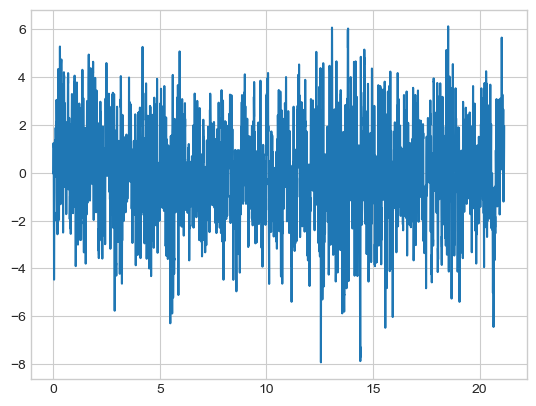

In [ ]:
# Rename channels to ReTune BIDS conform ch_names
mapping = {
    # RING
    # "LFP_Stn_R_03":"LFP_R_03_STN_MT",
    # "LFP_Stn_R_13":"LFP_R_13_STN_MT",
    # "LFP_Stn_R_02":"LFP_R_02_STN_MT",
    # "LFP_Stn_R_12":"LFP_R_12_STN_MT",
    # "LFP_Stn_R_01":"LFP_R_01_STN_MT",
    # "LFP_Stn_R_23":"LFP_R_23_STN_MT",
    "LFP_Stn_L_03":"LFP_L_03_STN_MT",
    "LFP_Stn_L_13":"LFP_L_13_STN_MT",
    "LFP_Stn_L_02":"LFP_L_02_STN_MT",
    "LFP_Stn_L_12":"LFP_L_12_STN_MT",
    "LFP_Stn_L_01":"LFP_L_01_STN_MT",
    "LFP_Stn_L_23":"LFP_L_23_STN_MT",
    
    # SEGMENTS
    # 'LFP_Stn_R_1A1B':"LFP_R_1A1B_STN_MT",
    # 'LFP_Stn_R_1B1C':"LFP_R_1B1C_STN_MT",
    # 'LFP_Stn_R_1A1C':"LFP_R_1A1C_STN_MT",
    # 'LFP_Stn_R_2A2B':"LFP_R_2A2B_STN_MT",
    # 'LFP_Stn_R_2B2C':"LFP_R_2B2C_STN_MT",
    # 'LFP_Stn_R_2A2C':"LFP_R_2A2C_STN_MT",
    # 'LFP_Stn_L_1A1B':"LFP_L_1A1B_STN_MT",
    # 'LFP_Stn_L_1B1C':"LFP_L_1B1C_STN_MT",
    # 'LFP_Stn_L_1A1C':"LFP_L_1A1C_STN_MT",
    # 'LFP_Stn_L_2A2B':"LFP_L_2A2B_STN_MT",
    # 'LFP_Stn_L_2B2C':"LFP_L_2B2C_STN_MT",
    # 'LFP_Stn_L_2A2C':"LFP_L_2A2C_STN_MT",
    # 'LFP_Stn_R_1A2A':"LFP_R_1A2A_STN_MT", 
    # 'LFP_Stn_R_1B2B':"LFP_R_1B2B_STN_MT", 
    # 'LFP_Stn_R_1C2C':"LFP_R_1C2C_STN_MT",
    # 'LFP_Stn_L_1A2A':"LFP_L_1A2A_STN_MT", 
    # 'LFP_Stn_L_1B2B':"LFP_L_1B2B_STN_MT", 
    # 'LFP_Stn_L_1C2C':"LFP_L_1C2C_STN_MT",
    
    
}

mne.rename_channels(info=raw.info, mapping=mapping, allow_duplicates=False)

In [56]:
# convert data to NumPy array
raw.get_data().shape


(6, 5288)

## 3. Exploring and plotting data

### Absolute PSD

In [33]:
import PerceiveImport.methods.psd_methods as psdm
importlib.reload(psdm)

<module 'PerceiveImport.methods.psd_methods' from 'c:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\code\\PerceiveImport\\methods\\psd_methods.py'>

calculate and plot PSD
- load the requested data with mne.read_raw_fieldtrip()
- High-pass filter 5Hz Butterworth filter (filterorder=5)
- transform the filtered time series data into power spectral density using Welch`s method
- plot PSD (V**2/Hz??) and frequencies


Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618062900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063200_4.mat
Creating RawArray with float64 data, n_channels=3, n_times=5187
    Range : 0 ... 5186 =      0.000 ...    20.744 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063300_5.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063400_6.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_7.mat
Creating RawArray with float64 data, n_channels=3,

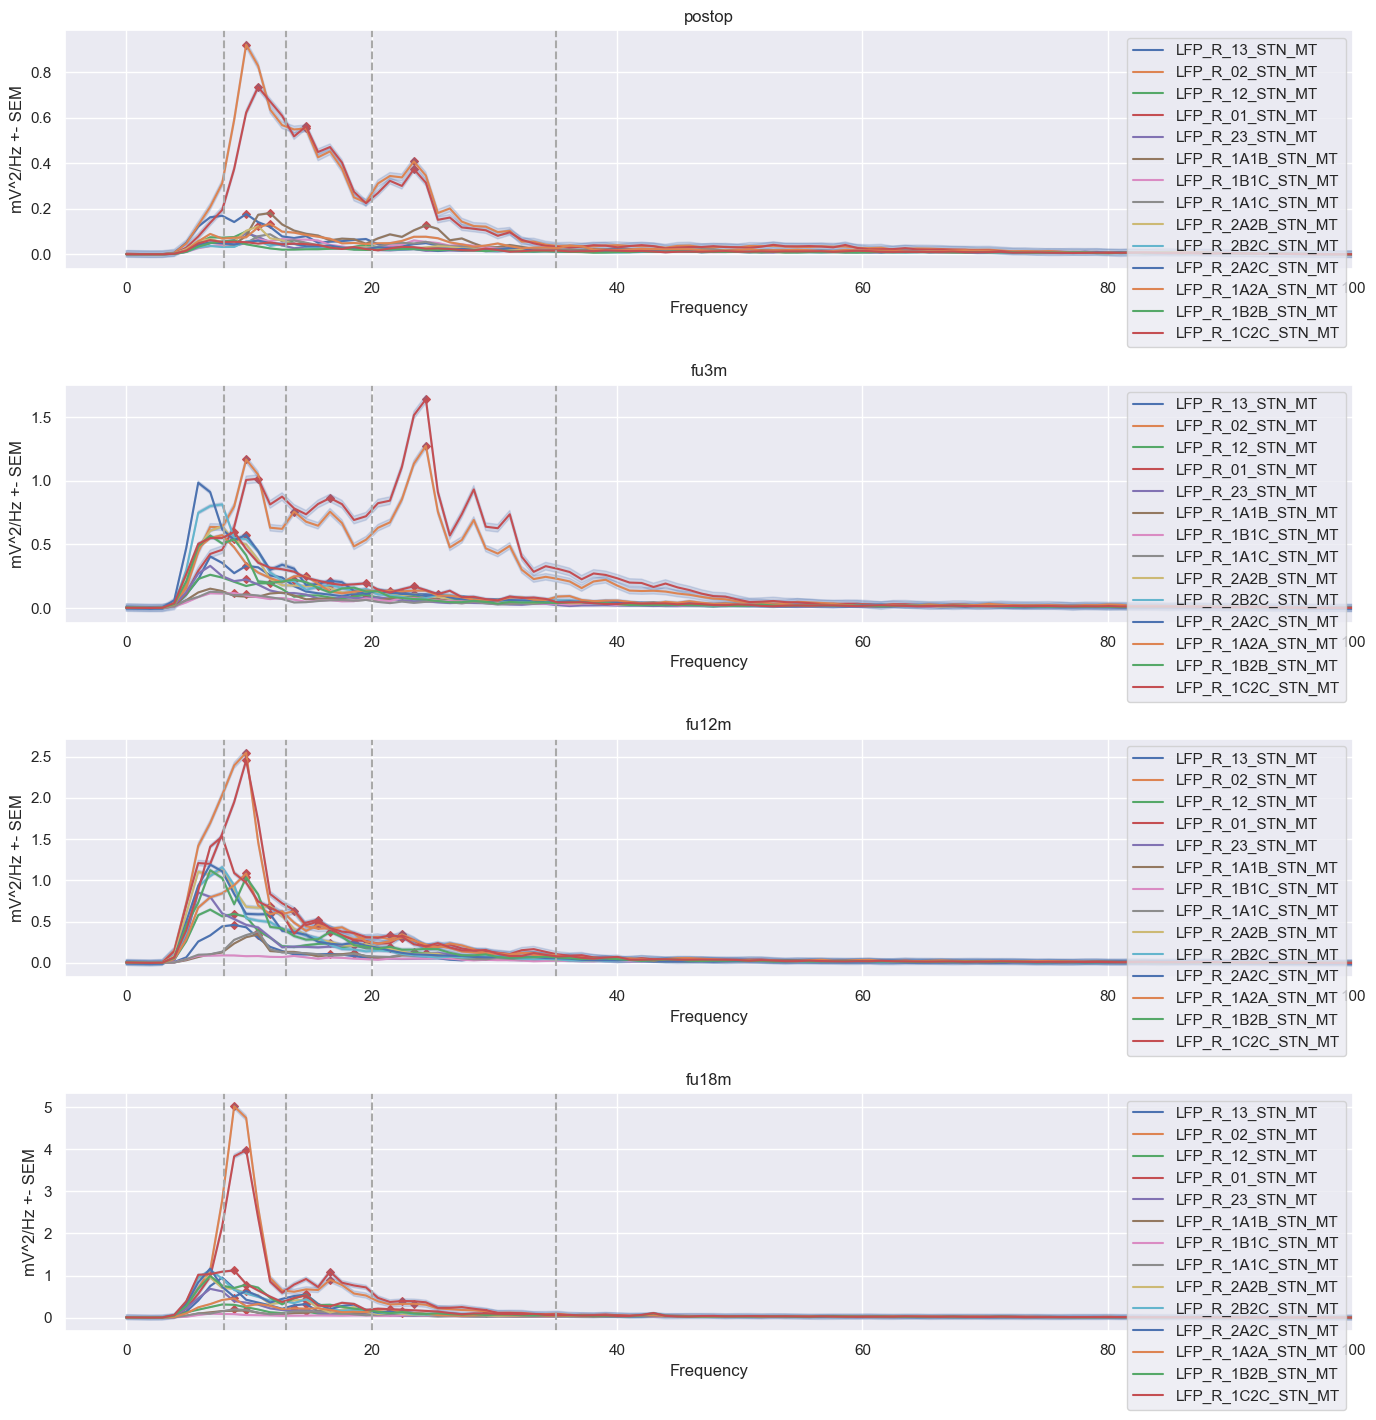

In [38]:
f_px_sub024 = psdm.welch_absolutePsd_survey_m0s0(
    incl_sub = "024", 
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    tasks=['RestBSSuRingR', 'RestBSSuSegmIntraR', 'RestBSSuSegmInterR'],
    pickChannels=['13', '02', '12', '01', '23', 
    '1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C', 
    '1A2A', '1B2B', '1C2C'])


In [13]:
f_px_sub024["highestPEAK"]

postop_LFP_R_13_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                    9.765625   
PEAK_absolutePSD                                  0.176548   

                  postop_LFP_R_02_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                    9.765625   
PEAK_absolutePSD                                  0.920829   

                  postop_LFP_R_02_STN_MT_highestPEAK_lowBeta  \
PEAK_frequency                                     14.648438   
PEAK_absolutePSD                                    0.552656   

                  postop_LFP_R_02_STN_MT_highestPEAK_highBeta  \
PEAK_frequency                                      23.437500   
PEAK_absolutePSD                                     0.407737   

                  postop_LFP_R_01_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                   10.742188   
PEAK_absolutePSD                                  0.734464   

                  postop_LFP_R_01_STN_MT_highestPEAK_lowBeta  \
PEAK_frequency                                     14.648438   
PEAK_absolutePSD                                    0.561984   

                  postop_LFP_R_01_STN_MT_highestPEAK_highBeta  \
PEAK_frequency                                      23.437500   
PEAK_absolutePSD                                     0.373856   

                  postop_LFP_R_1A1B_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                     11.718750   
PEAK_absolutePSD                                    0.180854   

                  postop_LFP_R_1A1B_STN_MT_highestPEAK_highBeta  \
PEAK_frequency                                        24.414062   
PEAK_absolutePSD                                       0.126986   

                  postop_LFP_R_2A2B_STN_MT_highestPEAK_alpha  ...  \
PEAK_frequency                                     10.742188  ...   
PEAK_absolutePSD                                    0.123066  ...   

                  fu18m_LFP_R_2A2C_STN_MT_highestPEAK_highBeta  \
PEAK_frequency                                       22.460938   
PEAK_absolutePSD                                      0.150169   

                  fu18m_LFP_R_1A2A_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                     8.789062   
PEAK_absolutePSD                                   0.455282   

                  fu18m_LFP_R_1A2A_STN_MT_highestPEAK_lowBeta  \
PEAK_frequency                                      13.671875   
PEAK_absolutePSD                                     0.220000   

                  fu18m_LFP_R_1A2A_STN_MT_highestPEAK_highBeta  \
PEAK_frequency                                       21.484375   
PEAK_absolutePSD                                      0.202276   

                  fu18m_LFP_R_1B2B_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                     9.765625   
PEAK_absolutePSD                                   0.780793   

                  fu18m_LFP_R_1B2B_STN_MT_highestPEAK_lowBeta  \
PEAK_frequency                                      14.648438   
PEAK_absolutePSD                                     0.540311   

                  fu18m_LFP_R_1B2B_STN_MT_highestPEAK_highBeta  \
PEAK_frequency                                       22.460938   
PEAK_absolutePSD                                      0.131223   

                  fu18m_LFP_R_1C2C_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                     8.789062   
PEAK_absolutePSD                                   1.121226   

                  fu18m_LFP_R_1C2C_STN_MT_highestPEAK_lowBeta  \
PEAK_frequency                                      14.648438   
PEAK_absolutePSD                                     0.531065   

                  fu18m_LFP_R_1C2C_STN_MT_highestPEAK_highBeta  
PEAK_frequency                                       29.296875  
PEAK_absolutePSD                                      0.101076  

[2 rows x 99 columns]

In [159]:
f_px_sub024.keys()

dict_keys(['frequenciesDataFrame', 'absolutePsdDataFrame', 'SEM', 'highestPEAK'])

In [96]:
# output of f_px_sub024 is a dictionary with keys: 
# ['frequenciesDataFrame', 'absolutePsdDataFrame', 'SEM']

frequencies_sub024 = f_px_sub024['frequenciesDataFrame']
psd_absolute_sub024 = f_px_sub024['absolutePsdDataFrame']

print(frequencies_sub024, psd_absolute_sub024)

     postop_LFP_Stn_R_03  postop_LFP_Stn_R_13  postop_LFP_Stn_R_02  \
0               0.000000             0.000000             0.000000   
1               0.976562             0.976562             0.976562   
2               1.953125             1.953125             1.953125   
3               2.929688             2.929688             2.929688   
4               3.906250             3.906250             3.906250   
..                   ...                  ...                  ...   
124           121.093750           121.093750           121.093750   
125           122.070312           122.070312           122.070312   
126           123.046875           123.046875           123.046875   
127           124.023438           124.023438           124.023438   
128           125.000000           125.000000           125.000000   

     postop_LFP_Stn_R_12  postop_LFP_Stn_R_01  postop_LFP_Stn_R_23  \
0               0.000000             0.000000             0.000000   
1               0.9

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618062900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063200_4.mat
Creating RawArray with float64 data, n_channels=3, n_times=5187
    Range : 0 ... 5186 =      0.000 ...    20.744 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063300_5.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063400_6.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_7.mat
Creating RawArray with float64 data, n_channels=3,

IndexError: index 2 is out of bounds for axis 0 with size 2

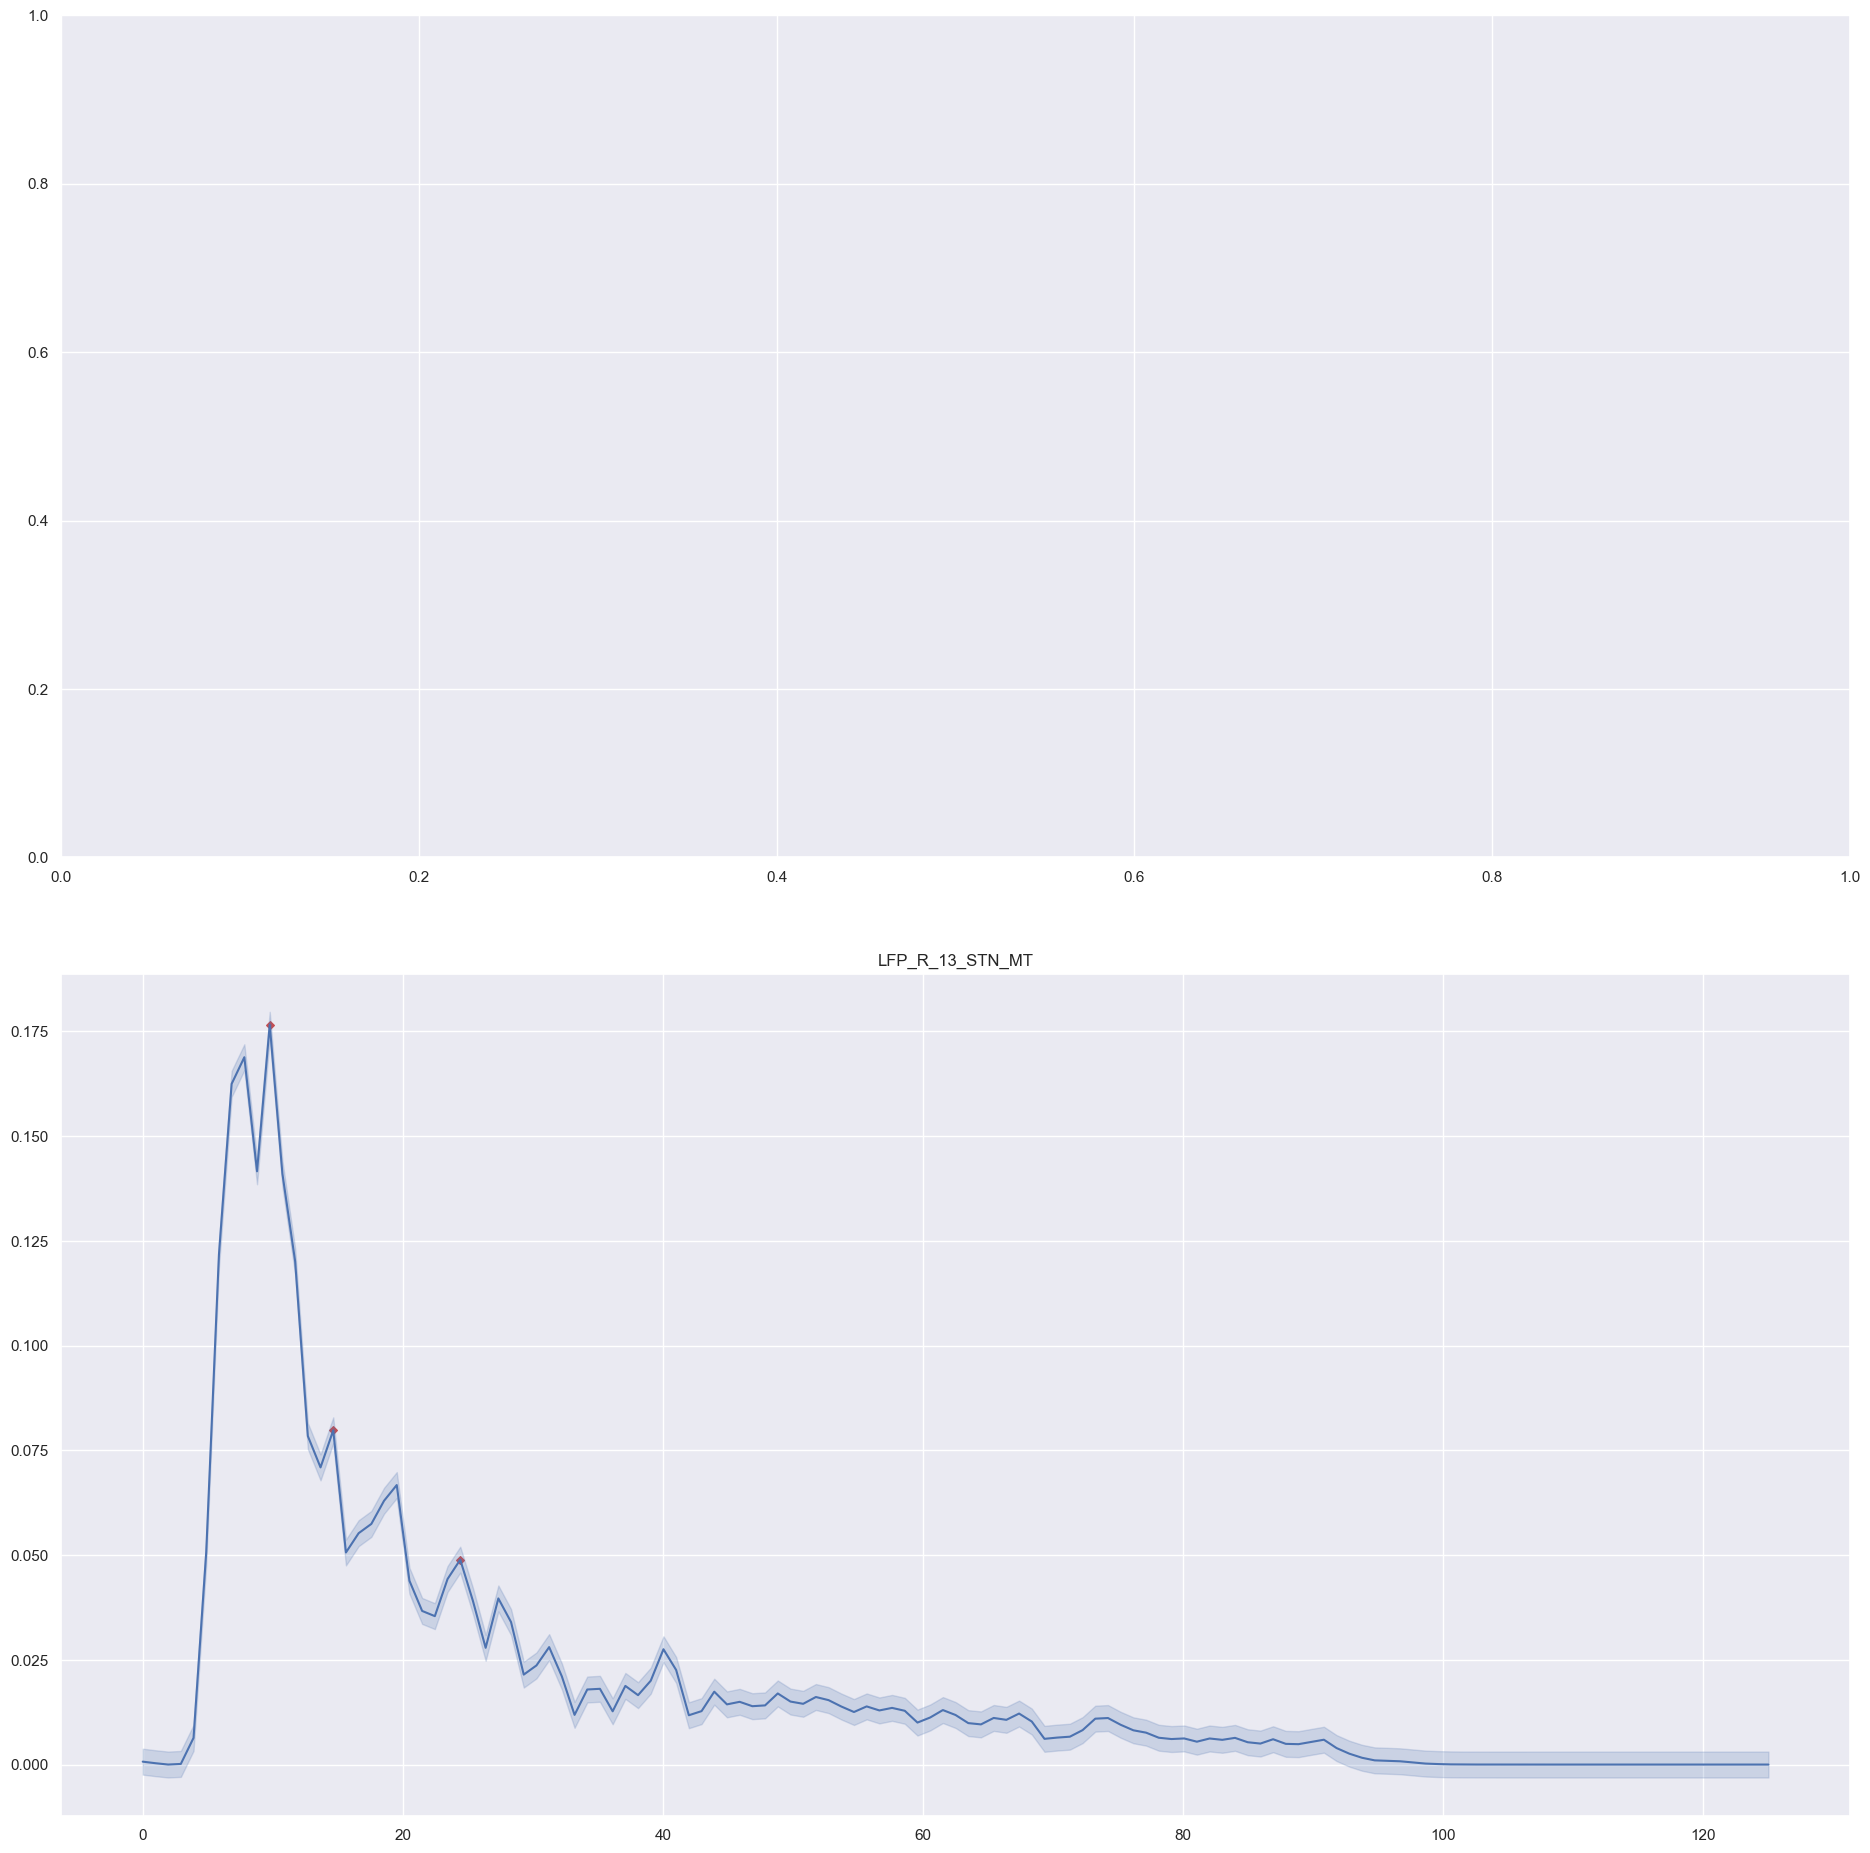

In [37]:
f_px_sub024 = psdm.perChannel_welch_absolutePsd(
    incl_sub = "024", 
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    tasks=['RestBSSuRingR'],
    pickChannels = ['13', '02']
    )

### Normalized PSD

Calculate and plot normalized psd to total sum
- Butterworth Filter: 5th order, 5Hz High-pass filter
- using the method sklearn.preprocessing.normalize()

In [31]:
import PerceiveImport.methods.peakAnalysis as peaksm
importlib.reload(peaksm)

<module 'PerceiveImport.methods.peakAnalysis' from 'c:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\code\\PerceiveImport\\methods\\peakAnalysis.py'>

Calculate and plot psd of each channel

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618062900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063200_4.mat
Creating RawArray with float64 data, n_channels=3, n_times=5187
    Range : 0 ... 5186 =      0.000 ...    20.744 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063300_5.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063400_6.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_7.mat
Creating RawArray with float64 data, n_channels=3,

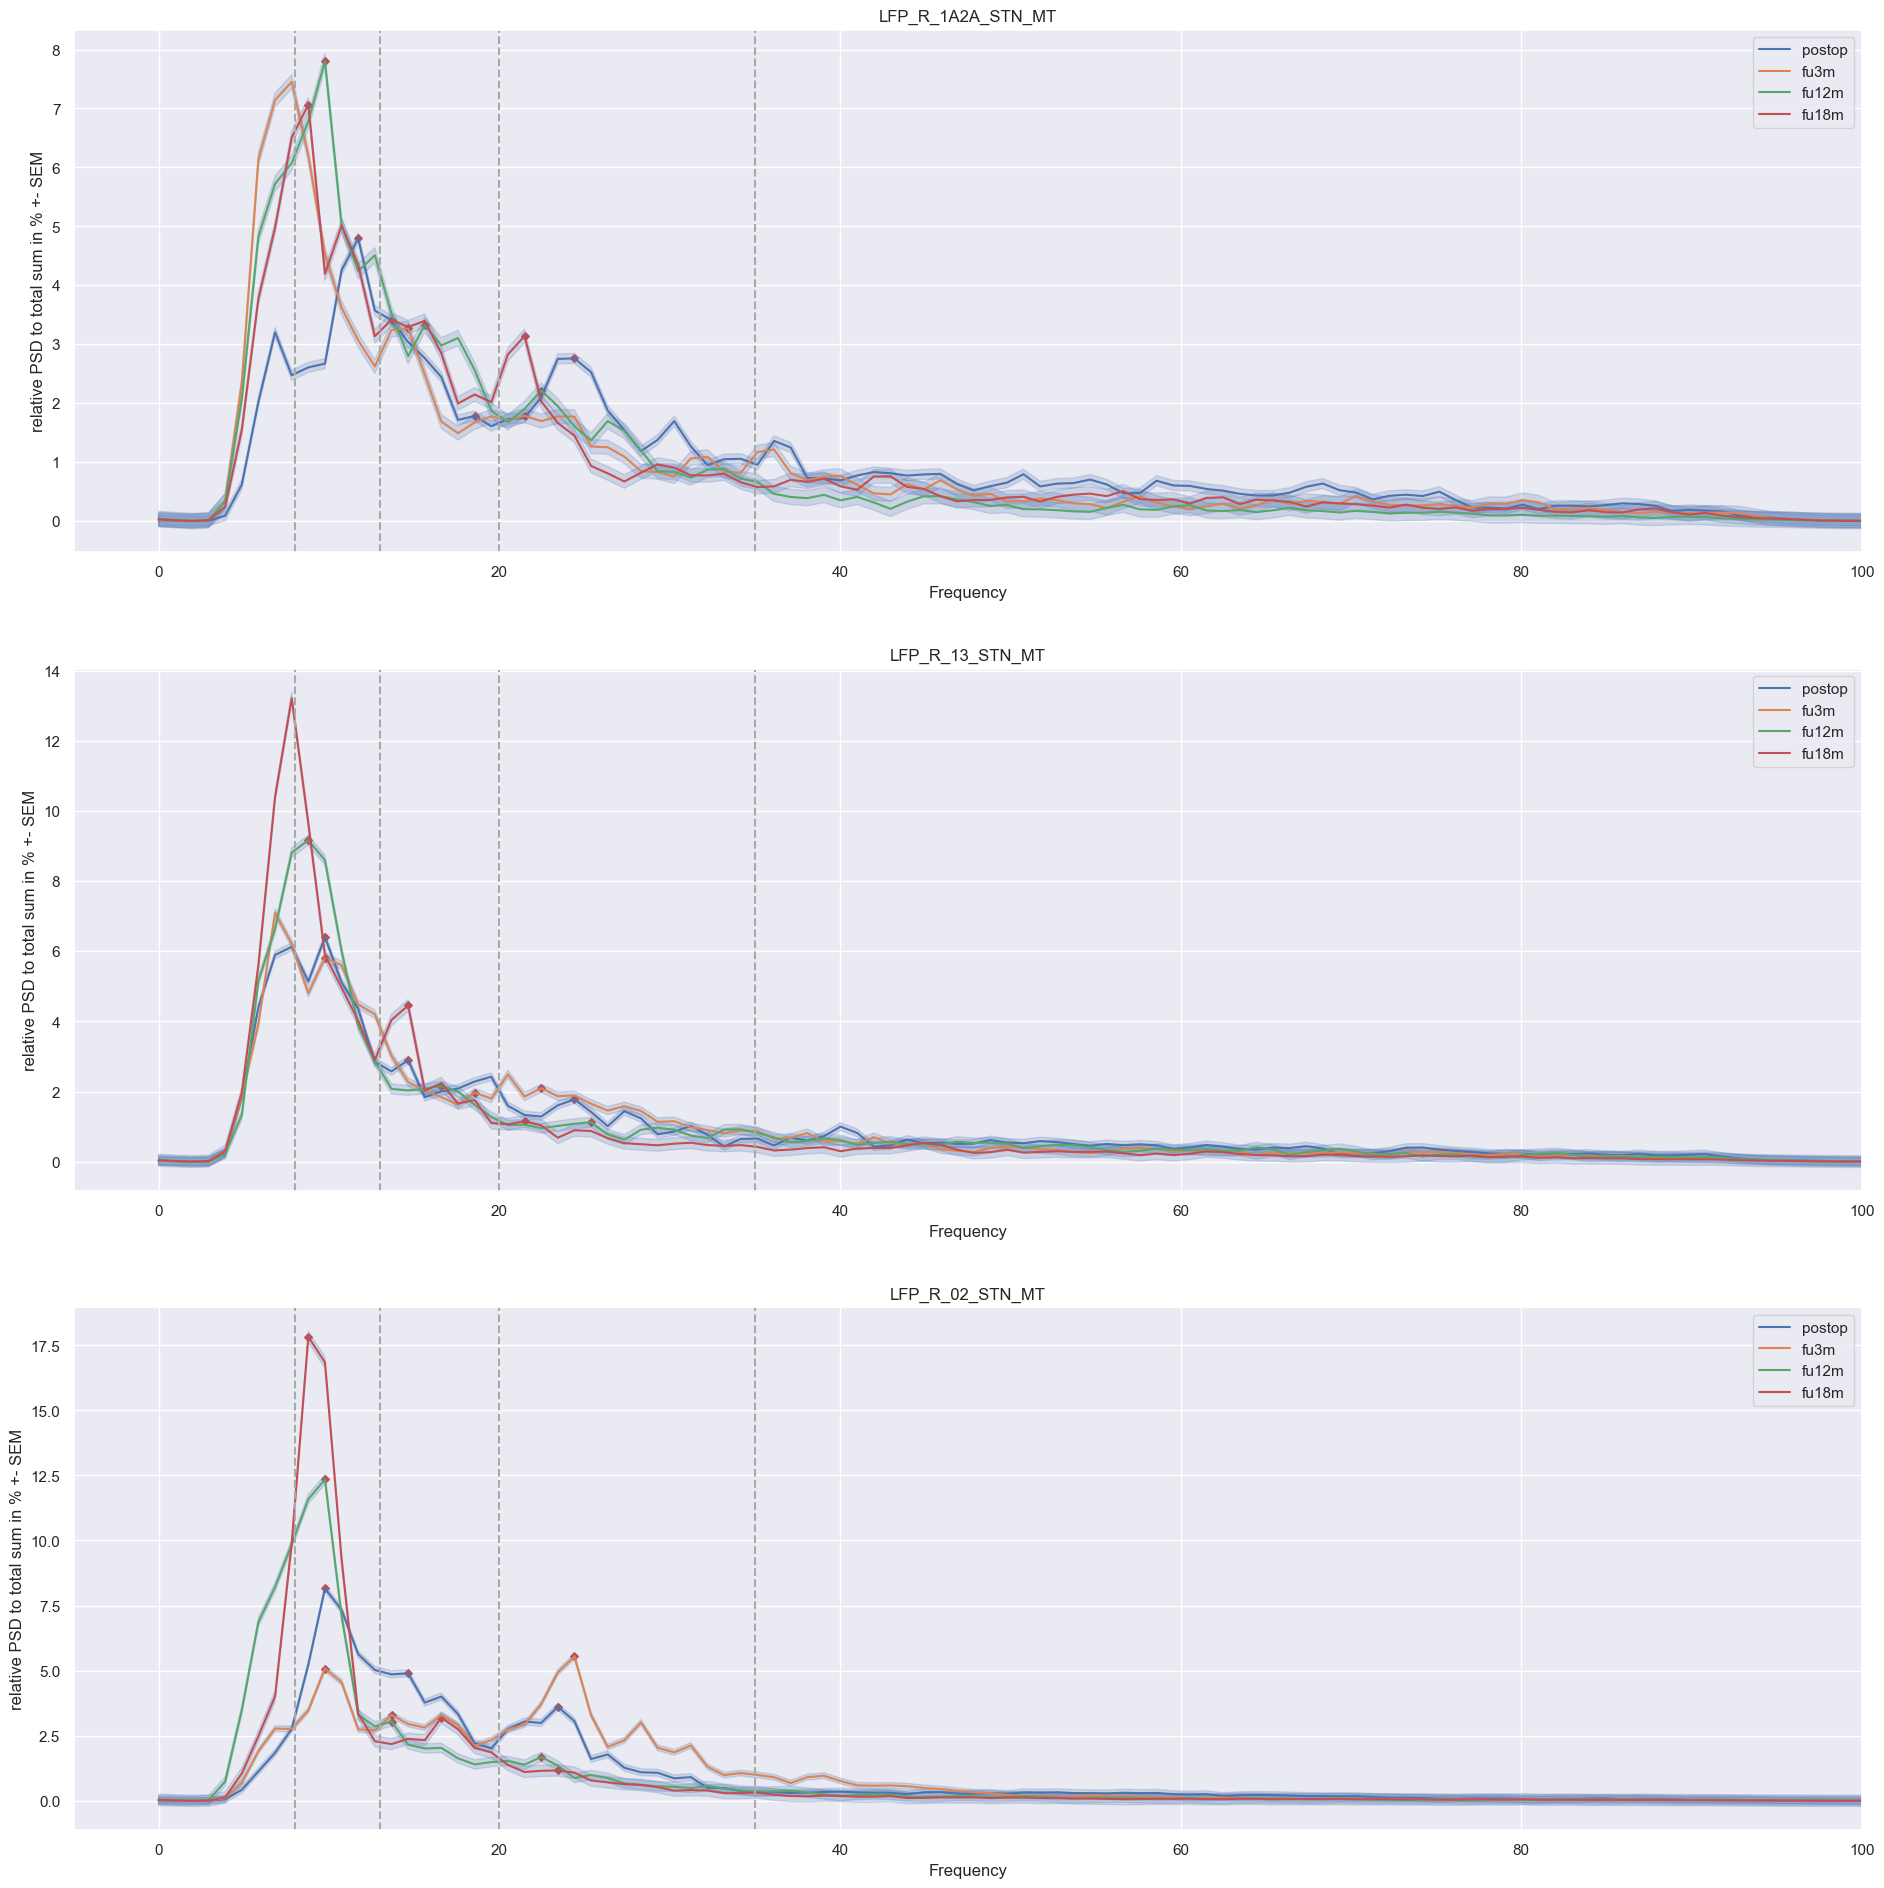

In [32]:
f_relPsd_024 = peaksm.perChannel_welch_normalizedPsd(
    incl_sub="024", 
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    tasks=['RestBSSuRingR', 'RestBSSuSegmIntraR', 'RestBSSuSegmInterR'],
    pickChannels=['13', '02', '1A2A']
)

# Troubleshooting
# code only works for some picked channels like 13, 1A2A but not for 13, 02 

# function only works for picked channels of one tasks: ['RestBSSuRingR', 'RestBSSuSegmIntraR', 'RestBSSuSegmInterR']
# don´t pick channels from multiple tasks, loop doesn´t work yet

Calculate and plot psd of each timepoint

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618062900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063200_4.mat
Creating RawArray with float64 data, n_channels=3, n_times=5187
    Range : 0 ... 5186 =      0.000 ...    20.744 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063300_5.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063400_6.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_7.mat
Creating RawArray with float64 data, n_channels=3,

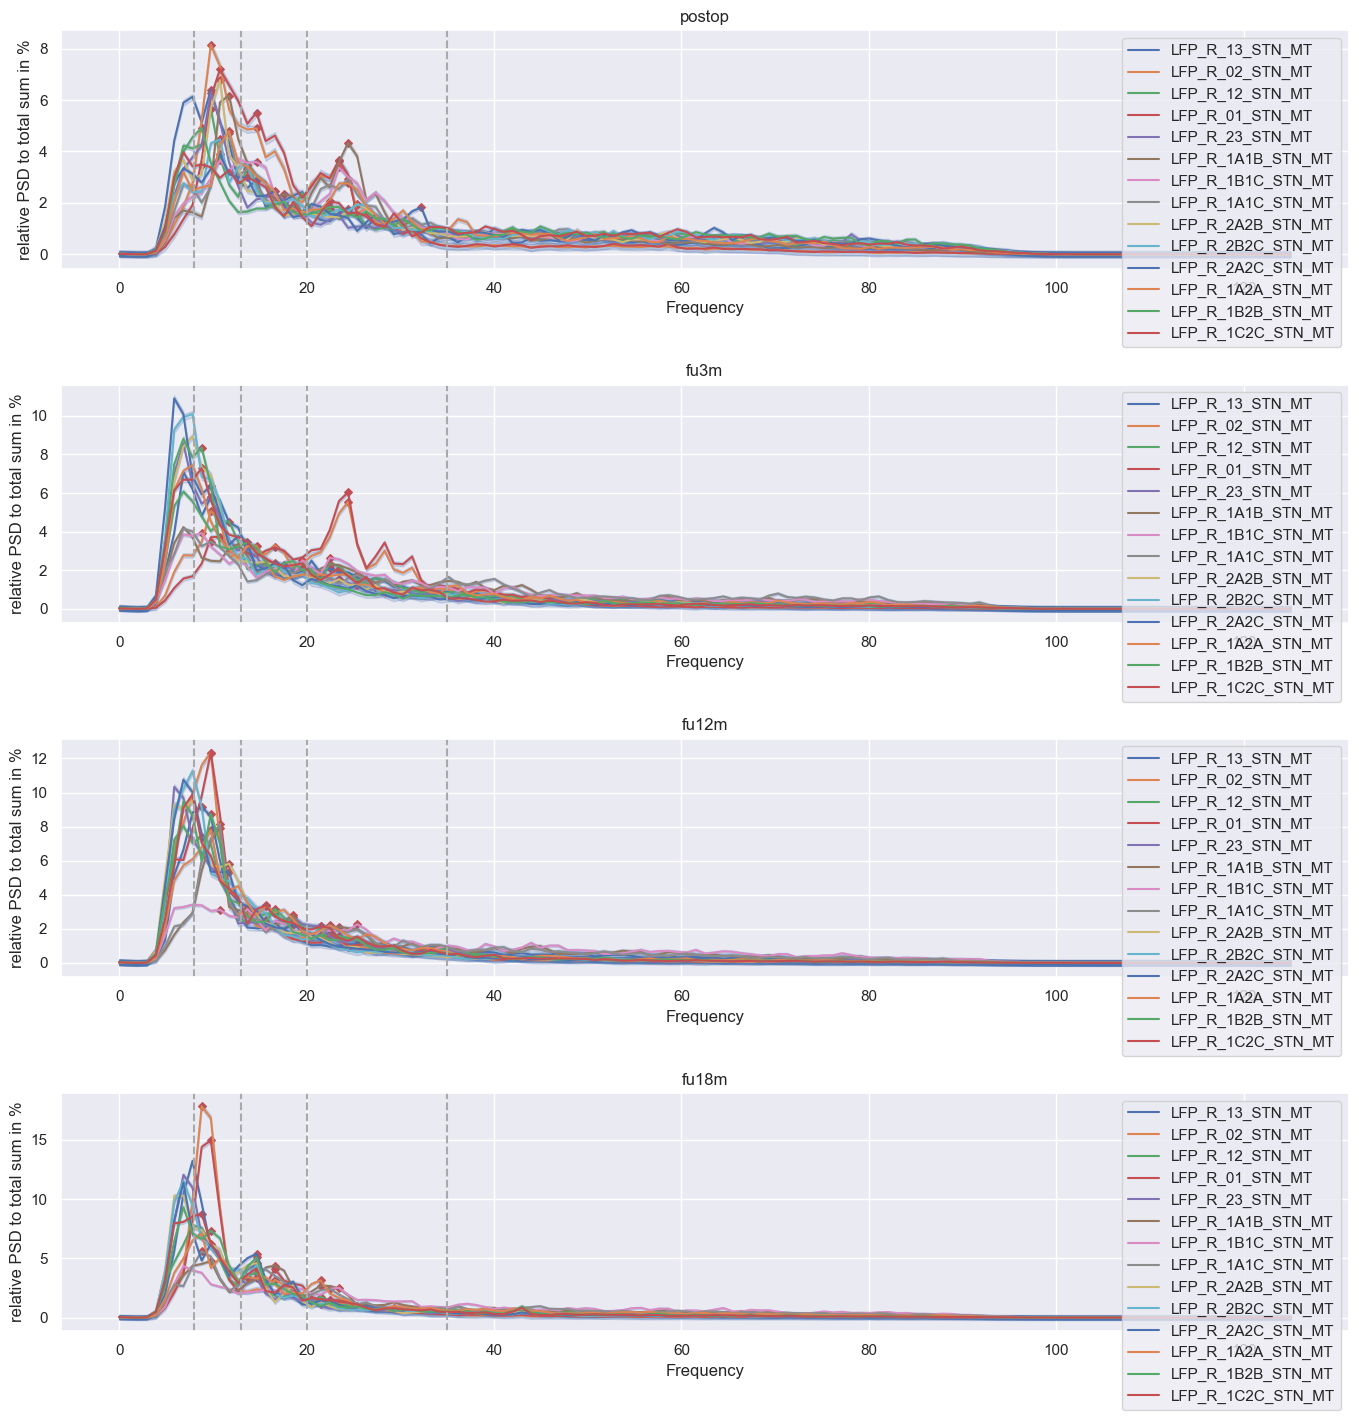

In [40]:
f_relPsd_024 = peaksm.welch_normalizedPsdToTotalSum_survey_m0s0(
    incl_sub="024", 
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    tasks=['RestBSSuRingR', 'RestBSSuSegmIntraR', 'RestBSSuSegmInterR'],
    pickChannels=['13', '02', '12', '01', '23', '1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C', 
    '1A2A', '1B2B', '1C2C']
)

# ['RestBSSuRingR', 'RestBSSuSegmIntraR', 'RestBSSuSegmInterR']

In [41]:
allFrequencies = f_relPsd_024["frequenciesDataFrame"]
allRelPsd = f_relPsd_024["relativePsdDataFrame"]
allRelPsd


postop_LFP_R_13_STN_MT  postop_LFP_R_02_STN_MT  postop_LFP_R_12_STN_MT  \
0              2.512576e-02            1.429892e-02            1.493985e-02   
1              1.166134e-02            6.602096e-03            6.914238e-03   
2              1.316705e-04            4.348582e-05            8.902063e-05   
3              5.442322e-03            2.165511e-03            4.673761e-03   
4              2.308704e-01            5.684811e-02            1.328681e-01   
..                      ...                     ...                     ...   
124            1.204336e-10            2.744224e-11            2.257100e-10   
125            1.093088e-10            2.433034e-11            2.058884e-10   
126            1.018476e-10            2.224861e-11            1.924879e-10   
127            9.755433e-11            2.105294e-11            1.847366e-10   
128            4.807643e-11            1.033149e-11            9.109982e-11   

     postop_LFP_R_01_STN_MT  postop_LFP_R_23_STN_MT  postop_LFP_R_1A1B_STN_MT  \
0              1.701663e-02            1.677421e-02              1.399243e-02   
1              7.996833e-03            7.703816e-03              6.570524e-03   
2              2.995758e-05            1.186165e-04              4.984343e-05   
3              9.820960e-04            5.001860e-03              2.143467e-03   
4              3.058617e-02            1.483668e-01              4.814295e-02   
..                      ...                     ...                       ...   
124            3.095023e-11            2.461140e-10              9.422674e-11   
125            2.786919e-11            2.268174e-10              8.356562e-11   
126            2.580052e-11            2.137942e-10              7.639657e-11   
127            2.460925e-11            2.062698e-10              7.226416e-11   
128            1.211010e-11            1.019042e-10              3.545701e-11   

     postop_LFP_R_1B1C_STN_MT  postop_LFP_R_1A1C_STN_MT  \
0                1.183070e-02              9.245591e-03   
1                5.350828e-03              4.430948e-03   
2                6.199150e-05              6.815018e-05   
3                2.770348e-03              2.006856e-03   
4                6.806325e-02              6.024563e-02   
..                        ...                       ...   
124              1.437784e-10              1.836099e-10   
125              1.315309e-10              1.679988e-10   
126              1.233117e-10              1.574822e-10   
127              1.185799e-10              1.514121e-10   
128              5.851739e-11              7.471370e-11   

     postop_LFP_R_2A2B_STN_MT  postop_LFP_R_2B2C_STN_MT  ...  \
0                1.615391e-02              1.593575e-02  ...   
1                7.169939e-03              7.252583e-03  ...   
2                1.570875e-04              1.028462e-04  ...   
3                6.725439e-03              3.389021e-03  ...   
4                2.042679e-01              1.210049e-01  ...   
..                        ...                       ...  ...   
124              2.118238e-10              1.410035e-10  ...   
125              1.939257e-10              1.219980e-10  ...   
126              1.818890e-10              1.092566e-10  ...   
127              1.749506e-10              1.019276e-10  ...   
128              8.634183e-11              4.976780e-11  ...   

     fu18m_LFP_R_23_STN_MT  fu18m_LFP_R_1A1B_STN_MT  fu18m_LFP_R_1B1C_STN_MT  \
0             3.388748e-02             2.292648e-02             1.640946e-02   
1             1.477470e-02             1.029744e-02             7.470866e-03   
2             4.799298e-04             1.859845e-04             1.404669e-04   
3             1.745800e-02             5.499707e-03             5.307893e-03   
4             5.382623e-01             1.406329e-01             1.557183e-01   
..                     ...                      ...                      ...   
124           5.280732e-11             1.5173

In [43]:
highestPEAKDF = f_relPsd_024["highestPEAK"]
highestPEAKDF

postop_LFP_R_13_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                    9.765625   
PEAK_relativePSD                                  6.407399   

                  postop_LFP_R_13_STN_MT_highestPEAK_lowBeta  \
PEAK_frequency                                     14.648438   
PEAK_relativePSD                                    2.894907   

                  postop_LFP_R_13_STN_MT_highestPEAK_highBeta  \
PEAK_frequency                                      24.414062   
PEAK_relativePSD                                     1.774502   

                  postop_LFP_R_02_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                    9.765625   
PEAK_relativePSD                                  8.158297   

                  postop_LFP_R_02_STN_MT_highestPEAK_lowBeta  \
PEAK_frequency                                     14.648438   
PEAK_relativePSD                                    4.896383   

                  postop_LFP_R_02_STN_MT_highestPEAK_highBeta  \
PEAK_frequency                                      23.437500   
PEAK_relativePSD                                     3.612439   

                  postop_LFP_R_12_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                    9.765625   
PEAK_relativePSD                                  5.661308   

                  postop_LFP_R_12_STN_MT_highestPEAK_lowBeta  \
PEAK_frequency                                     13.671875   
PEAK_relativePSD                                    3.491774   

                  postop_LFP_R_12_STN_MT_highestPEAK_highBeta  \
PEAK_frequency                                      22.460938   
PEAK_relativePSD                                     1.743981   

                  postop_LFP_R_01_STN_MT_highestPEAK_alpha  ...  \
PEAK_frequency                                   10.742188  ...   
PEAK_relativePSD                                  7.201758  ...   

                  fu18m_LFP_R_2A2C_STN_MT_highestPEAK_highBeta  \
PEAK_frequency                                       22.460938   
PEAK_relativePSD                                      1.468973   

                  fu18m_LFP_R_1A2A_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                     8.789062   
PEAK_relativePSD                                   7.066753   

                  fu18m_LFP_R_1A2A_STN_MT_highestPEAK_lowBeta  \
PEAK_frequency                                      13.671875   
PEAK_relativePSD                                     3.414778   

                  fu18m_LFP_R_1A2A_STN_MT_highestPEAK_highBeta  \
PEAK_frequency                                       21.484375   
PEAK_relativePSD                                      3.139661   

                  fu18m_LFP_R_1B2B_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                     9.765625   
PEAK_relativePSD                                   7.327810   

                  fu18m_LFP_R_1B2B_STN_MT_highestPEAK_lowBeta  \
PEAK_frequency                                      14.648438   
PEAK_relativePSD                                     5.070866   

                  fu18m_LFP_R_1B2B_STN_MT_highestPEAK_highBeta  \
PEAK_frequency                                       22.460938   
PEAK_relativePSD                                      1.231543   

                  fu18m_LFP_R_1C2C_STN_MT_highestPEAK_alpha  \
PEAK_frequency                                     8.789062   
PEAK_relativePSD                                   8.761958   

                  fu18m_LFP_R_1C2C_STN_MT_highestPEAK_lowBeta  \
PEAK_frequency                                      14.648438   
PEAK_relativePSD                                     4.150070   

                  fu18m_LFP_R_1C2C_STN_MT_highestPEAK_highBeta  
PEAK_frequency                                       29.296875  
PEAK_relativePSD                                      0.789868  

[2 rows x 154 columns]

In [119]:
highestPEAKDF['postop_LFP_Stn_R_03_highestPEAK_alpha'][0]

9.765625

Save the Highest Peak Dataframe into .csv

Plot only highest Peaks of each frequency band
- compare one channel over time
- compare all channels over each timepoint

In [11]:
# to plot using plotly create Dataframes with columns: session, Peak_frequency_alpha, PEAK_relativePsd_alpha
# get only columns of one session
incl_sessions = ["postop", "fu3m", "fu12m", "fu18m"]
highestPEAKDF = f_relPsd_024["highestPEAK"]

# create a dictionary for each frequency band with all channels at one timepoint 
sessions_alpha_dict = {}
sessions_lowbeta_dict = {}
sessions_highbeta_dict = {}

for t, tp in enumerate(incl_sessions):
    for 
    sessions_dict[f""]

postop = highestPEAKDF.filter(like="postop")
postop

# rank 


fu3m_LFP_Stn_R_03_highestPEAK_alpha  \
PEAK_frequency                               9.765625   
PEAK_relativePSD                             5.080319   

                  fu3m_LFP_Stn_R_03_highestPEAK_lowBeta  \
PEAK_frequency                                16.601562   
PEAK_relativePSD                               3.027667   

                  fu3m_LFP_Stn_R_03_highestPEAK_highBeta  \
PEAK_frequency                                 24.414062   
PEAK_relativePSD                                5.638845   

                  fu3m_LFP_Stn_R_13_highestPEAK_alpha  \
PEAK_frequency                               9.765625   
PEAK_relativePSD                             5.692922   

                  fu3m_LFP_Stn_R_13_highestPEAK_lowBeta  \
PEAK_frequency                                18.554688   
PEAK_relativePSD                               1.930265   

                  fu3m_LFP_Stn_R_13_highestPEAK_highBeta  \
PEAK_frequency                                 22.460938   
PEAK_relativePSD                                2.052722   

                  fu3m_LFP_Stn_R_02_highestPEAK_alpha  \
PEAK_frequency                               9.765625   
PEAK_relativePSD                             5.046574   

                  fu3m_LFP_Stn_R_02_highestPEAK_lowBeta  \
PEAK_frequency                                13.671875   
PEAK_relativePSD                               3.280412   

                  fu3m_LFP_Stn_R_02_highestPEAK_highBeta  \
PEAK_frequency                                 24.414062   
PEAK_relativePSD                                5.518271   

                  fu3m_LFP_Stn_R_12_highestPEAK_alpha  ...  \
PEAK_frequency                              11.718750  ...   
PEAK_relativePSD                             4.400709  ...   

                  fu3m_LFP_Stn_R_2A2C_highestPEAK_lowBeta  \
PEAK_frequency                                  16.601562   
PEAK_relativePSD                                 2.351928   

                  fu3m_LFP_Stn_R_2A2C_highestPEAK_highBeta  \
PEAK_frequency                                   25.390625   
PEAK_relativePSD                                  1.209202   

                  fu3m_LFP_Stn_R_1A2A_highestPEAK_lowBeta  \
PEAK_frequency                                  14.648438   
PEAK_relativePSD                                 3.193383   

                  fu3m_LFP_Stn_R_1A2A_highestPEAK_highBeta  \
PEAK_frequency                                   21.484375   
PEAK_relativePSD                                  1.743084   

                  fu3m_LFP_Stn_R_1B2B_highestPEAK_alpha  \
PEAK_frequency                                 8.789062   
PEAK_relativePSD                               8.213522   

                  fu3m_LFP_Stn_R_1B2B_highestPEAK_lowBeta  \
PEAK_frequency                                  13.671875   
PEAK_relativePSD                                 3.406566   

                  fu3m_LFP_Stn_R_1B2B_highestPEAK_highBeta  \
PEAK_frequency                                   28.320312   
PEAK_relativePSD                                  0.851350   

                  fu3m_LFP_Stn_R_1C2C_highestPEAK_alpha  \
PEAK_frequency                                 8.789062   
PEAK_relativePSD                               7.148511   

                  fu3m_LFP_Stn_R_1C2C_highestPEAK_lowBeta  \
PEAK_frequency                                  19.531250   
PEAK_relativePSD                                 2.320287   

                  fu3m_LFP_Stn_R_1C2C_highestPEAK_highBeta  
PEAK_frequency                                   23.437500  
PEAK_relativePSD                                  2.045466  

[2 rows x 41 columns]

save the relevant keys of the dictionary output as 
- frequencies_subXX
- psd_absolute_subXX

In [82]:
import sklearn
from sklearn.preprocessing import normalize


X = np.array([1., -1.,  2.])
print(X)
X_2D = X.reshape(1,-1)
print(X_2D)
X_norm = normalize(X_2D, norm='l1')

X_1D = X_norm.reshape(-1,)

print(X_norm, X_1D)

[ 1. -1.  2.]
[[ 1. -1.  2.]]
[[ 0.25 -0.25  0.5 ]] [ 0.25 -0.25  0.5 ]


normalize the psd values to the total sum of each power spectrum
use the Dataframes 
- frequencies_subXX
- psd_absolute_subXX

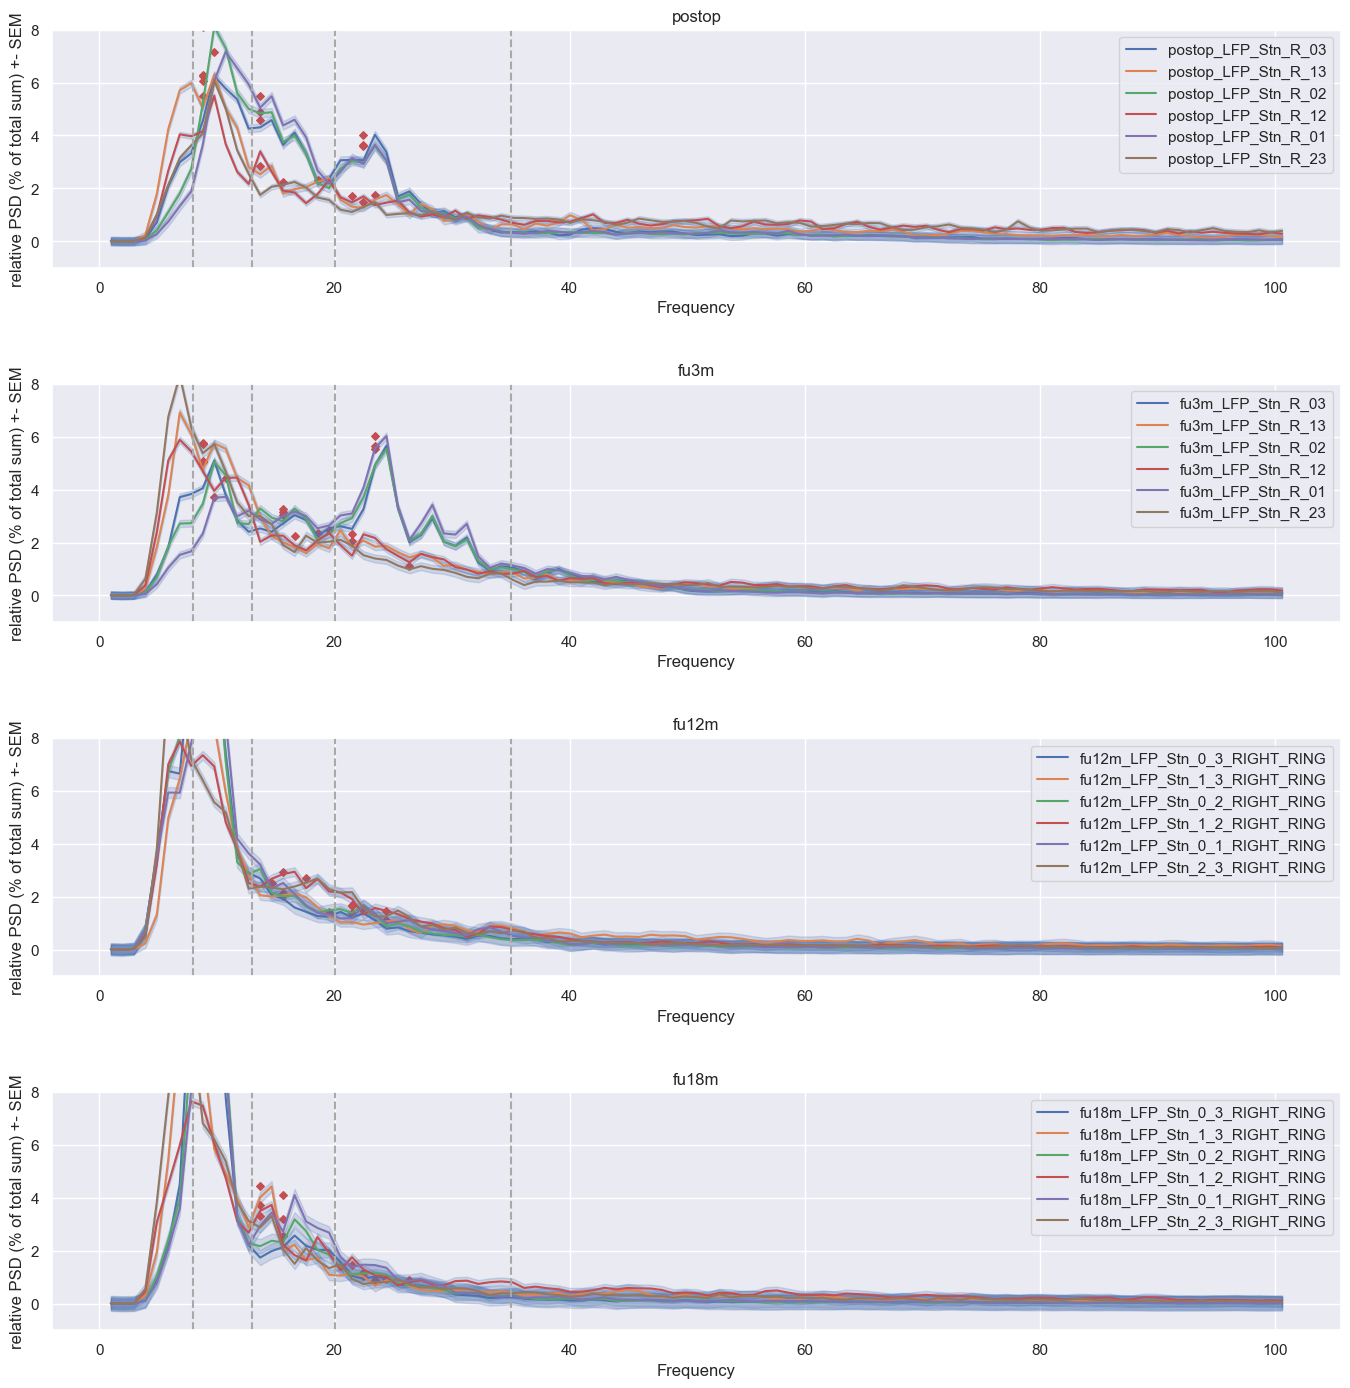

In [199]:
f_relPsd_024 = psdm.normalize_psd_toTotalSum(
   frequenciesDataFrame= frequencies_sub024,
   absolutePsdDataFrame= psd_absolute_sub024
)

In [197]:
f_relPsd_024["highestrelativePEAK"]

postop_postop_LFP_Stn_R_03_highestPEAK_alpha  \
PEAK_frequency    9    8.789062
Name: postop_LFP_Stn_R_03, dtype...   
PEAK_absolutePSD                                           6.245183   

                     postop_postop_LFP_Stn_R_03_highestPEAK_lowBeta  \
PEAK_frequency    14    13.671875
Name: postop_LFP_Stn_R_03, dty...   
PEAK_absolutePSD                                           4.580668   

                    postop_postop_LFP_Stn_R_03_highestPEAK_highBeta  \
PEAK_frequency    23    22.460938
Name: postop_LFP_Stn_R_03, dty...   
PEAK_absolutePSD                                           4.027955   

                       postop_postop_LFP_Stn_R_13_highestPEAK_alpha  \
PEAK_frequency    9    8.789062
Name: postop_LFP_Stn_R_13, dtype...   
PEAK_absolutePSD                                           6.299124   

                     postop_postop_LFP_Stn_R_13_highestPEAK_lowBeta  \
PEAK_frequency    14    13.671875
Name: postop_LFP_Stn_R_13, dty...   
PEAK_absolutePSD                                           2.849699   

                    postop_postop_LFP_Stn_R_13_highestPEAK_highBeta  \
PEAK_frequency    24    23.4375
Name: postop_LFP_Stn_R_13, dtype...   
PEAK_absolutePSD                                           1.746857   

                       postop_postop_LFP_Stn_R_02_highestPEAK_alpha  \
PEAK_frequency    9    8.789062
Name: postop_LFP_Stn_R_02, dtype...   
PEAK_absolutePSD                                           8.115668   

                     postop_postop_LFP_Stn_R_02_highestPEAK_lowBeta  \
PEAK_frequency    14    13.671875
Name: postop_LFP_Stn_R_02, dty...   
PEAK_absolutePSD                                           4.877072   

                    postop_postop_LFP_Stn_R_02_highestPEAK_highBeta  \
PEAK_frequency    23    22.460938
Name: postop_LFP_Stn_R_02, dty...   
PEAK_absolutePSD                                           3.598328   

                       postop_postop_LFP_Stn_R_12_highestPEAK_alpha  ...  \
PEAK_frequency    9    8.789062
Name: postop_LFP_Stn_R_12, dtype...  ...   
PEAK_absolutePSD                                           5.500083  ...   

                 fu18m_fu18m_LFP_Stn_1_3_RIGHT_RING_highestPEAK_highBeta  \
PEAK_frequency    24    23.4375
Name: fu18m_LFP_Stn_1_3_RIGHT_RI...        
PEAK_absolutePSD                                           0.890724        

                 fu18m_fu18m_LFP_Stn_0_2_RIGHT_RING_highestPEAK_lowBeta  \
PEAK_frequency    16    15.625
Name: fu18m_LFP_Stn_0_2_RIGHT_RIN...       
PEAK_absolutePSD                                           3.191064       

                 fu18m_fu18m_LFP_Stn_0_2_RIGHT_RING_highestPEAK_highBeta  \
PEAK_frequency    23    22.460938
Name: fu18m_LFP_Stn_0_2_RIGHT_...        
PEAK_absolutePSD                                            1.16556        

                 fu18m_fu18m_LFP_Stn_1_2_RIGHT_RING_highestPEAK_lowBeta  \
PEAK_frequency    14    13.671875
Name: fu18m_LFP_Stn_1_2_RIGHT_...       
PEAK_absolutePSD                                           3.735473       

                 fu18m_fu18m_LFP_Stn_1_2_RIGHT_RING_highestPEAK_highBeta  \
PEAK_frequency    27    26.367188
Name: fu18m_LFP_Stn_1_2_RIGHT_...        
PEAK_absolutePSD                                           0.888223        

                 fu18m_fu18m_LFP_Stn_0_1_RIGHT_RING_highestPEAK_alpha  \
PEAK_frequency    9    8.789062
Name: fu18m_LFP_Stn_0_1_RIGHT_RI...     
PEAK_absolutePSD                                          14.913601     

                 fu18m_fu18m_LFP_Stn_0_1_RIGHT_RING_highestPEAK_lowBeta  \
PEAK_frequency    16    15.625
Name: fu18m_LFP_Stn_0_1_RIGHT_RIN...       
PEAK_absolutePSD                                           4.106471       

                 fu18m_fu18m_LFP_Stn_0_1_RIGHT_RING_highestPEAK_highBeta  \
PEAK_frequency    22    21.484375
Name: fu18m_LFP_Stn_0_1_RIGHT_...        
PEAK_absolutePSD                                           1.478995        

                 fu18m_fu18m_LFP_Stn_2_3_RIGHT_RING_hi

Mark the highest PEAK of each Power Spectrum
- within each frequency band: 8-12 Hz, 13-20 Hz, 21-35 Hz
- save the highest Peaks (frequency and relative PSD) in an array
- rank which bipolar recording presents the highest beta peak 

Perform FOOOF (Fit Outliers of Oscillation frequency) to seperate periodic and aperiodic components of the power spectrum
- install FOOOF via conda
$ conda install -c conda-forge fooof

In [11]:
import fooof
import PerceiveImport.classes.main_class as mainclass

In [12]:
# load the data
raw_sub024 = mainclass.PerceiveData(
    sub = "024",
    incl_modalities= ["survey"],
    incl_session= ["postop","fu3m","fu12m","fu18m"],
    incl_condition=["m0s0"],
    incl_task= ["rest"]
)



Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618062900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063200_4.mat
Creating RawArray with float64 data, n_channels=3, n_times=5187
    Range : 0 ... 5186 =      0.000 ...    20.744 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063300_5.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063400_6.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_7.mat
Creating RawArray with float64 data, n_channels=3,

In [13]:

sub024_postop_RingR = raw_sub024.survey.postop.m0s0.rest.data['RestBSSuRingR']
data=sub024_postop_RingR.get_data()

LFP_Stn_R_03 = data[0]

In [55]:
# Set the parameters for FOOOF
sampling_rate = 250  # Sampling rate of the LFP signal
fmin = 1  # Lower frequency limit for the power spectrum
fmax = 100  # Upper frequency limit for the power spectrum

# Calculate the power spectrum of the LFP signal using FOOOF
fooof_model = fooof.FOOOF(max_n_peaks=5, min_peak_height=0.1)
fooof_model.fit(sampling_rate, LFP_Stn_R_03, fmin, fmax)

# Get the periodic and aperiodic components of the power spectrum
periodic_component = fooof_model.background_params_
aperiodic_component = fooof_model.aperiodic_params_

# Plot the power spectrum and its components
plt.plot(fooof_model.freqs_, fooof_model.power_spectrum_, label="Power spectrum")
plt.plot(fooof_model.freqs_, periodic_component, label="Periodic component")
plt.plot(fooof_model.freqs_, aperiodic_component, label="Aperiodic component")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.show()

TypeError: FOOOF.fit() takes from 1 to 4 positional arguments but 5 were given

Plot one channel over time
- apply 5Hz high-frequency Butterworth filter (fifth order)
- Welch´s method



In [58]:
import PerceiveImport.methods.psd_methods as psdm
importlib.reload(psdm)

<module 'PerceiveImport.methods.psd_methods' from 'c:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\code\\PerceiveImport\\methods\\psd_methods.py'>

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618062900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063200_4.mat
Creating RawArray with float64 data, n_channels=3, n_times=5187
    Range : 0 ... 5186 =      0.000 ...    20.744 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063300_5.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063400_6.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_7.mat
Creating RawArray with float64 data, n_channels=3,

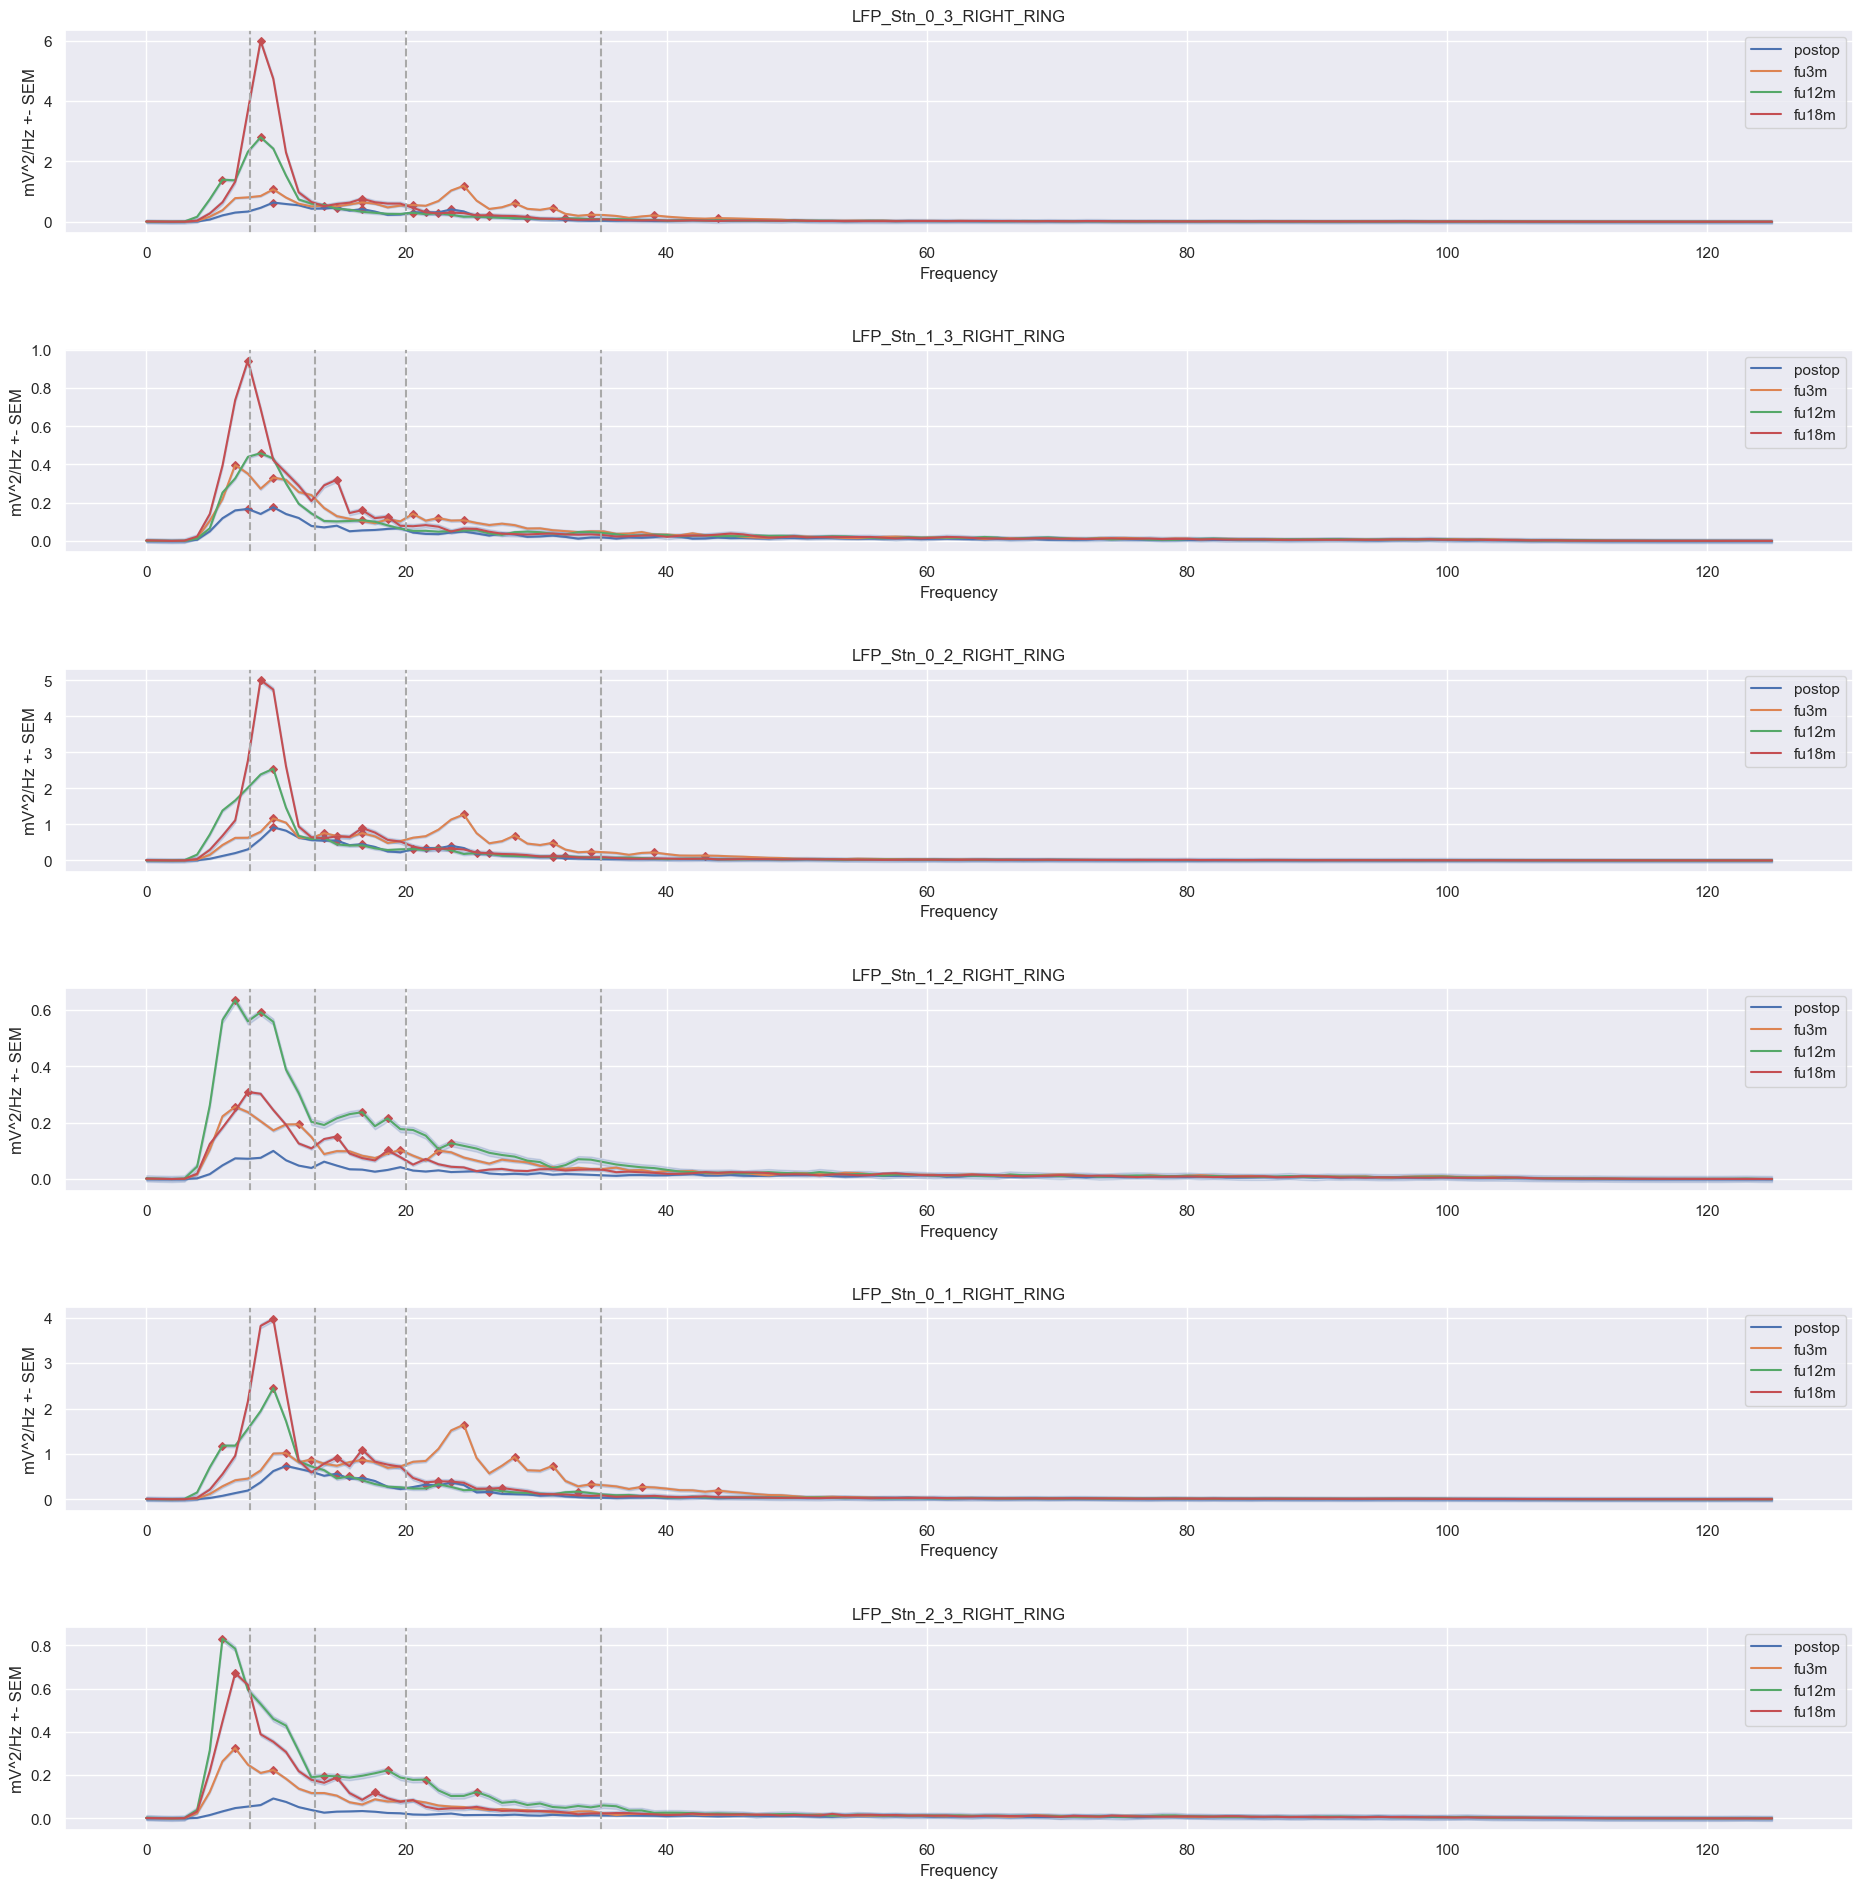

In [63]:
f_px_sub024 = psdm.perChannel_psd(
    incl_sub = "024", 
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    tasks=['RestBSSuRingR','RestBSSuSegmInterR', 'RestBSSuSegmIntraR'])

save frequencies and absolute psd values 

In [61]:
# output of f_px_sub024 is a dictionary with keys: 
# ['frequenciesDataFrame', 'absolutePsdDataFrame', 'SEM']

frequencies_sub024 = f_px_sub024['frequenciesDataFrame']
psd_absolute_sub024 = f_px_sub024['absolutePsdDataFrame']

print(frequencies_sub024, psd_absolute_sub024)

     postop_LFP_Stn_R_1A2A  postop_LFP_Stn_R_1B2B  postop_LFP_Stn_R_1C2C  \
0                 0.000000               0.000000               0.000000   
1                 0.976562               0.976562               0.976562   
2                 1.953125               1.953125               1.953125   
3                 2.929688               2.929688               2.929688   
4                 3.906250               3.906250               3.906250   
..                     ...                    ...                    ...   
124             121.093750             121.093750             121.093750   
125             122.070312             122.070312             122.070312   
126             123.046875             123.046875             123.046875   
127             124.023438             124.023438             124.023438   
128             125.000000             125.000000             125.000000   

     fu3m_LFP_Stn_R_1A2A  fu3m_LFP_Stn_R_1B2B  fu3m_LFP_Stn_R_1C2C  \
0               0

Normalize psd values to total sum of power spectrum

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618062900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063200_4.mat
Creating RawArray with float64 data, n_channels=3, n_times=5187
    Range : 0 ... 5186 =      0.000 ...    20.744 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063300_5.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063400_6.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_7.mat
Creating RawArray with float64 data, n_channels=3,

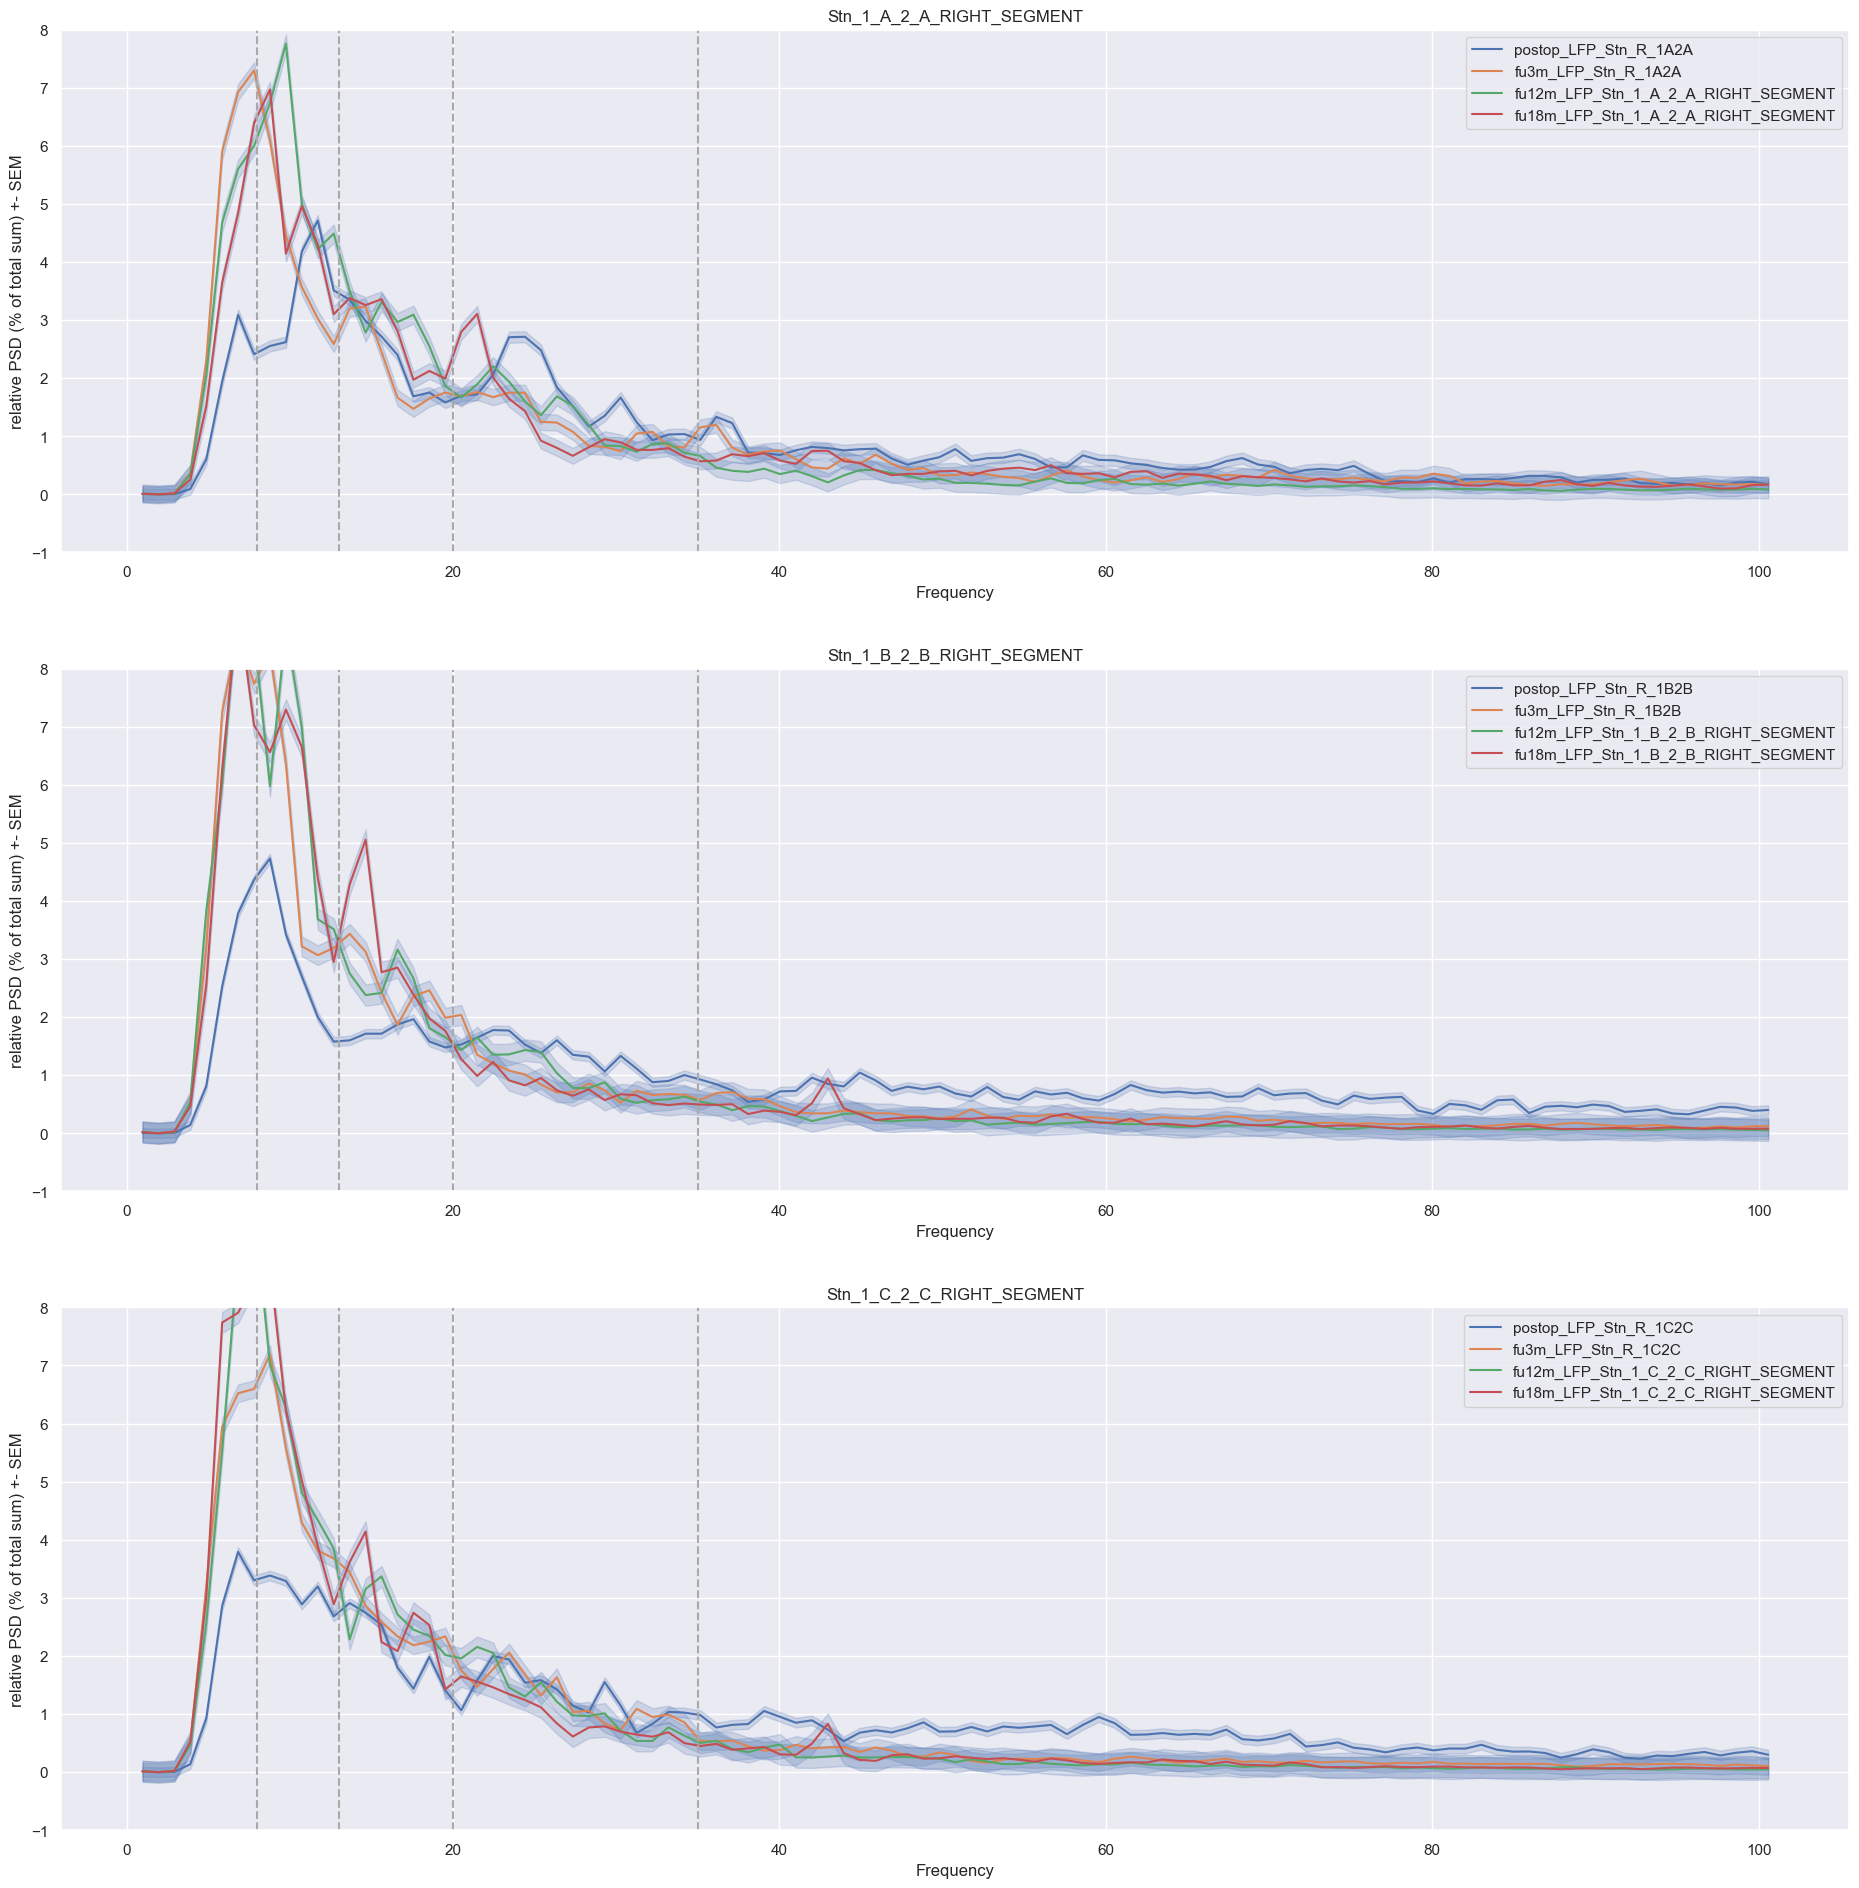

In [62]:
f_relPsd_024 = psdm.normalize_totalSum_perChannelPSD(
   incl_sub = "024", 
   incl_session = ["postop", "fu3m", "fu12m", "fu18m"], 
   tasks=['RestBSSuSegmInterR'],
   frequenciesDataFrame= frequencies_sub024,
   absolutePsdDataFrame= psd_absolute_sub024
)

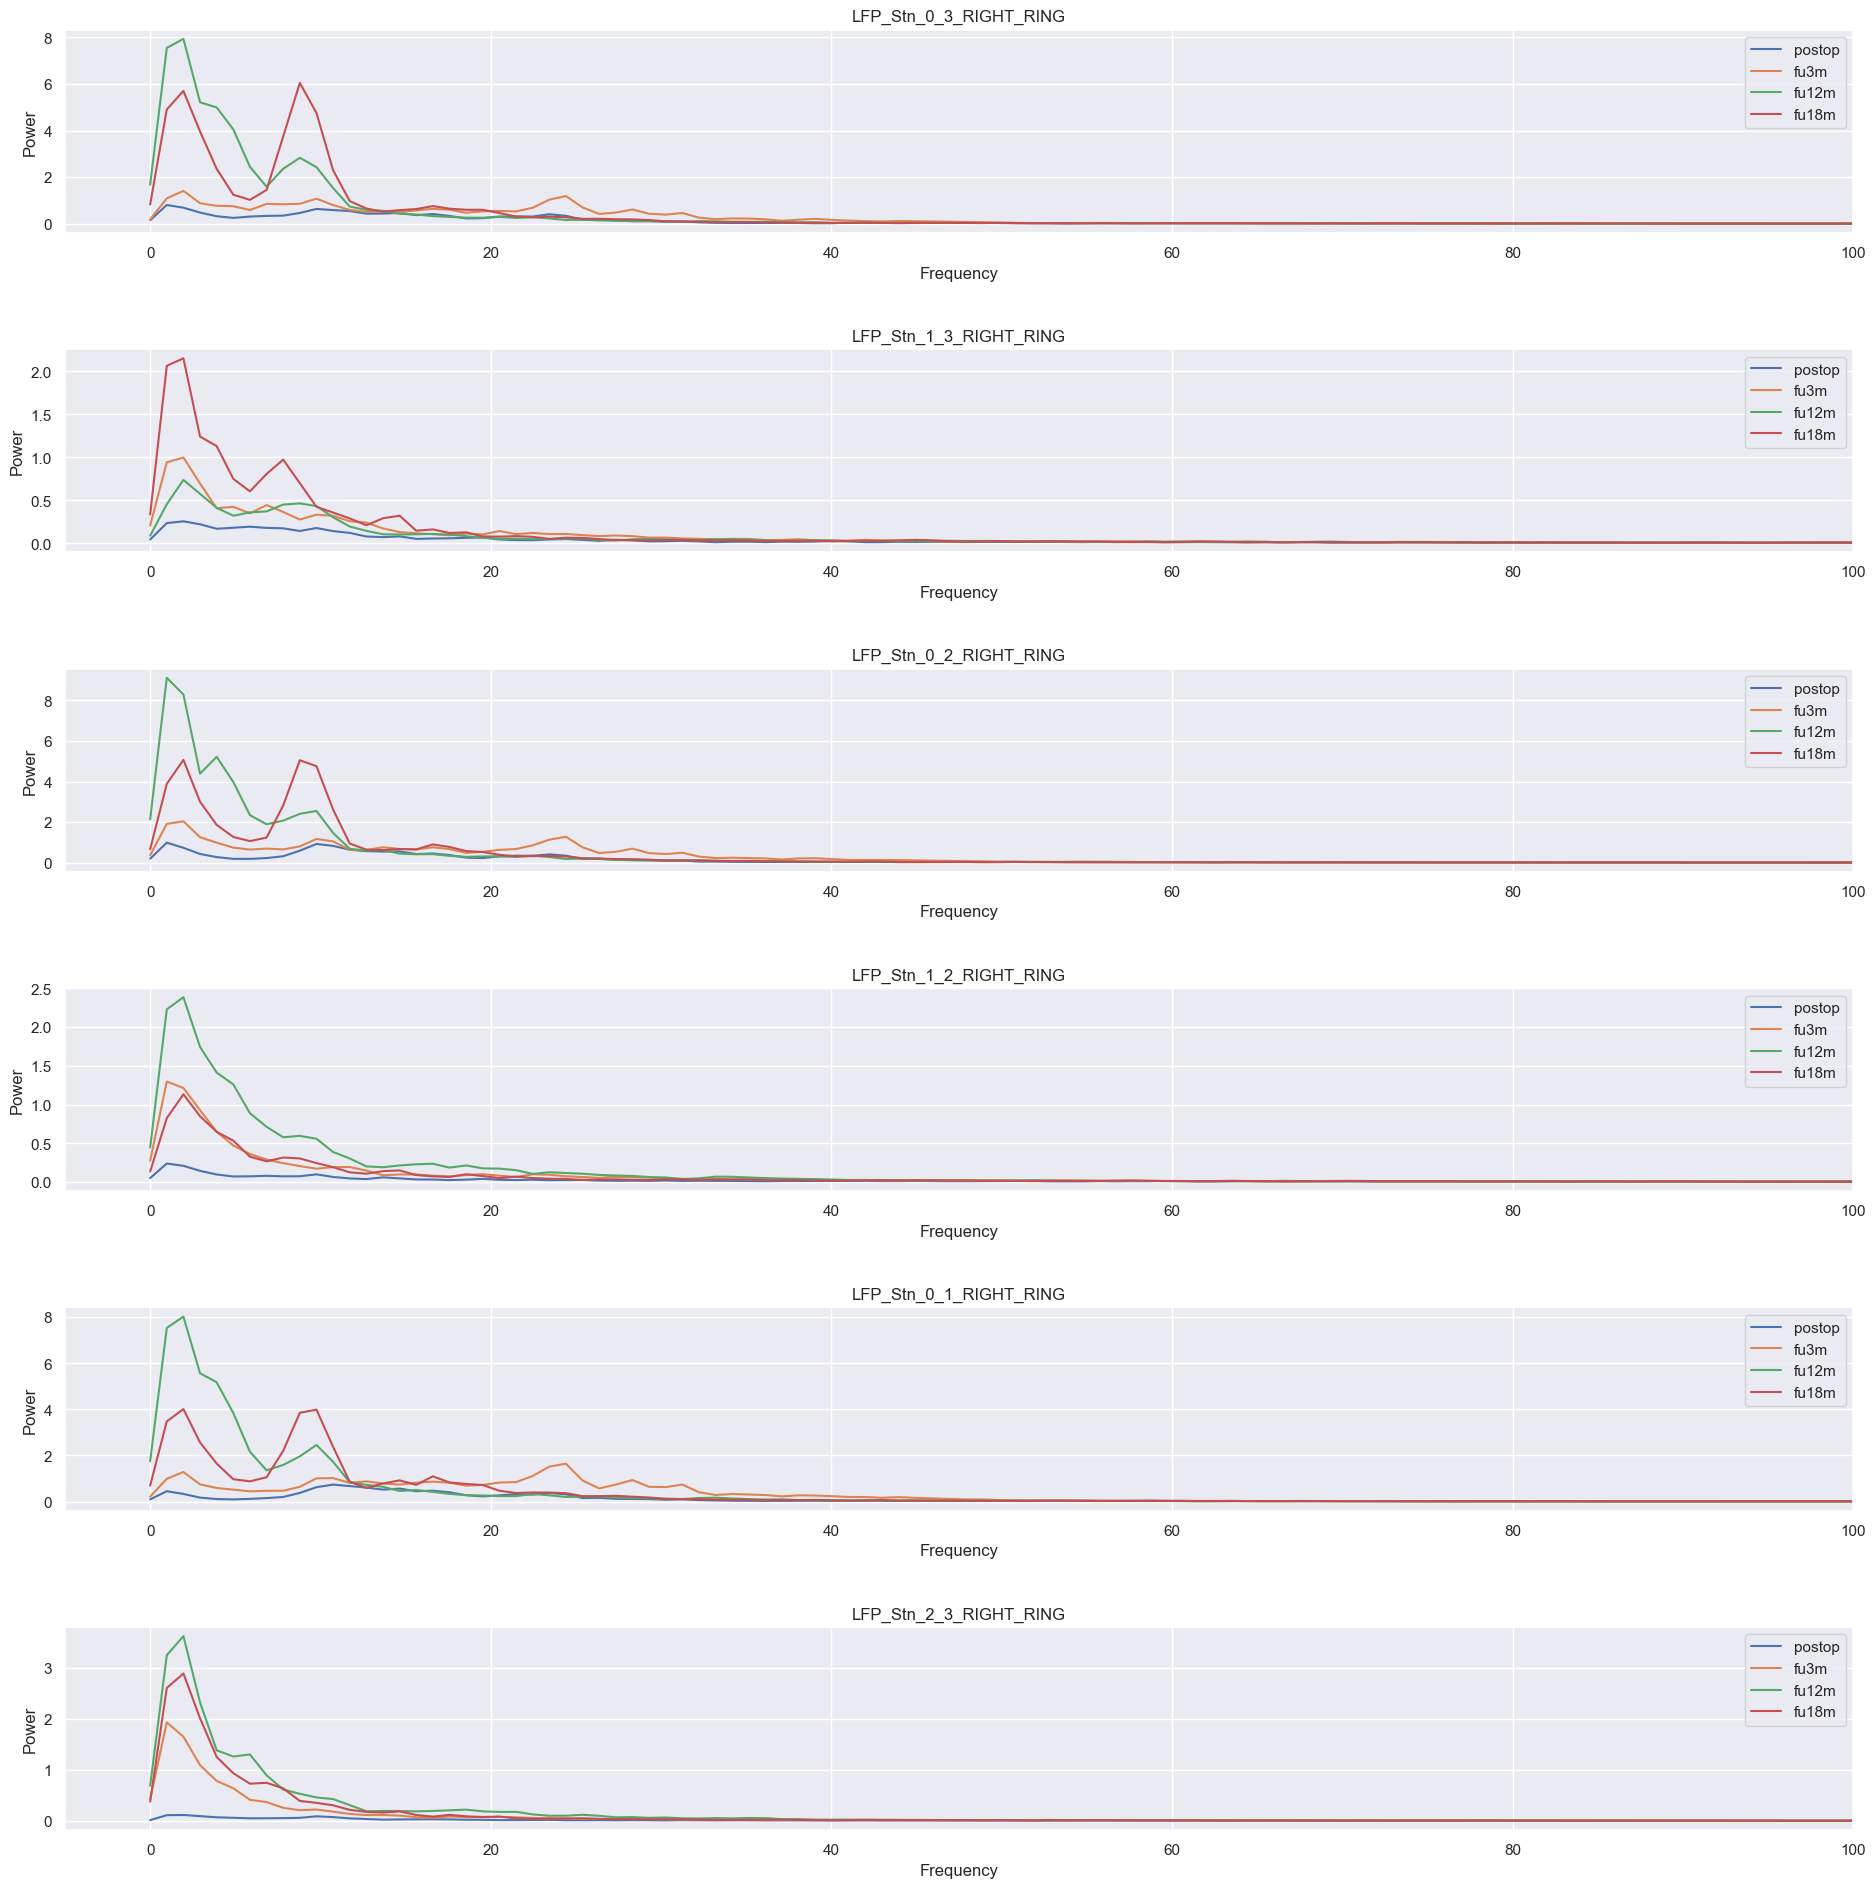

In [19]:
time_points = ['postop', 'fu3m', 'fu12m', 'fu18m']
task_contact = ['RestBSSuRingR'] #, 'RestBSSuSegmInterR', 'RestBSSuSegmIntraR']
# data = data.survey.fu3m.m0s0.rest.data

# create grid for plots: 
# fig = plt.figure() -> figure is an instance of a single container containing all objects representing axes, graphics, text and labels    
# axes = plt.axes() -> axes is a box which will contain the plot

fig, axes = plt.subplots(len(task_ch_names[task_contact[0]].ch_names), 1, figsize=(20, 20)) # rows as many as channels, 1 column
fig.tight_layout(pad=5.0)


for t, tp in enumerate(time_points):

    temp_data = getattr(raw_sub024.survey, tp) # gets attribute e.g. of tp "postop" from modality_class with modality set to survey
    temp_data = temp_data.m0s0.rest.data[task_contact[0]] # gets the mne loaded data from the perceive .mat BSSu, m0s0 file with task "RestBSSuRingR"

    # sample frequency: 250 Hz
    fs = temp_data.info['sfreq']

    # channel names 
    ch_names = temp_data.info.ch_names

    # make a plot for each channel of each timepoint
    for i, ch in enumerate(ch_names):

        # create a signal using welch'method
        # .get_data() gets time series data as an array, [i, :] only gets the row with index i, e.g. index=0 gives time series data of 1st channel "LFP_Stn_R_03"
        f, px = signal.welch(temp_data.get_data()[i, :], fs)  # Returns: f=array of sample frequencies, px= psd or power spectrum of x (amplitude)

        # axes in row number of channel index, all in same column 1
        axes[i].set_title(ch) # the title of each plot is set to the channel e.g. "LFP_Stn_R_03"
        axes[i].plot(f, px, label=tp)
        # axes[i].psd(temp_data.get_data()[i, :], Fs=fs, label=tp,)

for ax in axes: 
    ax.legend() # shows legend for each axes[t]
    ax.set(xlim= (-5, 100), xlabel="Frequency", ylabel="Power") #xlim=(0, 60), ylim=(0, 10)
    # ax.axis([10, 40, -10, 4]) # [xmin, xmax, ymin, ymax]




plt.show() 


    
# for adding subplots use Figure.add_subplot()

### Plotting based on matplotlib and mne

In [11]:
# Matplotlib: set the style
plt.style.use('seaborn-whitegrid')

# "classic"

In [12]:
# used in Python Notebooks
%matplotlib inline 

# %matplotlib inline will lead to static images of your plot embedded within the notebook

In [13]:
# this gets the attribute fu3m from the modality class with modality=survey
sessionclass = getattr(sub024.survey, 'fu3m') 

In [14]:
# the attribute from .data from the task class is a dictionary with keys named after each task. 
data = sessionclass.m0s0.rest.data
data["RestBSSuRingR"].ch_names


['LFP_Stn_R_03',
 'LFP_Stn_R_13',
 'LFP_Stn_R_02',
 'LFP_Stn_R_12',
 'LFP_Stn_R_01',
 'LFP_Stn_R_23']

In [15]:
data = sub024.survey.fu3m.m0s0.rest.data
data

{'RestBSSuRingL': <RawArray | 6 x 5288 (21.1 s), ~259 kB, data loaded>,
 'RestBSSuSegmIntraL': <RawArray | 6 x 5288 (21.1 s), ~259 kB, data loaded>,
 'RestBSSuSegmInterL': <RawArray | 3 x 5250 (21.0 s), ~131 kB, data loaded>,
 'RestBSSuRingR': <RawArray | 6 x 5288 (21.1 s), ~259 kB, data loaded>,
 'RestBSSuSegmIntraR': <RawArray | 6 x 5288 (21.1 s), ~259 kB, data loaded>,
 'RestBSSuSegmInterR': <RawArray | 3 x 5188 (20.7 s), ~130 kB, data loaded>}

Figure of one Hemisphere 
- 3 columns: 'RestBSSuRing', 'RestBSSuSegmInter', RestBSSuSegmIntra'
- rows: number of channels (3 or 6)
- Plot per channel: PSD of each session timepoint

In [104]:


# time_points = ['postop', 'fu3m', 'fu12m', 'fu18m']
# task_contact = ['RestBSSuRingR', 'RestBSSuSegmInterR']

# # create grid for plots: 
# # fig = plt.figure() -> figure is an instance of a single container containing all objects representing axes, graphics, text and labels    
# # axes = plt.axes() -> axes is a box which will contain the plot
# for tk, task in enumerate(task_contact):

#     fig, axes = plt.subplots(len(data[task_contact[tk]].ch_names), 1, figsize=(20, 20)) # rows as many as channels, 1 column
#     fig.tight_layout(pad=5.0)


#     for t, tp in enumerate(time_points):

#         temp_data = getattr(sub024.survey, tp) # gets attribute e.g. of tp "postop" from modality_class with modality set to survey
#         temp_data = temp_data.m0s0.rest.data[task_contact[tk]] # gets the mne loaded data from the perceive .mat BSSu, m0s0 file with task "RestBSSuRingR"

#         # sample frequency: 250 Hz
#         fs = temp_data.info['sfreq']

#         # channel names 
#         ch_names = temp_data.info.ch_names

#         # make a plot for each channel of each timepoint
#         for i, ch in enumerate(ch_names):

#             # create a signal using welch'method
#             # .get_data() gets time series data as an array, [i, :] only gets the row with index i, e.g. index=0 gives time series data of 1st channel "LFP_Stn_R_03"
#             f, px = signal.welch(temp_data.get_data()[i, :], fs)  # Returns: f=array of sample frequencies, px= psd or power spectrum of x (amplitude)

#             # axes in row number of channel index, and column number of task index
#             axes[i].set_title(ch) # the title of each plot is set to the channel e.g. "LFP_Stn_R_03"
#             axes[i].plot(f, px, label=tp)
#             # axes[i].psd(temp_data.get_data()[i, :], Fs=fs, label=tp,)

# for ax in axes: 
#     ax.legend() # shows legend for each axes[t]
#     ax.set(xlim= (-5, 100), xlabel="Frequency", ylabel="Power") #xlim=(0, 60), ylim=(0, 10)
#     # ax.axis([10, 40, -10, 4]) # [xmin, xmax, ymin, ymax]




# plt.show() 


    
# for adding subplots use Figure.add_subplot()

Plot PSD of each channel seperately over time
- no filter
- 15 channels per hemisphere 
- per channel 3 session timepoints ('postop', 'fu3m', 'fu12m')

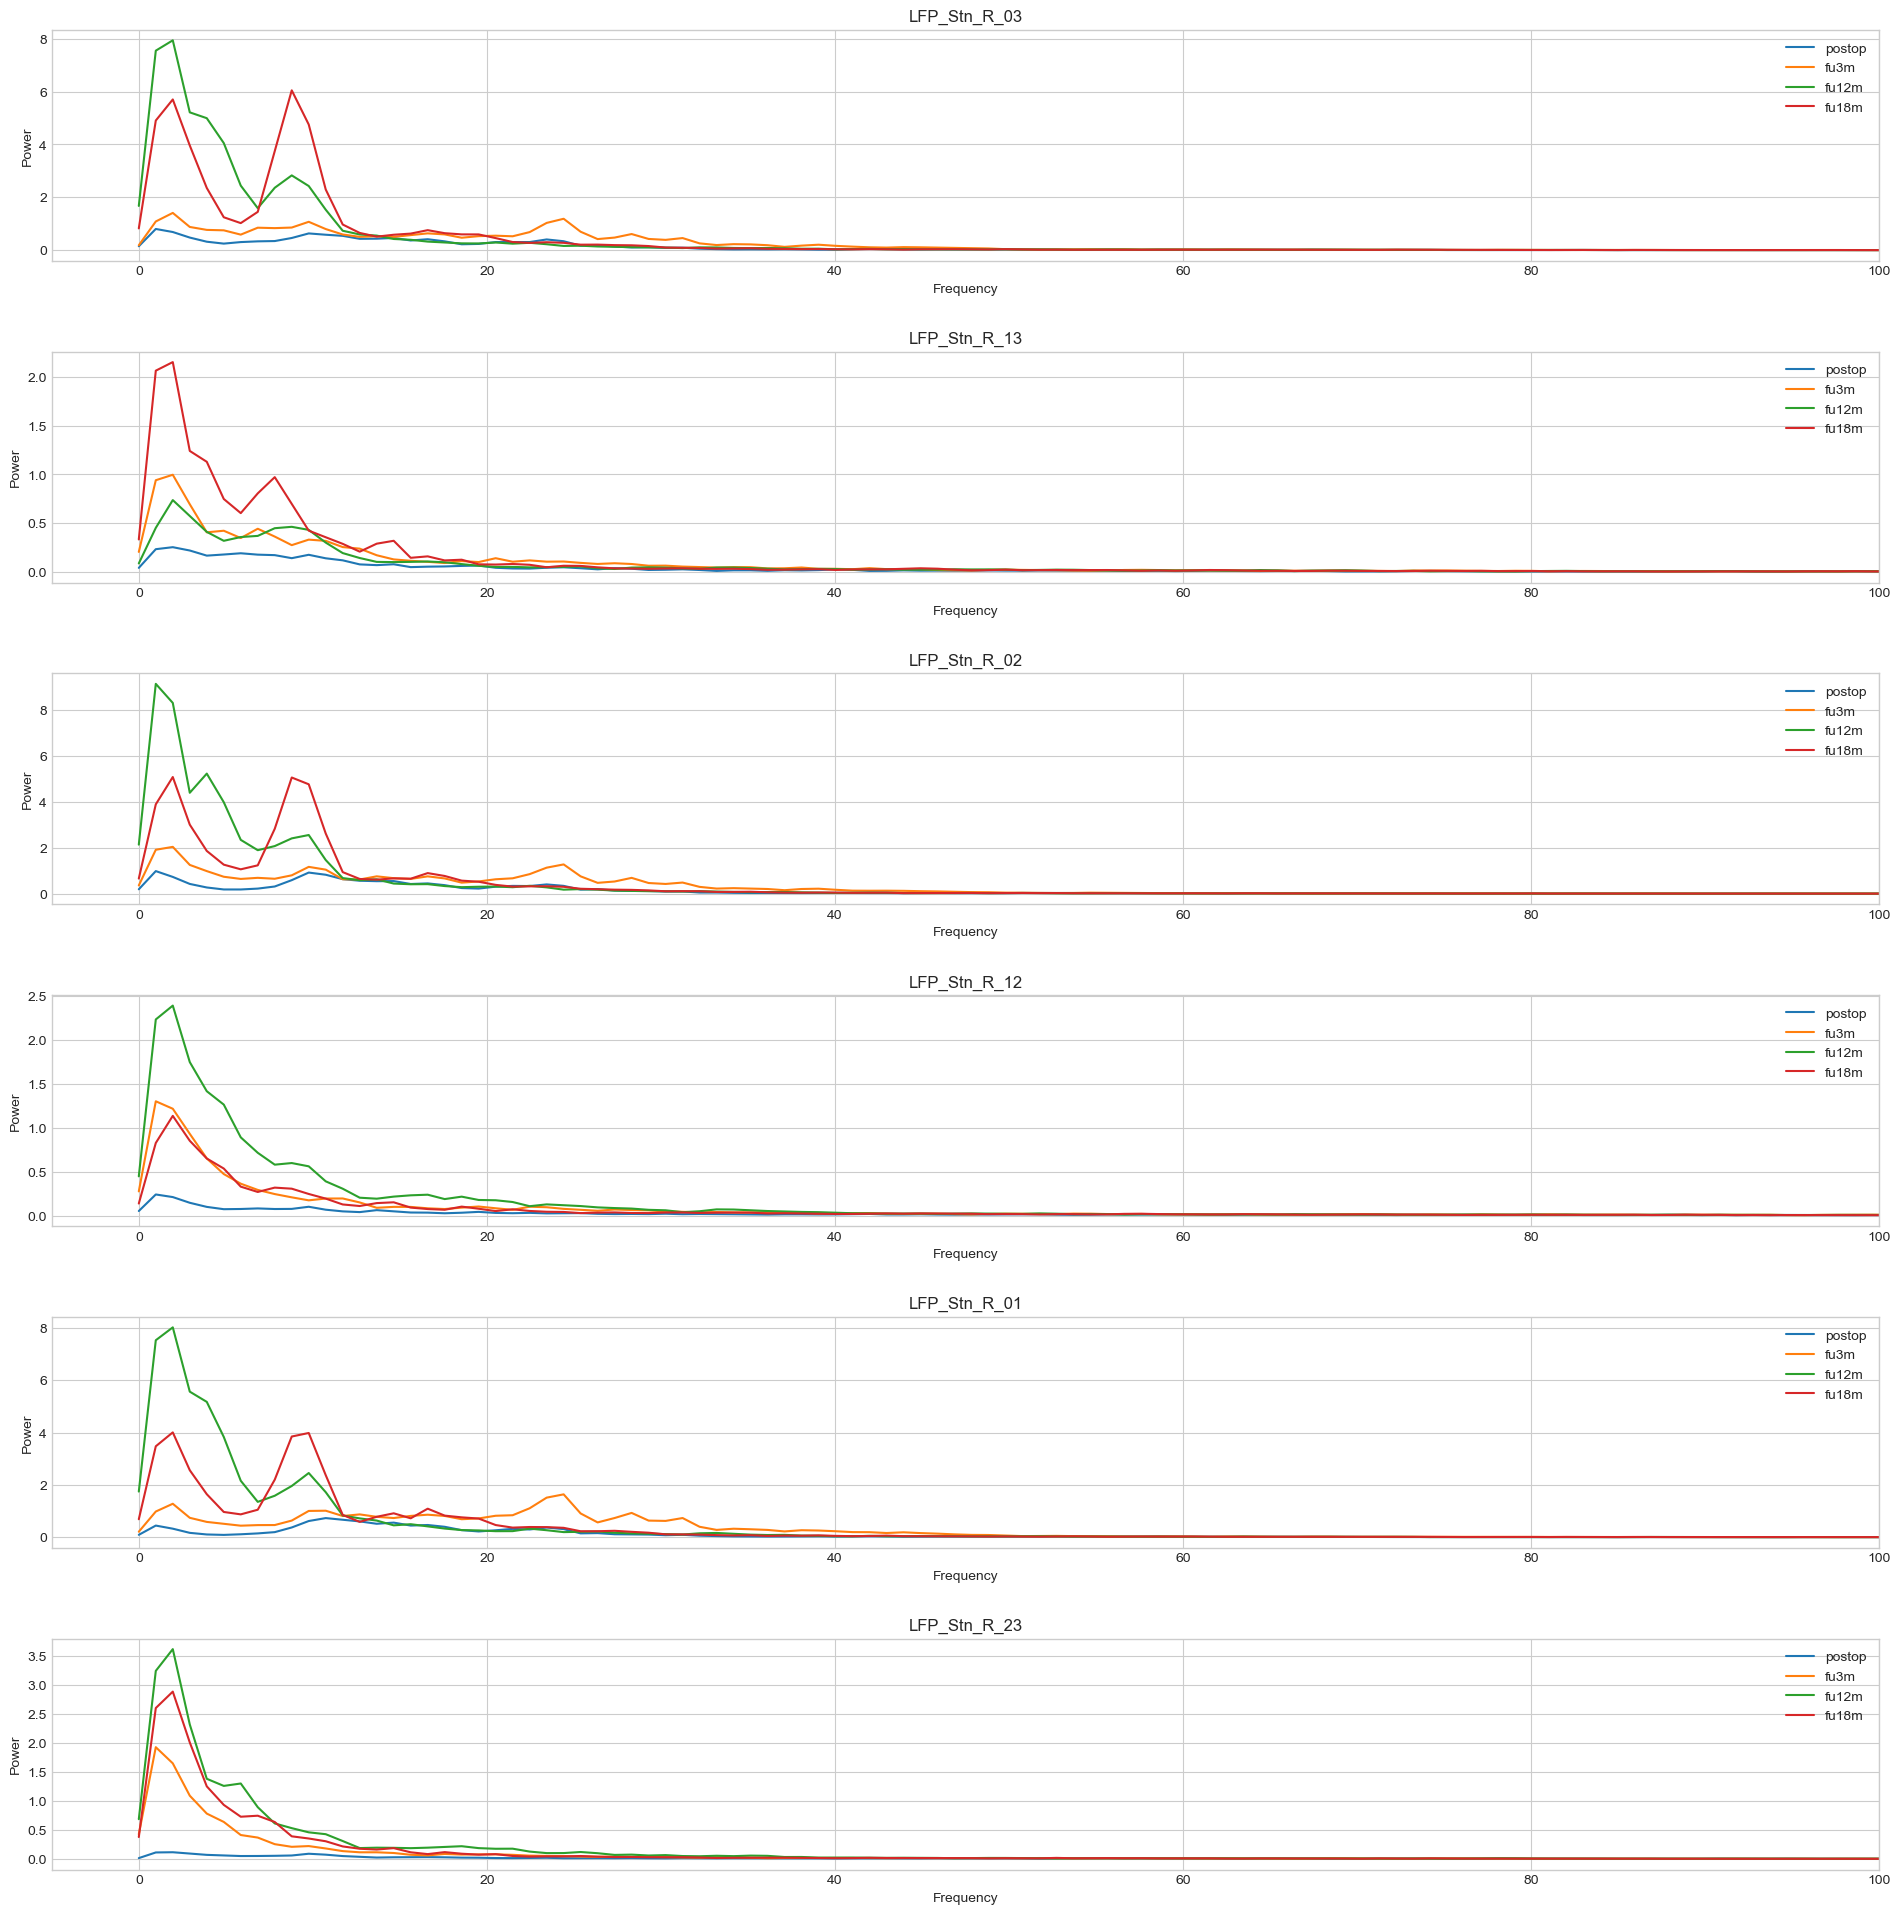

In [26]:

time_points = ['postop', 'fu3m', 'fu12m', 'fu18m']
task_contact = ['RestBSSuRingR', 'RestBSSuSegmInterR', 'RestBSSuSegmIntraR']
data = data = sub024.survey.fu3m.m0s0.rest.data

# create grid for plots: 
# fig = plt.figure() -> figure is an instance of a single container containing all objects representing axes, graphics, text and labels    
# axes = plt.axes() -> axes is a box which will contain the plot

fig, axes = plt.subplots(len(data[task_contact[0]].ch_names), 1, figsize=(20, 20)) # rows as many as channels, 1 column
fig.tight_layout(pad=5.0)


for t, tp in enumerate(time_points):

    temp_data = getattr(sub024.survey, tp) # gets attribute e.g. of tp "postop" from modality_class with modality set to survey
    temp_data = temp_data.m0s0.rest.data[task_contact[0]] # gets the mne loaded data from the perceive .mat BSSu, m0s0 file with task "RestBSSuRingR"

    # sample frequency: 250 Hz
    fs = temp_data.info['sfreq']

    # channel names 
    ch_names = temp_data.info.ch_names

    # make a plot for each channel of each timepoint
    for i, ch in enumerate(ch_names):

        # create a signal using welch'method
        # .get_data() gets time series data as an array, [i, :] only gets the row with index i, e.g. index=0 gives time series data of 1st channel "LFP_Stn_R_03"
        f, px = signal.welch(temp_data.get_data()[i, :], fs)  # Returns: f=array of sample frequencies, px= psd or power spectrum of x (amplitude)

        # axes in row number of channel index, all in same column 1
        axes[i].set_title(ch) # the title of each plot is set to the channel e.g. "LFP_Stn_R_03"
        axes[i].plot(f, px, label=tp)
        # axes[i].psd(temp_data.get_data()[i, :], Fs=fs, label=tp,)

for ax in axes: 
    ax.legend() # shows legend for each axes[t]
    ax.set(xlim= (-5, 100), xlabel="Frequency", ylabel="Power") #xlim=(0, 60), ylim=(0, 10)
    # ax.axis([10, 40, -10, 4]) # [xmin, xmax, ymin, ymax]




plt.show() 


    
# for adding subplots use Figure.add_subplot()

In [28]:

np.array([3,4,5,15,16,17,25,27,60])


array([ 3,  4,  5, 15, 16, 17, 25, 27, 60])

In [29]:
peak_pos = np.array([3,4,5,15,16,17,25,27,60])

listx =[]
x_range = np.arange(10, 36)
for x in peak_pos:
    if x in x_range:
        x_peak_pos = np.array(listx.append(x))

print(x_peak_pos)

None


Try out find_peaks() function from scipy.signal

In [16]:
y = [2,3,4]
y.index(2)

0

13.081612838133548 [3.73737374]


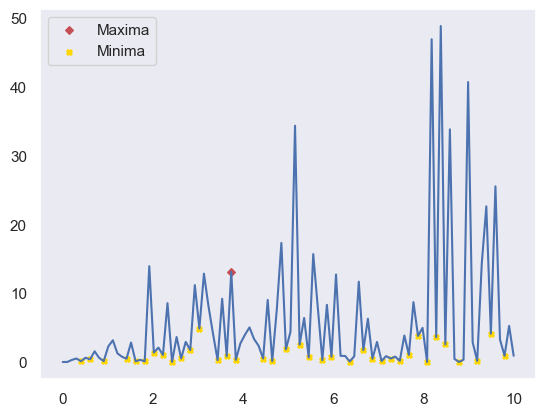

array([15, 19, 23, 25, 27, 29, 31, 35, 37, 41, 45, 48, 51, 53, 55, 58, 60,
       65, 67, 69, 75, 77, 79, 81, 83, 85, 89, 93, 95, 98], dtype=int64)

In [110]:
x = np.linspace(0,10, 100)
y = x*np.random.randn(100)**2
betarange= np.arange(2,6)


# Finding maxima
peaks = signal.find_peaks(y, height = 1, threshold = 1, distance = 1)
height = peaks[1]['peak_heights'] #list of the heights of the peaks
peak_pos = x[peaks[0]] #list of the peaks positions

# Select the peaks within the x-range of 2 to 4
peak_boolean_xrange = (peak_pos >= 2) & (peak_pos <= 4) # set the x-range 
peaksinrange_x = peak_pos[peak_boolean_xrange]
peaksinrange_y = height[peak_boolean_xrange]

# select only the highest peak among those peaks
highest_peakinrange_y = peaksinrange_y.max()

# get the index of the highest peak y value from the np.array with all peaks in the chosen range (peaksinrange_y)
index = np.where(peaksinrange_y == highest_peakinrange_y)
highest_peakinrange_x = peaksinrange_x[index]

print(highest_peakinrange_y, highest_peakinrange_x)

#Finding the minima
y2 = y*-1
minima = signal.find_peaks(y2)
min_pos = x[minima[0]] #list of the minima positions
min_height = y2[minima[0]] #list of the mirrored minima heights

#Plotting
fig = plt.figure()
ax = fig.subplots()
ax.plot(x,y)
ax.scatter(highest_peakinrange_x, highest_peakinrange_y, color = 'r', s = 15, marker = 'D', label = 'Maxima')
ax.scatter(min_pos, min_height*-1, color = 'gold', s = 15, marker = 'X', label = 'Minima')
ax.legend()
ax.grid()
plt.show()

peaks[0]

For each session timepoints plot PSD from every channel of one hemisphere:
- no filter applied 
- transform time series data to frequency domain and calculate estimated PSD using Welch´s method

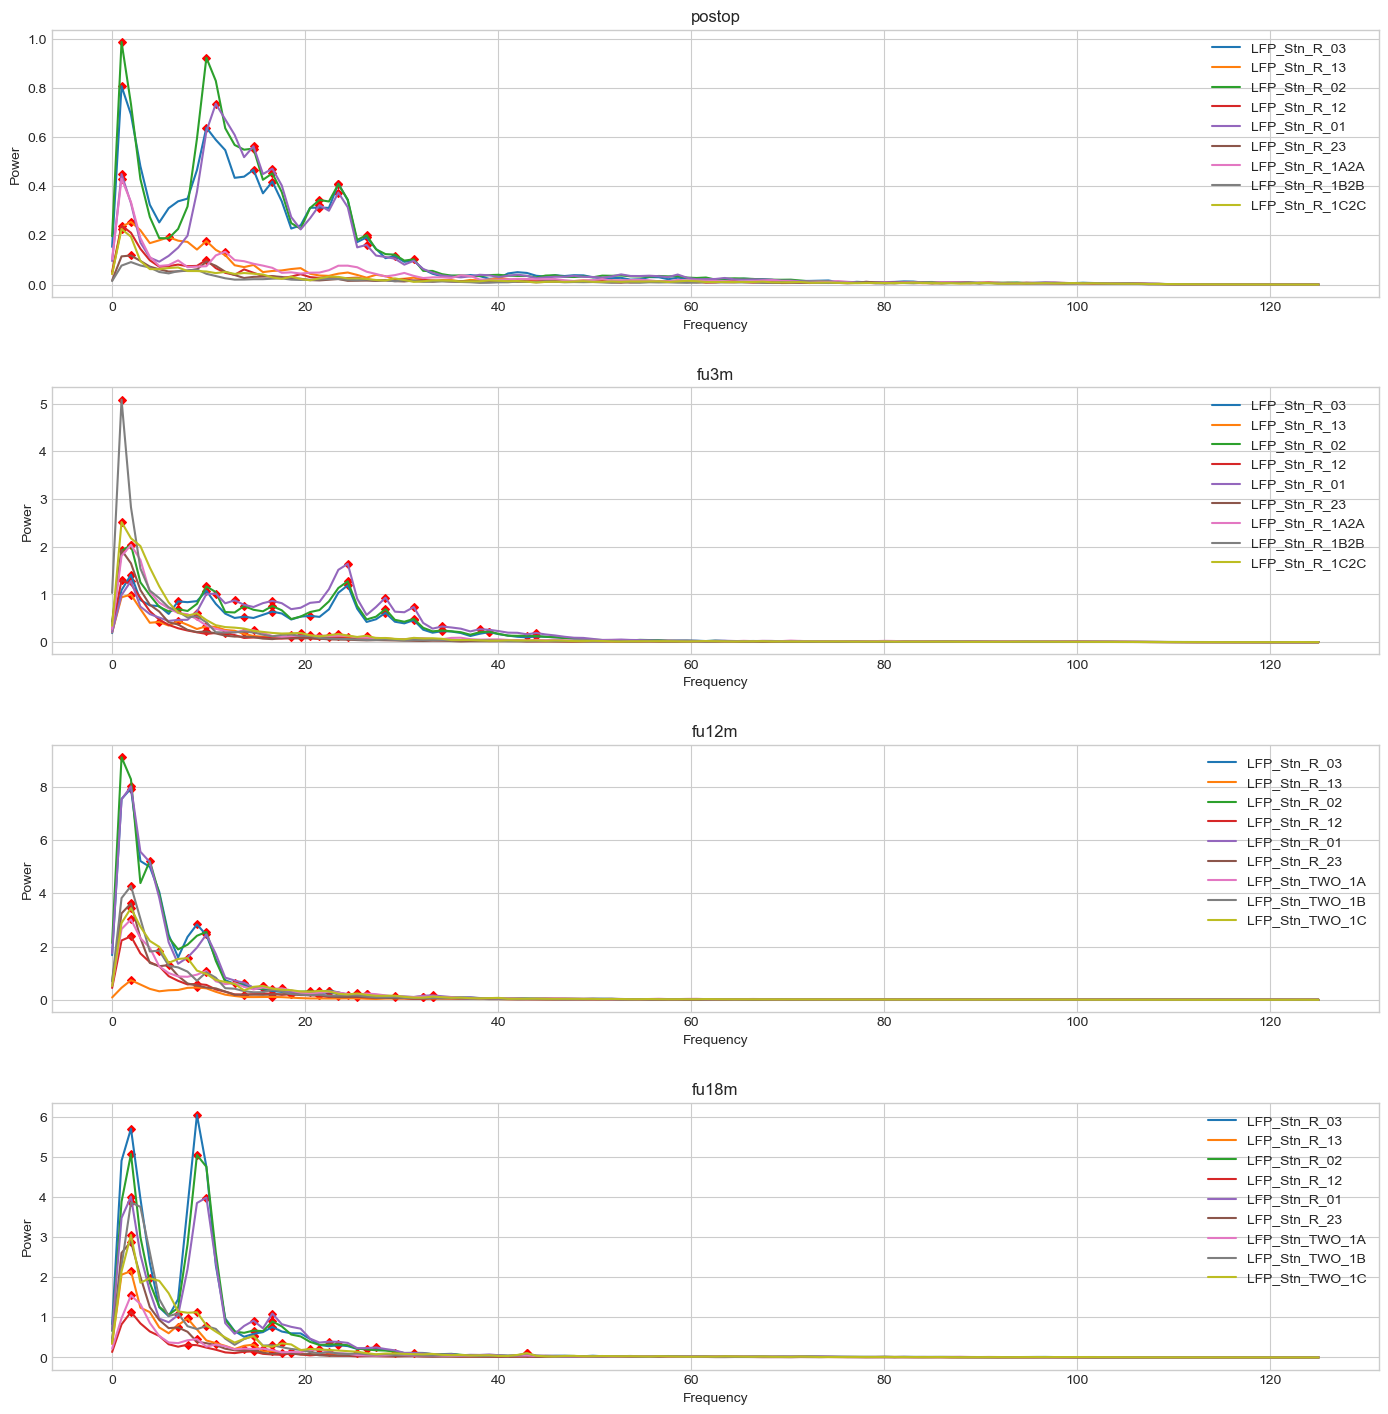

array([ 2,  4,  9, 15, 18, 21, 30, 44], dtype=int64)

In [49]:
time_points = ['postop', 'fu3m', 'fu12m', 'fu18m']
tasks_right = ['RestBSSuRingR', 'RestBSSuSegmInterR']
tasks_left = ['RestBSSuRingL', 'RestBSSuSegmInterL']

# add KeyError exception if task doesn´t exist in loaded data 

# set layout for figures: using the object-oriented interface
fig, axes = plt.subplots(len(time_points), 1, figsize=(15, 15)) # subplot(rows, columns, panel number)
fig.tight_layout(pad=5.0)

for t, tp in enumerate(time_points):

    for tk, task in enumerate(tasks_right): 

        # apply loop over channels
        temp_data = getattr(sub024.survey, tp) # gets attribute e.g. of tp "postop" from modality_class with modality set to survey
        temp_data = temp_data.m0s0.rest.data[tasks_right[tk]] # gets the mne loaded data from the perceive .mat BSSu, m0s0 file with task "RestBSSuRingR"

        # sample frequency: 250 Hz
        fs = temp_data.info['sfreq'] 

        # the title of each plot is set to the timepoint e.g. "postop"
        axes[t].set_title(tp)  

        # create signal per channel with Welch´s method and plot
        for i, ch in enumerate(temp_data.info.ch_names):

            # transform time series data into power spectral density using Welch
            # .get_data() gets time series data as an array, [i, :] only gets the row with index i 
            f, px = signal.welch(temp_data.get_data()[i, :], fs)  # Returns: f=array of sample frequencies, px= psd or power spectrum of x (amplitude)
            # density unit: V**2/Hz
            
            # find peaks: peaks is a tuple -> peaks[0] = index of frequency?, peaks[1] = dictionary with keys("peaks_height") 
            peaks = signal.find_peaks(px, height=0.1) # height: peaks only above 0.1 will be recognized
            peaks_height = peaks[1]["peak_heights"] # arraw of y-value of peaks = power
            peaks_pos = f[peaks[0]] # array of indeces on x-axis of peaks = frequency

            # .plot() method for creating the plot, axes[0] refers to the first plot, the plot is set on the appropriate object axes[t]
            axes[t].plot(f, px, label=ch)  # or np.log10(px)
            axes[t].scatter(peaks_pos, peaks_height, color='r', s=15, marker='D')


            # calculate and plot power spectrum per channel in same plot of timepoint

for ax in axes: 
    ax.legend() # shows legend for each axes[t]
    ax.set(xlabel="Frequency", ylabel="Power")
    # ax.set(xlim=(10, 40), ylim=(-10, 4), xlabel="Frequency", ylabel="log10 Power")

plt.show() # always needed to visualize the plot, in a .py file, use plt.show() only once and at the very end of the file -> it will plot all figures of the script

peaks[0]

### Create filter

In [25]:
# signal of first channel from sub024 BSSu M0S0 Right Ring
raw = sub024.survey.fu3m.m0s0.rest.data["RestBSSuRingR"]
raw_ch1 = raw.get_data()[0,:]
raw_ch1

array([ 4.38087613,  1.01097142,  0.44932063, ..., -5.39184755,
       -2.02194283,  2.3589333 ])

In [32]:
fs = raw.info["sfreq"]
fs

250.0

Create bandpass filter

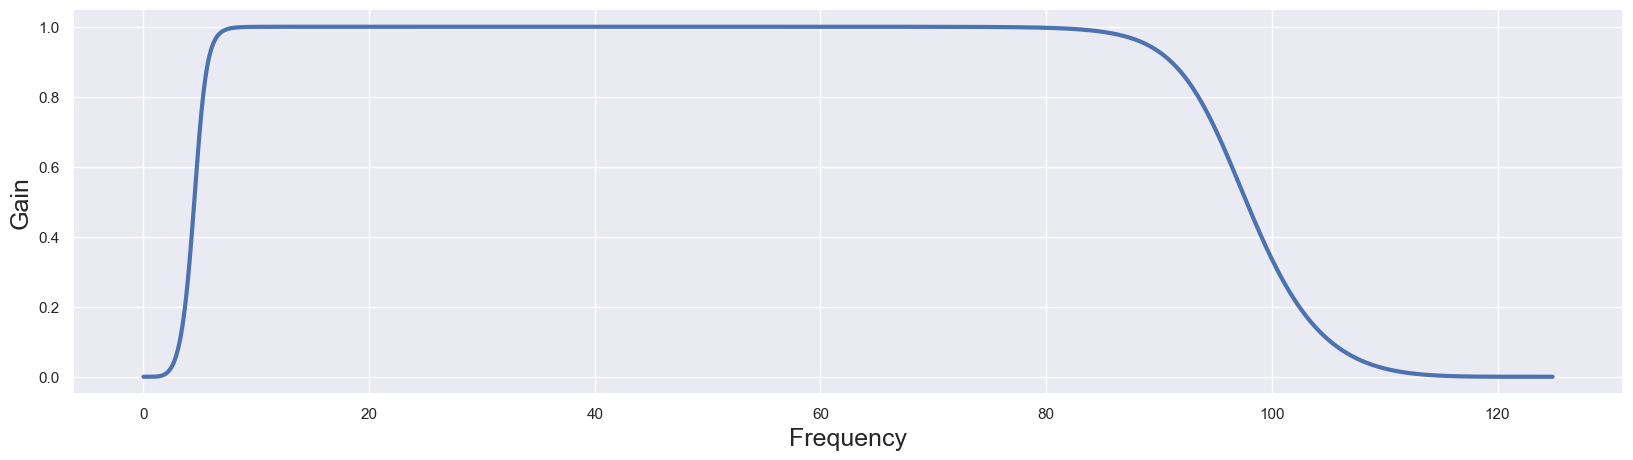

In [33]:
from scipy.signal import butter, filtfilt, freqz

filter_order = 5 # sharpness of the filter, in MATLAB spm_eeg_filter default=5 Butterworth, used in wjn_filter
frequency_cutoff_low = 5
frequency_cutoff_high = 95
sampling_frequency = 250

# Create the filter
b, a = butter(filter_order, (frequency_cutoff_low, frequency_cutoff_high), btype='bandpass', output='ba', fs=sampling_frequency)

def rad_sample_to_hz(x, fs):
    return (x*fs)/(2*np.pi)

def plot_filter(b, a, fs):
    plt.figure(figsize=(20,5))
    w, h = freqz(b, a, worN=512*2, whole=False)
    plt.plot(rad_sample_to_hz(w, fs), abs(h), linewidth=3)
    plt.ylabel('Gain', fontsize=18)
    plt.xlabel('Frequency', fontsize=18)
    
plot_filter(b, a, sampling_frequency)

Apply bandpass filter to time series data

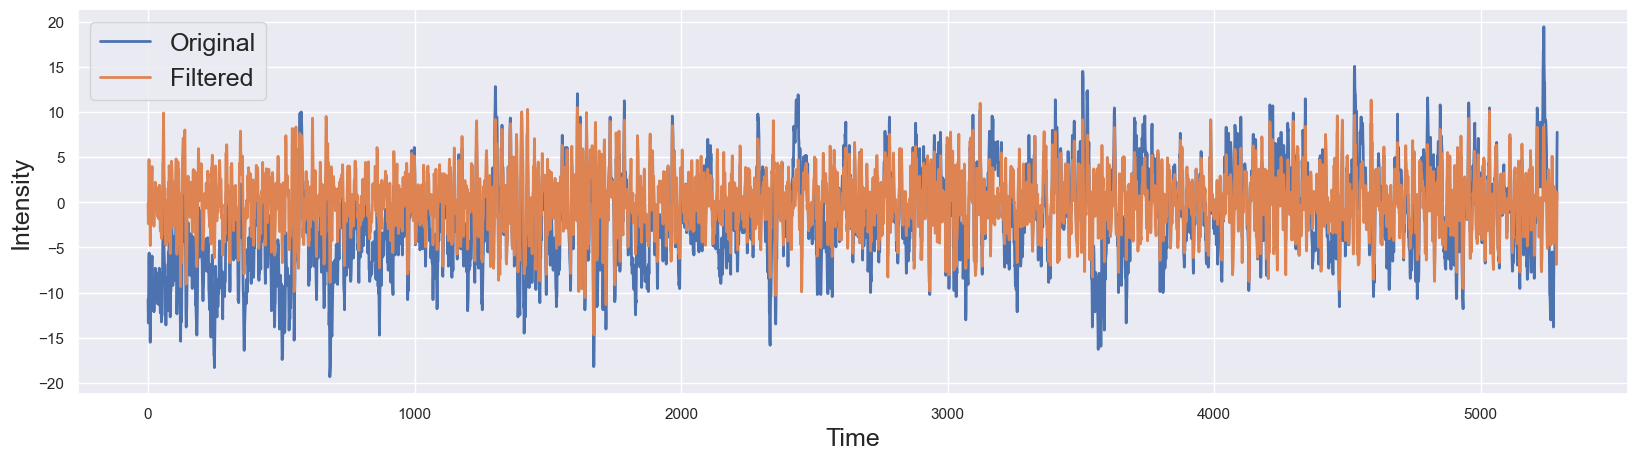

In [34]:
# apply band-pass filter to time-domain
data=sub024.survey.fu3m.m0s0.rest.data['RestBSSuRingL'].get_data() # data of all channels in RingR
chan_signal=data[0]

filtered = signal.filtfilt(b, a, chan_signal)

plt.figure(figsize=(20,5))
plt.plot(chan_signal, linewidth=2)
plt.plot(filtered, linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

High-Pass Filter

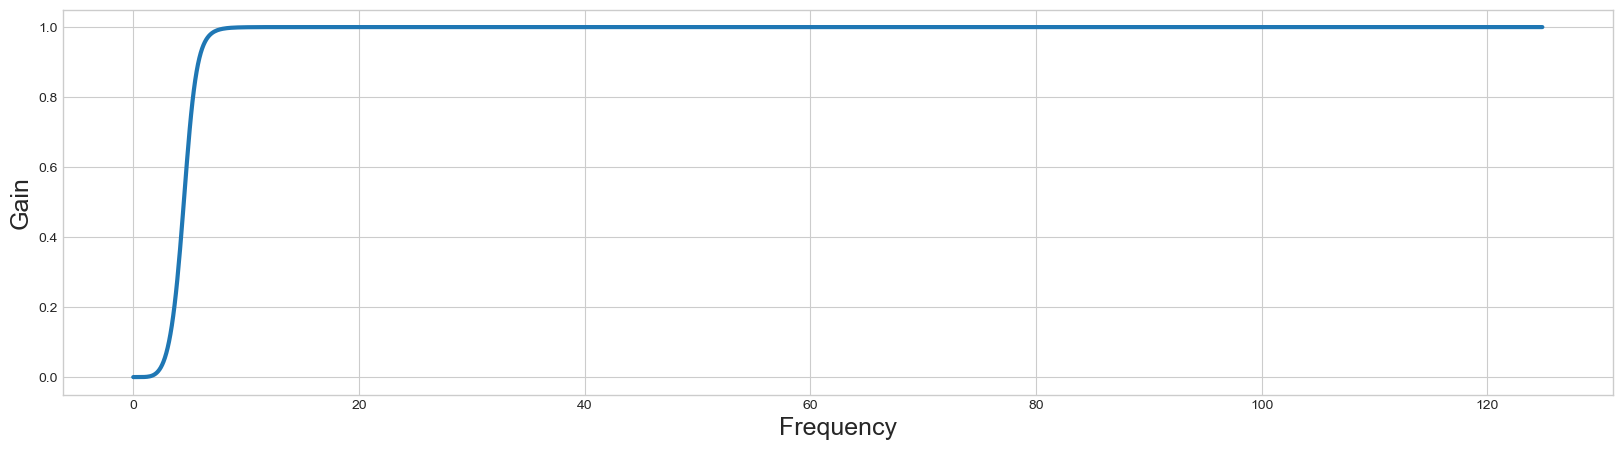

In [18]:
# create high-pass filter


from scipy.signal import butter, filtfilt, freqz

filter_order = 5 # sharpness of the filter, in MATLAB spm_eeg_filter default=5 Butterworth, used in wjn_filter
frequency_cutoff = 5
sampling_frequency = 250

# Create the filter
b, a = butter(filter_order, frequency_cutoff, btype='high', output='ba', fs=sampling_frequency)

def rad_sample_to_hz(x, fs):
    return (x*fs)/(2*np.pi)

def plot_filter(b, a, fs):
    plt.figure(figsize=(20,5))
    w, h = freqz(b, a, worN=512*2, whole=False)
    plt.plot(rad_sample_to_hz(w, fs), abs(h), linewidth=3)
    plt.ylabel('Gain', fontsize=18)
    plt.xlabel('Frequency', fontsize=18)
    
plot_filter(b, a, sampling_frequency)

Apply high-pass filter to time-series data 

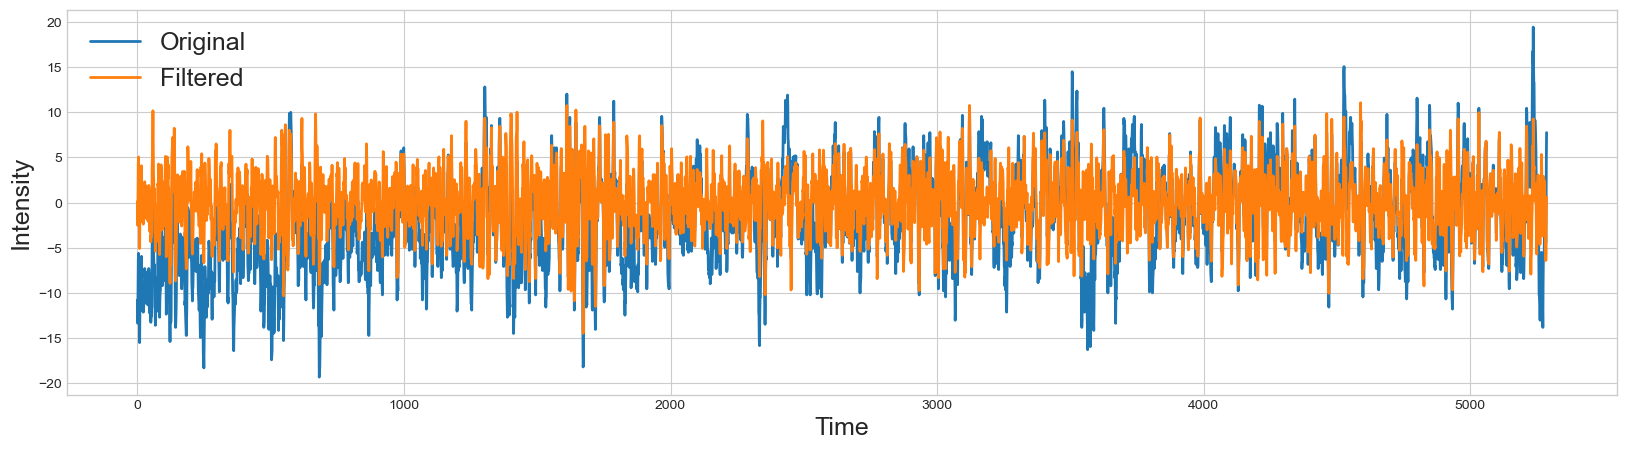

In [19]:
# apply high-pass filter to time-domain
data=sub024.survey.fu3m.m0s0.rest.data['RestBSSuRingL'].get_data() # data of all channels in RingR
chan_signal=data[0]

filtered = signal.filtfilt(b, a, chan_signal)

plt.figure(figsize=(20,5))
plt.plot(chan_signal, linewidth=2)
plt.plot(filtered, linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

High-pass filtered time-series data:
- filter: High-pass filter of 5Hz, Butterworth filter, filter-order=5
- Using Welch´s method to calculate spectral density estimation
- plotting with the matplotlib.plot() function
- Plotting PSD of every channel per session timepoint

In [72]:
# import seaborn and plot with seaborn
import seaborn as sns
sns.set()

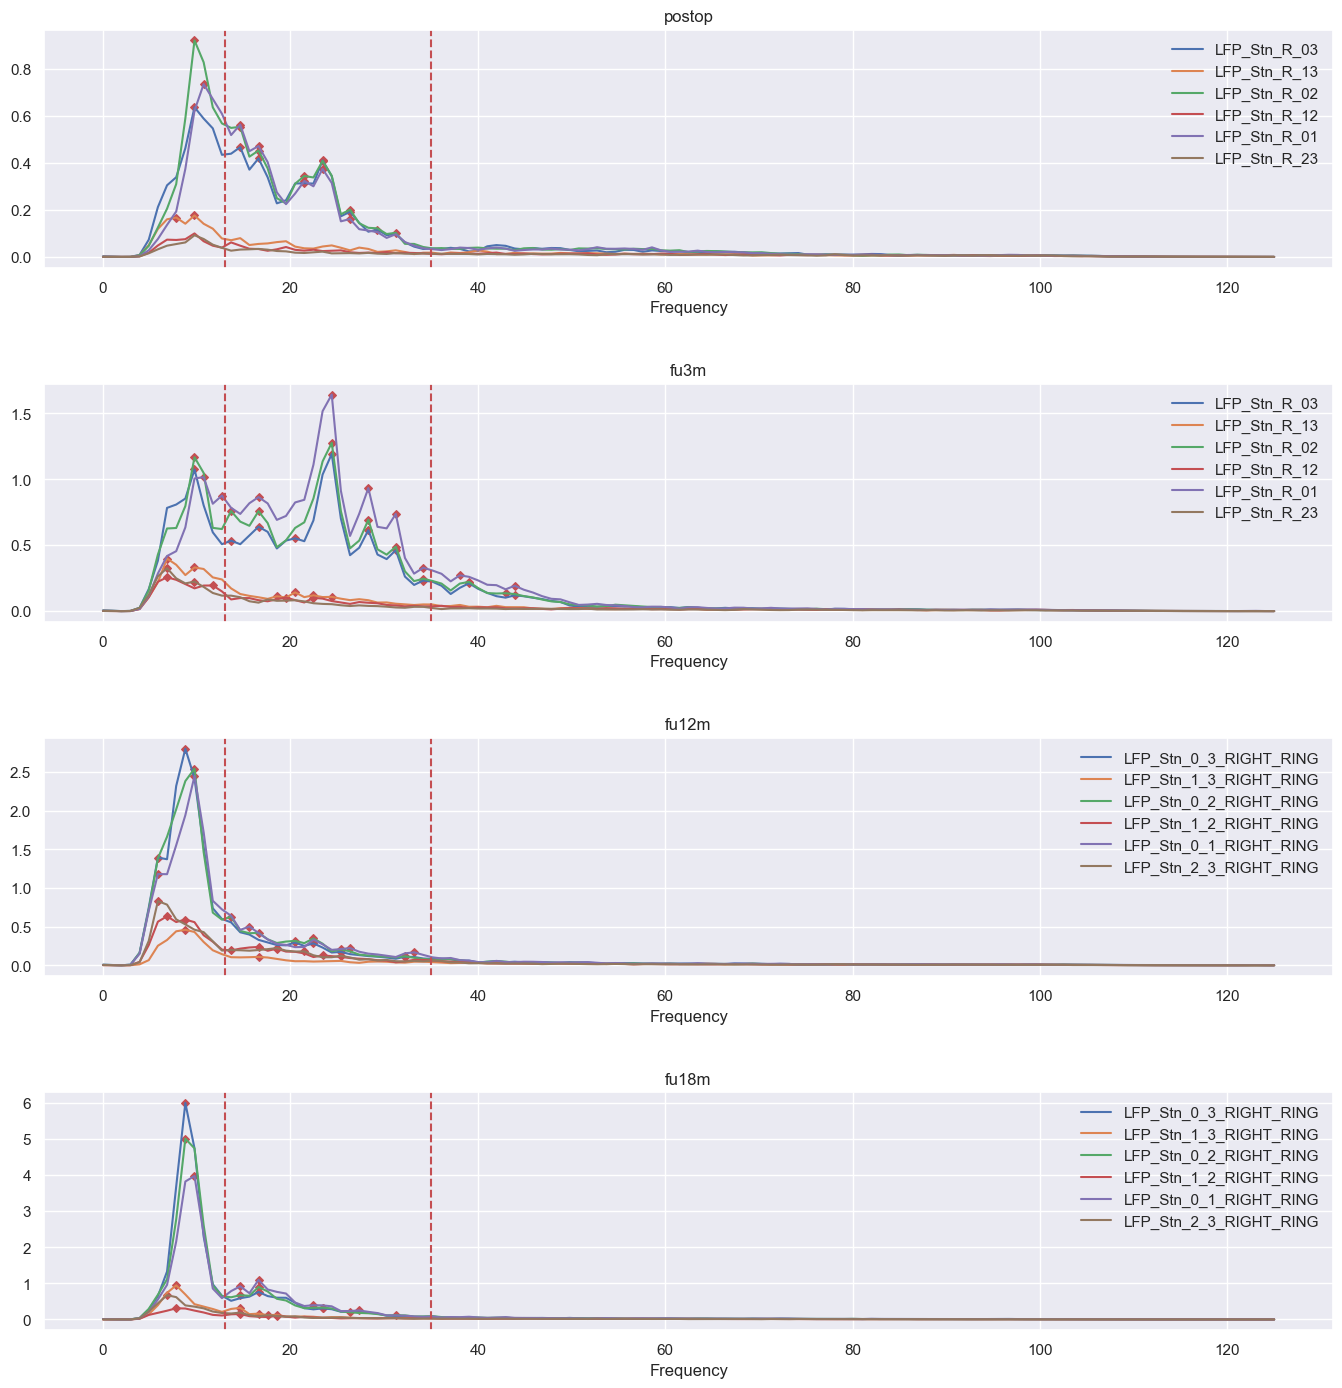

In [59]:


time_points = ['postop', 'fu3m', 'fu12m', 'fu18m']
tasks_right = ['RestBSSuRingR'] #, 'RestBSSuSegmInterR', 'RestBSSuSegmIntraR']
tasks_left = ['RestBSSuRingL', 'RestBSSuSegmInterL', 'RestBSSuSegmIntraL']
f_psd_dict = {}


# set layout for figures: using the object-oriented interface
fig, axes = plt.subplots(len(time_points), 1, figsize=(15, 15)) # subplot(rows, columns, panel number)
fig.tight_layout(pad=5.0)

for t, tp in enumerate(time_points):

    for tk, task in enumerate(tasks_right): 

        # apply loop over channels
        temp_data = getattr(sub024.survey, tp) # gets attribute e.g. of tp "postop" from modality_class with modality set to survey
        temp_data = temp_data.m0s0.rest.data[tasks_right[tk]] # gets the mne loaded data from the perceive .mat BSSu, m0s0 file with task "RestBSSuRingR"

        # sample frequency: 250 Hz
        fs = temp_data.info['sfreq'] 

        # set filter parameters for high-pass filter
        filter_order = 5 # in MATLAB spm_eeg_filter default=5 Butterworth
        frequency_cutoff = 5 # 5Hz high-pass filter

        # create the filter
        b, a = signal.butter(filter_order, frequency_cutoff, btype='high', output='ba', fs=fs)

        # the title of each plot is set to the timepoint e.g. "postop"
        axes[t].set_title(tp)  

        # create signal per channel with Welch´s method and plot
        for i, ch in enumerate(temp_data.info.ch_names):
            
            # create the filtered signal
            filtered = signal.filtfilt(b, a, temp_data.get_data()[i, :])

            # transform the filtered time series data into power spectral density using Welch
            f, px = signal.welch(filtered, fs)  # Returns: f=array of sample frequencies, px= psd or power spectrum of x (amplitude)
            # density unit: V**2/Hz

            # store frequency and psd values in new dictionary
            f_psd_dict[f'{tp}_{ch}'] = [f, px]

            # normalize psd
            # normalized_px = px - np.mean(px)
            # normalized_px = normalized_px/np.std(normalized_px)

            # get y-axis label and limits
            axes[t].get_ylabel()
            axes[t].get_ylim()

            # add errorbars
            # axes[t].errorbar(f, px, yerr=0.8, fmt='.k', color='lightgrey', ecolor='lightgrey')


            # find peaks: peaks is a tuple -> peaks[0] = index of frequency?, peaks[1] = dictionary with keys("peaks_height") 
            peaks = signal.find_peaks(px, height=0.1) # height: peaks only above 0.1 will be recognized
            peaks_height = peaks[1]["peak_heights"] # arraw of y-value of peaks = power
            peaks_pos = f[peaks[0]] # array of indeces on x-axis of peaks = frequency

            # .plot() method for creating the plot, axes[0] refers to the first plot, the plot is set on the appropriate object axes[t]
            axes[t].plot(f, px, label=ch)  # or np.log10(px)
            axes[t].scatter(peaks_pos, peaks_height, color='r', s=15, marker='D')


            # calculate and plot power spectrum per channel in same plot of timepoint

for ax in axes: 
    ax.legend() # shows legend for each axes[t]
    ax.set(xlabel="Frequency")
    ax.axvline(x=13, color='r', linestyle='--')
    ax.axvline(x=35, color='r', linestyle='--')
    # ax.set(xlim=(10, 40), ylim=(-10, 4), xlabel="Frequency", ylabel="log10 Power")

plt.show() # always needed to visualize the plot, in a .py file, use plt.show() only once and at the very end of the file -> it will plot all figures of the script


In [47]:
f_psd_dict['postop_LFP_Stn_R_03'][1]

array([1.67671288e-03, 7.77459431e-04, 6.89403314e-06, 3.01001940e-04,
       8.73707098e-03, 7.30868509e-02, 2.11686733e-01, 3.04270905e-01,
       3.38435392e-01, 4.61830166e-01, 6.35852063e-01, 5.87720993e-01,
       5.46133608e-01, 4.33668709e-01, 4.38512958e-01, 4.66379727e-01,
       3.70801718e-01, 4.18382784e-01, 3.38029641e-01, 2.27636655e-01,
       2.40652477e-01, 3.11764717e-01, 3.13154350e-01, 3.11525303e-01,
       4.10105465e-01, 3.42537803e-01, 1.72512817e-01, 1.91841672e-01,
       1.44911294e-01, 1.07186807e-01, 1.15737689e-01, 9.22644859e-02,
       9.77112479e-02, 6.16509619e-02, 4.38107112e-02, 3.37380636e-02,
       3.58612368e-02, 3.37012684e-02, 3.87309805e-02, 3.43082449e-02,
       2.32541783e-02, 2.53642481e-02, 4.51494889e-02, 5.02884389e-02,
       4.71869955e-02, 3.57143603e-02, 3.21985316e-02, 3.78689690e-02,
       3.46232107e-02, 3.79703808e-02, 3.73014161e-02, 2.97986818e-02,
       2.40756685e-02, 2.55059691e-02, 2.73153982e-02, 1.99022095e-02,
      

In [49]:
# normalize psd


for keys in f_psd_dict.keys():
# loop through all channels

    for p in f_psd_dict[keys][1]:
        #loop through all psd values

        mean = np.mean(p)
mean

6.0671299987077865e-05

In [8]:
import PerceiveImport.methods.psd_methods as psdm
importlib.reload(psdm)

<module 'PerceiveImport.methods.psd_methods' from 'c:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\code\\PerceiveImport\\methods\\psd_methods.py'>

### Plot and calculate psd (Welch´s method)

In [111]:
import PerceiveImport.methods.psd_methods as psdm
importlib.reload(psdm)

<module 'PerceiveImport.methods.psd_methods' from 'c:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\code\\PerceiveImport\\methods\\psd_methods.py'>

In [112]:
f_px_sub024 = psdm.calculate_psd_survey_m0s0(
    incl_sub = "024", 
    incl_modalities=["survey"],
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    incl_condition =["m0s0"],
    incl_task = ["rest"], 
    tasks=['RestBSSuRingR'])

AttributeError: module 'PerceiveImport.methods.psd_methods' has no attribute 'calculate_psd_survey_m0s0'

Save the values of absolute psd and frequencies

In [11]:
frequencies_sub024 = f_px_sub024[0]
psd_sub024 = f_px_sub024[1]

print(frequencies_sub024, psd_sub024)

     postop_LFP_Stn_R_03  postop_LFP_Stn_R_13  postop_LFP_Stn_R_02  \
0               0.000000             0.000000             0.000000   
1               0.976562             0.976562             0.976562   
2               1.953125             1.953125             1.953125   
3               2.929688             2.929688             2.929688   
4               3.906250             3.906250             3.906250   
..                   ...                  ...                  ...   
124           121.093750           121.093750           121.093750   
125           122.070312           122.070312           122.070312   
126           123.046875           123.046875           123.046875   
127           124.023438           124.023438           124.023438   
128           125.000000           125.000000           125.000000   

     postop_LFP_Stn_R_12  postop_LFP_Stn_R_01  postop_LFP_Stn_R_23  \
0               0.000000             0.000000             0.000000   
1               0.9

Normalize psd to total sum and plot

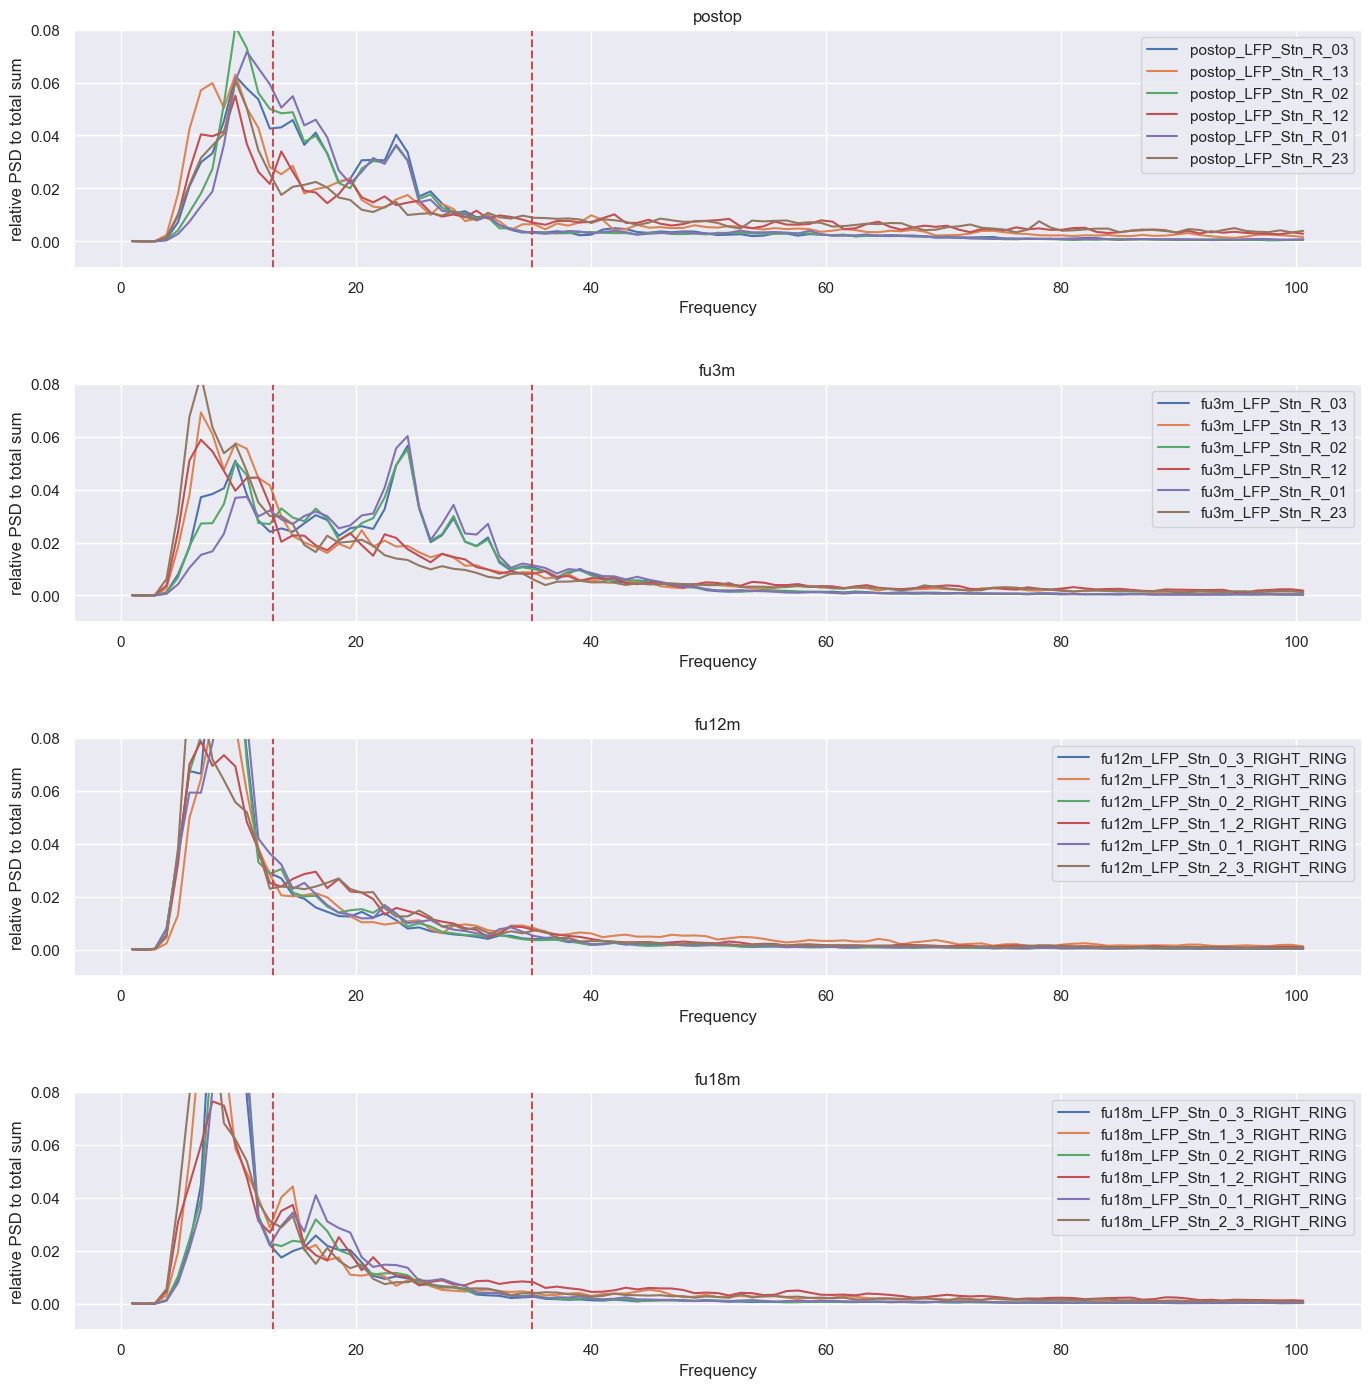

In [12]:
f_relPsd_024 = psdm.normalize_psd_toTotalSum(
   frequenciesDataFrame= frequencies_sub024,
   absolutePsdDataFrame= psd_sub024
)

Save the values of 
- relative psd
- frequencies

In [13]:
f_024 = f_relPsd_024[0]
relPsd024 = f_relPsd_024[1]

print(f_024, relPsd024)

     postop_postop_LFP_Stn_R_03  postop_postop_LFP_Stn_R_13  \
1                      0.976562                    0.976562   
2                      1.953125                    1.953125   
3                      2.929688                    2.929688   
4                      3.906250                    3.906250   
5                      4.882812                    4.882812   
..                          ...                         ...   
99                    96.679688                   96.679688   
100                   97.656250                   97.656250   
101                   98.632812                   98.632812   
102                   99.609375                   99.609375   
103                  100.585938                  100.585938   

     postop_postop_LFP_Stn_R_02  postop_postop_LFP_Stn_R_12  \
1                      0.976562                    0.976562   
2                      1.953125                    1.953125   
3                      2.929688                    2.9

Normalize psd values by total power
- divide power spectra by their total sum across 1-100 Hz


In [42]:
frequencies_sub024[1:104].iloc[:,0] # frequencies around 1-100 Hz 

1        0.976562
2        1.953125
3        2.929688
4        3.906250
5        4.882812
          ...    
99      96.679688
100     97.656250
101     98.632812
102     99.609375
103    100.585938
Name: postop_LFP_Stn_R_03, Length: 103, dtype: float64

In [27]:
# calculate the total sum of all psd values across 1-100 Hz of one subjec

totalSum_024 = psd_sub024[1:104].sum().sum()
# .sum() method calculates the mean of each column
# the second sum() calculates the mean of all column means

# divide each psd value of the data frame by the total psd sum
relative_psd_024 = psd_sub024[1:104].div(totalSum_024)

In [31]:
# divide columns by sessions
# save in a dictionary the new relative psd values 
time_points = ["postop", "fu3m", "fu12", "fu18m"]

rel_psd_dict = {}

for c, tp in enumerate(time_points):

    rel_psd_dict[f'{tp}_relative_psd_024'] = relative_psd_024.filter(like=tp) # filter DF by each session




ch_names = rel_psd_dict['fu3m_relative_psd_024'].columns
ch_names

#rel_psd_dict['postop_relative_psd_024']['postop_LFP_Stn_R_03']


Index(['fu3m_LFP_Stn_R_03', 'fu3m_LFP_Stn_R_13', 'fu3m_LFP_Stn_R_02',
       'fu3m_LFP_Stn_R_12', 'fu3m_LFP_Stn_R_01', 'fu3m_LFP_Stn_R_23'],
      dtype='object')

Normalize by dividing the psd by the total sum of each power spectrum
- e.g. Power Spectrum of postop R 03 -> psd values / total sum of all psd values (postopR03)

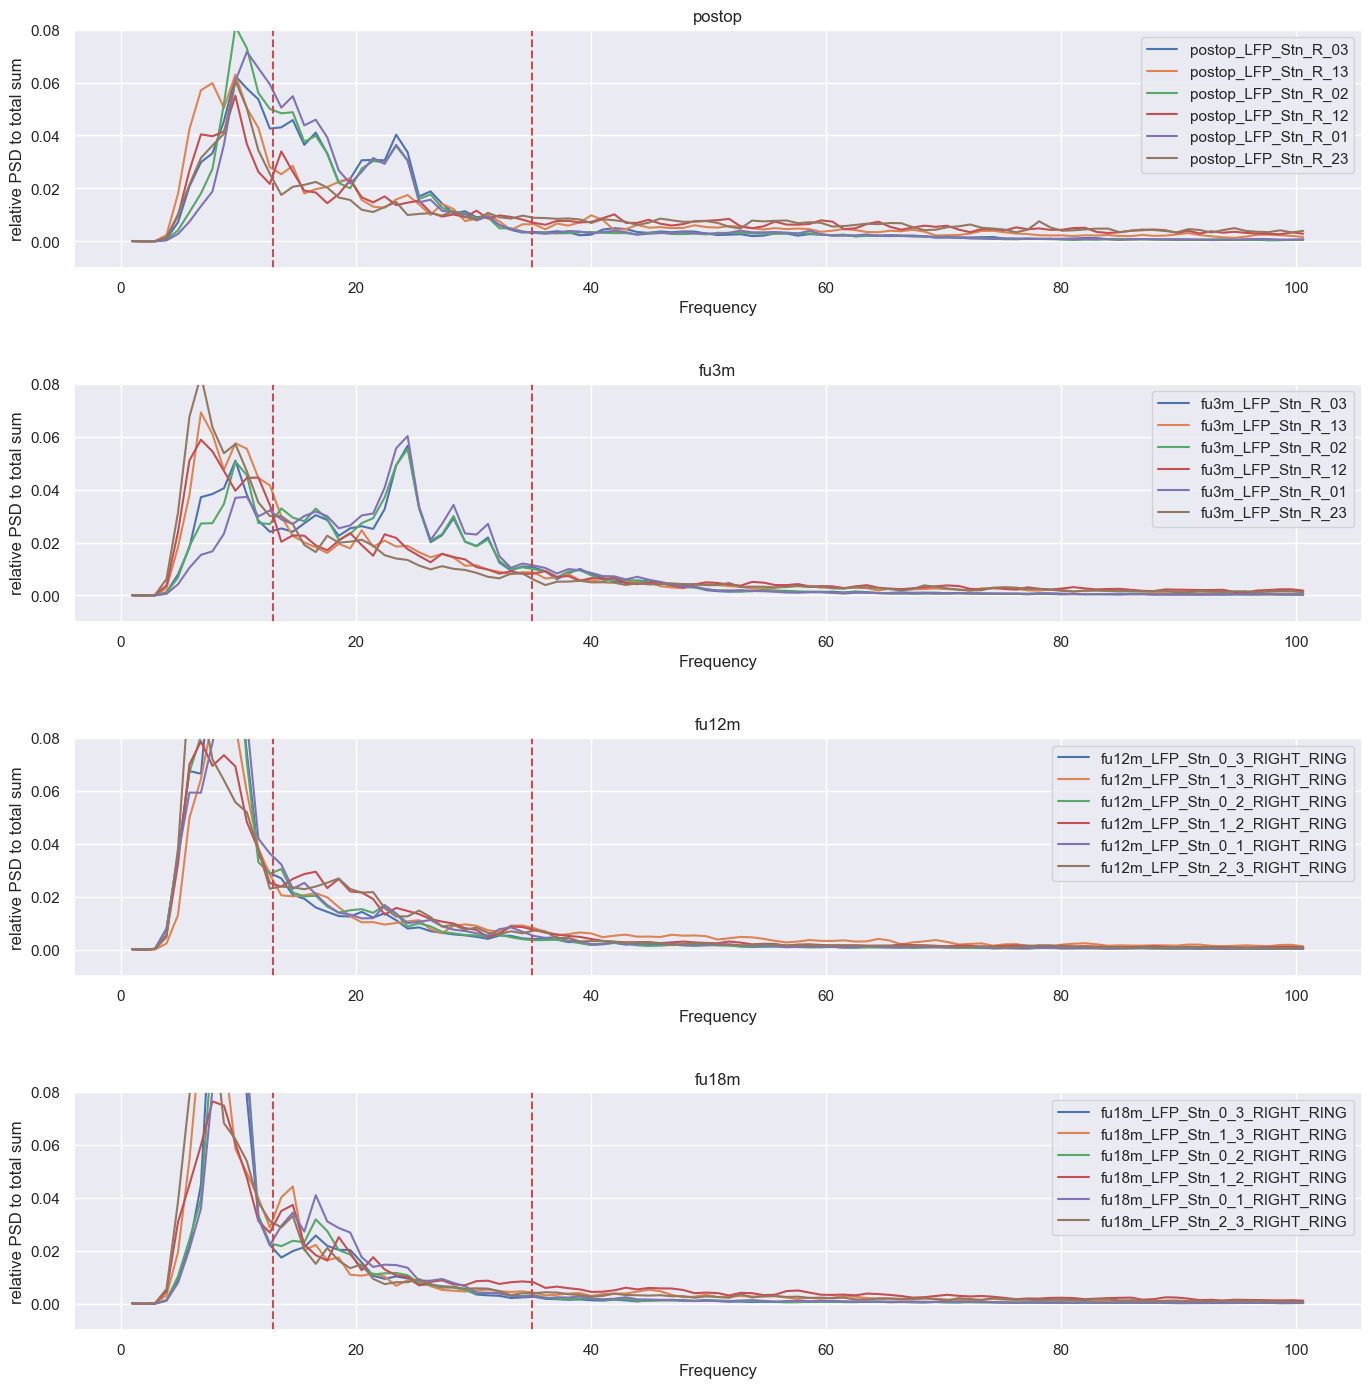

In [24]:
time_points = ['postop', 'fu3m', 'fu12m', 'fu18m']
f_1to100Hz_dict = {} # dict with keys('postop_f_1to100Hz_024', 'fu3m_f_1to100Hz_024', 'fu12m_f_1to100Hz_024', 'fu18m_f_1to100Hz_024')
psd_dict = {} # dict will be filled: keys('postop_relative_psd_024', 'fu3m_relative_psd_024', 'fu12_relative_psd_024', 'fu18m_relative_psd_024')

# get frequencies and psd values: f_px_sub024 is a tuple output after running calculate_psd_survey_m0s0() method
frequencies_sub024 = f_px_sub024[0]
psd_sub024 = f_px_sub024[1]

# just get Frequencies 1-100 Hz
f_1to100Hz_sub024 = frequencies_sub024[1:104]

# divide each psd value (across 1-100Hz) of the data frame by the total psd sum
# relative_psd_024 = psd_sub024[1:104].div(totalSum_psd_024)

# set layout for figures: using the object-oriented interface
fig, axes = plt.subplots(len(time_points), 1, figsize=(15, 15)) # subplot(rows, columns, panel number)
fig.tight_layout(pad=5.0) # space in between each plot

for t, tp in enumerate(time_points):

    # the title of each plot is set to the timepoint e.g. "postop"
    axes[t].set_title(tp) 

    # select the right frequency and psd columns per timepoint and add them to the empty dictionaries
    f_1to100Hz_dict[f'{tp}_f_1to100Hz_024'] = f_1to100Hz_sub024.filter(like=tp) # filter DF by each session
    psd_dict[f'{tp}_psd_024'] = psd_sub024[1:104].filter(like=tp) # filter DF by each session across 1-100Hz

    # get channel names by getting the column names from the DataFrame stored as values in the rel_psd_dict
    ch_names = psd_dict[f'{tp}_psd_024'].columns

    for i, ch in enumerate(ch_names):

        # get psd values from each channel column 
        absolute_psd = psd_dict[f'{tp}_psd_024'][ch] 
        f_1to100Hz = f_1to100Hz_dict[f'{tp}_f_1to100Hz_024'][ch]

        # normalize psd values to total sum of the same power spectrum
        totalSum_psd = absolute_psd.sum()
        rel_psd = absolute_psd.div(totalSum_psd)

        # get y-axis label and limits
        axes[t].get_ylabel()
        axes[t].get_ylim()

        # add errorbars
        # axes[t].errorbar(f, px, yerr=0.8, fmt='.k', color='lightgrey', ecolor='lightgrey')


        # find peaks: peaks is a tuple -> peaks[0] = index of frequency?, peaks[1] = dictionary with keys("peaks_height") 
        peaks = signal.find_peaks(rel_psd, height=0.1) # height: peaks only above 0.1 will be recognized
        peaks_height = peaks[1]["peak_heights"] # arraw of y-value of peaks = power
        peaks_pos = f_1to100Hz[peaks[0]] # array of indeces on x-axis of peaks = frequency

        # .plot() method for creating the plot, axes[0] refers to the first plot, the plot is set on the appropriate object axes[t]
        axes[t].plot(f_1to100Hz, rel_psd, label=ch)  # or np.log10(px)
        #axes[t].scatter(peaks_pos, peaks_height, color='r', s=15, marker='D')
            

for ax in axes: 
    ax.legend() # shows legend for each axes[t]
    ax.set(xlabel="Frequency", ylabel="relative PSD to total sum", ylim=(-0.01, 0.08)) # set y axis to -0.01 until 0.08(=8%)
    ax.axvline(x=13, color='r', linestyle='--')
    ax.axvline(x=35, color='r', linestyle='--')
    # ax.set(xlim=(10, 40), ylim=(-10, 4), xlabel="Frequency", ylabel="log10 Power")

plt.show() 

Peak detection
- search for Peaks in alpha and beta range
- set threshold for Peak detection?
- set min. peak prominence??

Use Plotly to plot 

In [22]:
!pip install plotly

In [96]:
import plotly.express as px
import plotly.subplots as subplots
import plotly.graph_objs as go

In [32]:
# use plotly to plot

time_points = ['postop', 'fu3m', 'fu12m', 'fu18m']
tasks_right = ['RestBSSuRingR', 'RestBSSuSegmInterR']
tasks_left = ['RestBSSuRingL', 'RestBSSuSegmInterL']


# set layout for figures: using the object-oriented interface
# fig, axes = plt.subplots(len(time_points), 1, figsize=(15, 15)) # subplot(rows, columns, panel number)
# fig.tight_layout(pad=5.0)

fig = subplots.make_subplots(rows=len(time_points), cols=1)


peak_array, freq_array = [], []



for t, tp in enumerate(time_points):

    for tk, task in enumerate(tasks_right): 

        # apply loop over channels
        temp_data = getattr(sub024.survey, tp) # gets attribute e.g. of tp "postop" from modality_class with modality set to survey
        temp_data = temp_data.m0s0.rest.data[tasks_right[tk]] # gets the mne loaded data from the perceive .mat BSSu, m0s0 file with task "RestBSSuRingR"

        # sample frequency: 250 Hz
        fs = temp_data.info['sfreq'] 

        # set filter parameters for high-pass filter
        filter_order = 5 # in MATLAB spm_eeg_filter default=5 Butterworth
        frequency_cutoff = 5 # 5Hz high-pass filter

        # create the filter
        b, a = signal.butter(filter_order, frequency_cutoff, btype='high', output='ba', fs=fs)

        # the title of each plot is set to the timepoint e.g. "postop"
        # axes[t].set_title(tp)  

        # create signal per channel with Welch´s method and plot
        for i, ch in enumerate(temp_data.info.ch_names):
            
            # create the filtered signal
            filtered = signal.filtfilt(b, a, temp_data.get_data()[i, :])

            # transform the filtered time series data into power spectral density using Welch
            f, peak = signal.welch(filtered, fs)  # Returns: f=array of sample frequencies, px= psd or power spectrum of x (amplitude)
            # density unit: V**2/Hz

            # find peaks: peaks is a tuple -> peaks[0] = index of frequency?, peaks[1] = dictionary with keys("peaks_height") 
            peaks = signal.find_peaks(px, height=0.1) # height: peaks only above 0.1 will be recognized
            peaks_height = peaks[1]["peak_heights"] # arraw of y-value of peaks = power
            peaks_pos = f[peaks[0]] # array of indeces on x-axis of peaks = frequency

            # .plot() method for creating the plot, axes[0] refers to the first plot, the plot is set on the appropriate object axes[t]
            fig.add_trace(go.Line(x=f, y=peak, color=ch))  # or np.log10(px)
            fig.add_trace(go.Scatter(x=peaks_pos, y=peaks_height))

            print(peaks)
            print('\n======\n')

        


            # calculate and plot power spectrum per channel in same plot of timepoint

# for ax in axes: 
#     ax.legend() # shows legend for each axes[t]
#     ax.set(xlabel="Frequency", ylabel=)
#     ax.get_ylim()
#     ax.axvline(x=13, color='r', linestyle='--')
#     ax.axvline(x=35, color='r', linestyle='--')
    # ax.set(xlim=(10, 40), ylim=(-10, 4), xlabel="Frequency", ylabel="log10 Power")

fig.show() # always needed to visualize the plot, in a .py file, use plt.show() only once and at the very end of the file -> it will plot all figures of the script


NameError: name 'subplots' is not defined

In [87]:
import plotly.express as px


# data = sub024.survey.fu3m.m0s0.rest.data['RestBSSuRingR']
# data = data.get_data()[0]

# df = px.data.gapminder().query("country=='Canada'")
# fig = px.line(df, x="year", y="lifeExp", title='Life expectancy in Canada')
# fig.show()

In [84]:
data = sub024.survey.fu3m.m0s0.rest.data['RestBSSuRingR']
data = data.to_data_frame()
data

# "inplace" keyword is for automatically saving the state of the DF; so you don't need to do data = data.drop(...)
# data.drop('time', axis=1, inplace=True)
# data

time  LFP_Stn_R_03  LFP_Stn_R_13  LFP_Stn_R_02  LFP_Stn_R_12  \
0      0.000      4.380876     -4.326490      4.156216     -1.360106   
1      0.004      1.010971     -5.578895      1.909613     -3.060238   
2      0.008      0.449321     -4.895765      0.000000     -3.626949   
3      0.012     -1.909613     -2.618665     -2.358933     -2.040159   
4      0.016     -5.728838     -2.618665     -5.841168     -2.606869   
...      ...           ...           ...           ...           ...   
5283  21.132     -2.583594     -1.252405     -2.920584     -2.040159   
5284  21.136     -5.504178      0.455420     -4.942527      1.020079   
5285  21.140     -5.391848      2.846375     -6.739809      1.246764   
5286  21.144     -2.021943      3.643360     -6.515149      1.360106   
5287  21.148      2.358933      2.277100     -0.561651      0.453369   

      LFP_Stn_R_01  LFP_Stn_R_23  
0         8.197560     -1.010971  
1         5.465040     -0.898641  
2         3.415650     -1.235632  
3        -0.113855     -0.224660  
4        -3.301795     -1.010971  
...            ...           ...  
5283     -1.252405      0.786311  
5284     -6.717445      1.347962  
5285    -10.133095      1.010971  
5286     -6.717445      2.583594  
5287      0.341565      3.931556  

[5288 rows x 7 columns]

In [91]:
fig = px.line(data, x=data["time"], y=data['LFP_Stn_R_03'], title= "Rawsignal")
fig.show()

In [104]:
fs = 250
f, peak = signal.welch(data["LFP_Stn_R_03"], fs) 


fig = px.line(data, x=f, y=peak, title= "Welch's psd")


fig.show()


In [118]:
# saving figures with savefig(), will be saved in the cwd
sub = '024'
fig.savefig(f'sub{sub}_plotPsdBSSu_m0s0.png')

# to view the .png code:
# from IPython.display import Image
# Image("sub024_plotPsdBSSu_m0s0.png")

Plotting Welch´s PSD:
compare matplotlib .psd function to .plot 

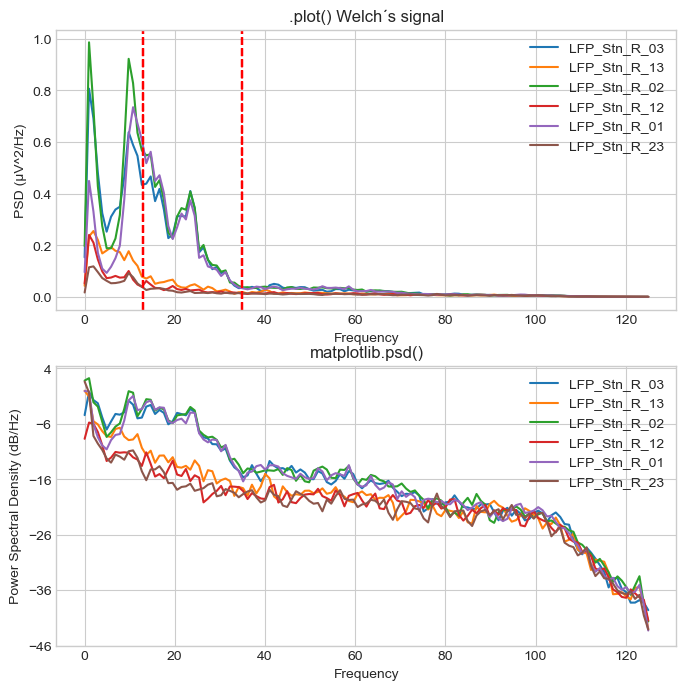

In [40]:
# plot Power Spectra with matplotlib function

# plot info
fs = raw.info['sfreq']


fig, axes = plt.subplots(2, 1, figsize=(8, 8))

for i, ch in enumerate(raw.info.ch_names):

    # transfer the signal into frequency domain using Welch´s method
    f, px = signal.welch(raw.get_data()[i, :], fs, scaling='density',return_onesided=True) # estimated power spectral density by averaging periodograms of overlapping windows
    
    # 256 instead of fs??
    # spectrum unit:  V**2
    # density unit: V**2/Hz
    # default Hann window with an overlap of 50%
    # default units of y-axis in logarithmic scale, this allows to see more detail of power values at lower frequencies


    # plotting without built-in function
    axes[0].plot(f, px, label=ch) # plot Welch´s signal
    axes[0].set_title(".plot() Welch´s signal")

    # mark Beta frequency 13-35 Hz with red lines
    axes[0].axvline(x=13, color='r', linestyle='--')
    axes[0].axvline(x=35, color='r', linestyle='--')
    axes[0].set(xlabel="Frequency", ylabel="PSD (µV^2/Hz)")


    # built-in matplotlib function (power in dB)
    axes[1].psd(
        raw.get_data()[i, :], Fs=fs,
        label=ch,
    )
    axes[1].set_title("matplotlib.psd()")
    # using Welch´s method
    # power is plotted as 10 log10(Pxx), but Pxx itself is returned

axes[0].legend()
axes[1].legend()

plt.show()

Plotting psd using PyWavelet, Wavelet Transformation
- install in Environment: conda install -c conda-forge pywavelets

In [10]:
import pywt

In [14]:
data=sub024.survey.fu3m.m0s0.rest.data['RestBSSuRingL'].get_data()

raw = data[0]

In [16]:
# perform a wavelet transformation using PyWavelets

data=sub024.survey.fu3m.m0s0.rest.data['RestBSSuRingL'].get_data()
raw = data[0]

wavelet = "db4"
level = 3


coeffs = pywt.wavedec(raw, wavelet, level=level)



[array([-2.71651827e+01, -2.51724517e+01, -2.65196145e+01, -2.52526308e+01,
        -2.51401645e+01, -3.06474945e+01, -2.62803881e+01, -2.99827086e+01,
        -2.58365253e+01, -2.39258777e+01, -3.43660707e+01, -1.89743146e+01,
        -1.85939578e+01, -2.98308215e+01, -2.10982988e+01, -1.89313730e+01,
        -1.72137936e+01, -1.56475121e+01, -1.32934159e+01, -2.51594169e+01,
        -2.67299806e+01,  2.16174541e+00, -2.30099494e+01, -1.67264975e+01,
        -1.59316800e+01, -1.77719414e+01, -1.53402150e+01, -3.48961957e+01,
        -1.39508853e+01, -7.44193460e+00, -2.36935414e+01, -1.66800326e+01,
        -1.28795226e+01, -3.04572011e+01, -2.32503123e+01, -4.07886234e+01,
        -3.13961200e+01, -2.92898466e+01, -1.70864581e+01, -2.49070603e+01,
        -2.77605680e+01, -1.77700873e+00, -1.48155263e+01, -7.35948890e+00,
        -1.07763593e+01, -7.13732993e+00, -1.98691364e+01, -1.42117427e+01,
        -1.92995041e+00, -3.09777204e+01, -3.32240119e+01, -2.08528488e+01,
        -1.5

Plotting psd using MNE

In [21]:
from mne import time_frequency

raw = sub024.survey.fu3m.m0s0.rest.data['RestBSSuRingR']
raw.get_data()[0, :]
fs = 

# spectrum = time_frequency.psd_array_welch(raw.get_data()[0, :], )

# spectrum = raw.compute_psd(method="welch")

ValueError: picks (NoneNone, treated as "data") yielded no channels, consider passing picks explicitly

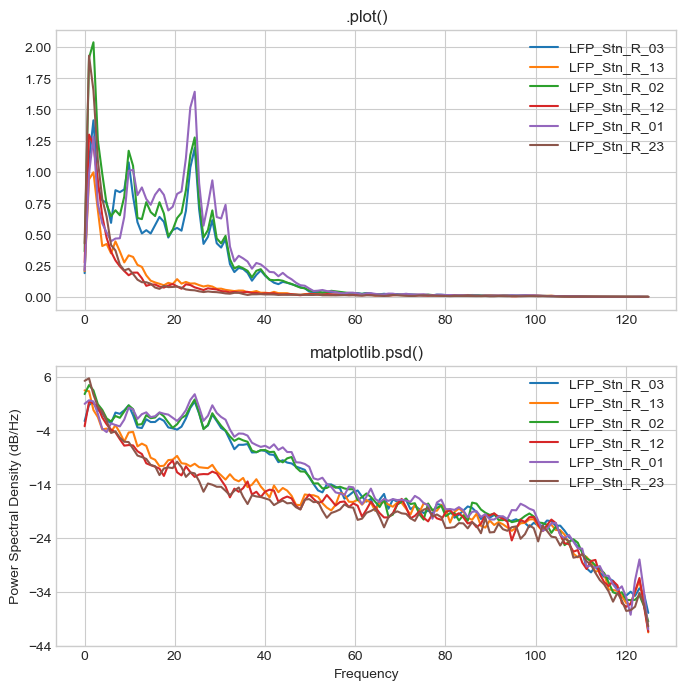

In [42]:
# plot info
raw = sub024.survey.fu3m.m0s0.rest.data['RestBSSuRingR']

fs = raw.info['sfreq']


fig, axes = plt.subplots(2, 1, figsize=(8, 8))

for i, ch in enumerate(raw.info.ch_names):

    # transfer the signal into frequency domain using Welch´s method
    f, px = signal.welch(raw.get_data()[i, :], fs, scaling='density',) # estimated power spectral density by averaging periodograms of overlapping windows
    # 256 instead of fs??
    # spectrum unit:  V**2
    # density unit: V**2/Hz
    # default Hann window with an overlap of 50%


    # plotting without built-in function
    axes[0].plot(f, px, label=ch) # plot power as log10 of power
    axes[0].set_title(".plot()")

    # built-in matplotlib function (power in dB), using the periodogram method
    axes[1].psd(
        raw.get_data()[i, :], Fs=fs,
        label=ch,
    )
    axes[1].set_title("matplotlib.psd()")
    # using Welch´s method
    # power is plotted as 10 log10(Pxx), but Pxx itself is returned

axes[0].legend()
axes[1].legend()

plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\63740021.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=ch)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\63740021.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=ch)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\63740021.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=ch)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\63740021.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=ch)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\63740021.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=ch)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\63740021.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=ch)


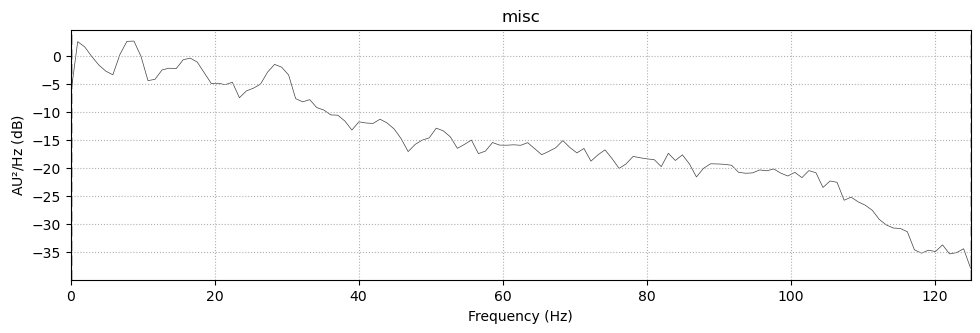

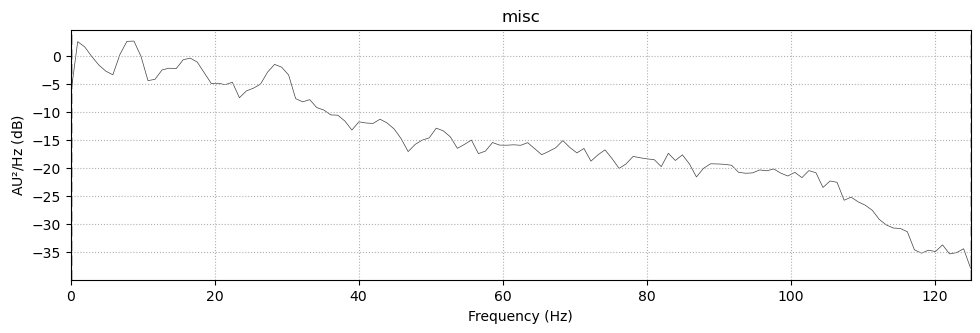

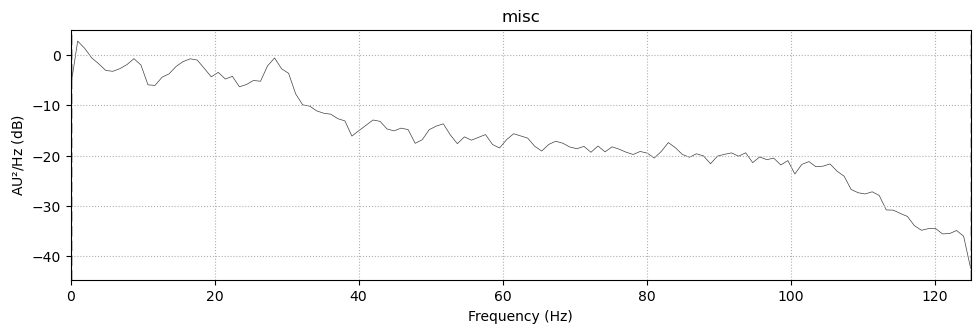

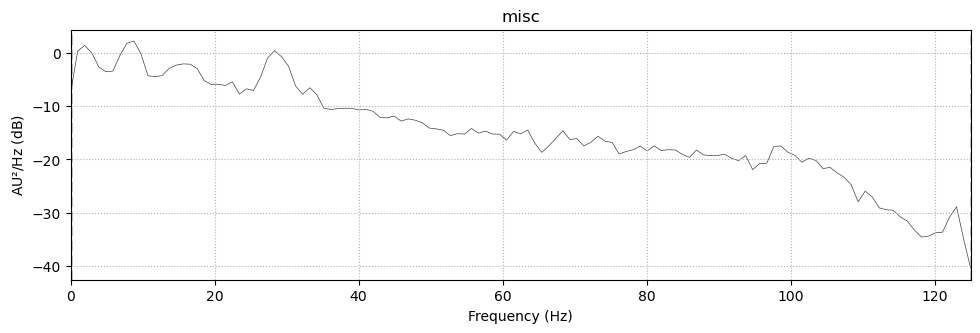

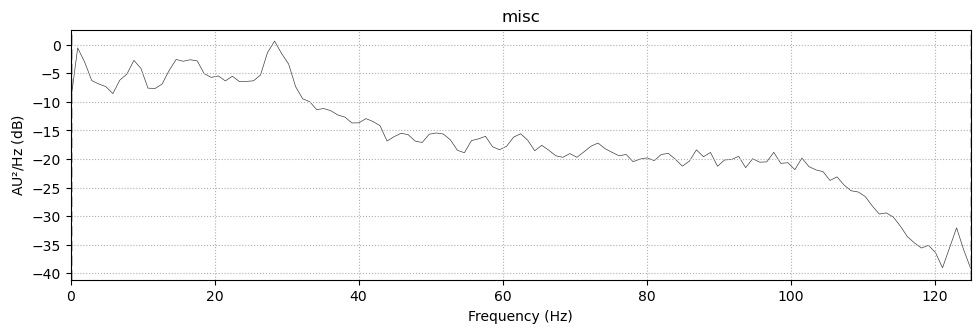

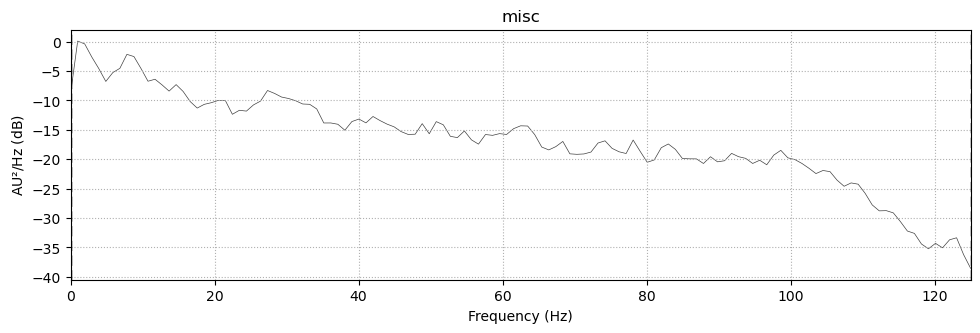

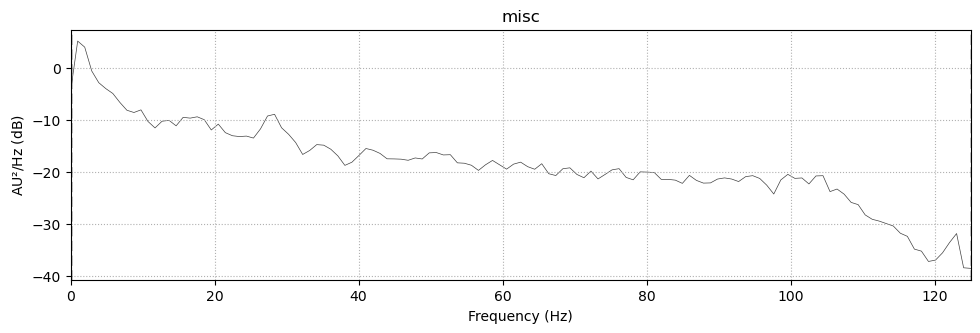

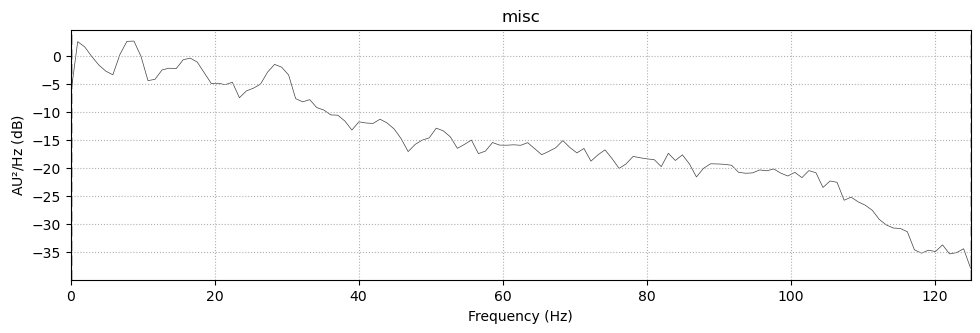

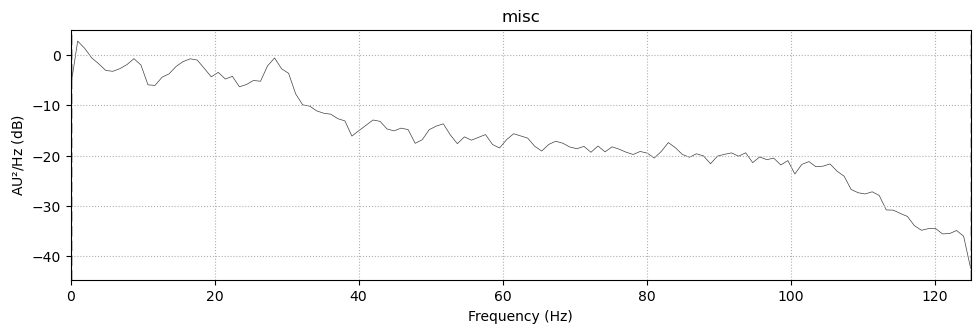

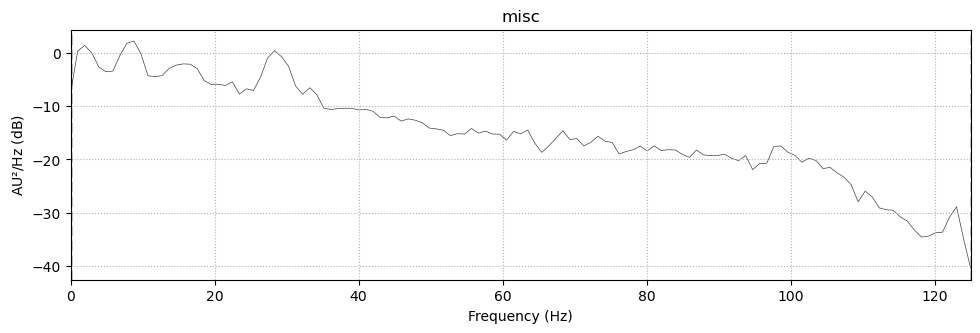

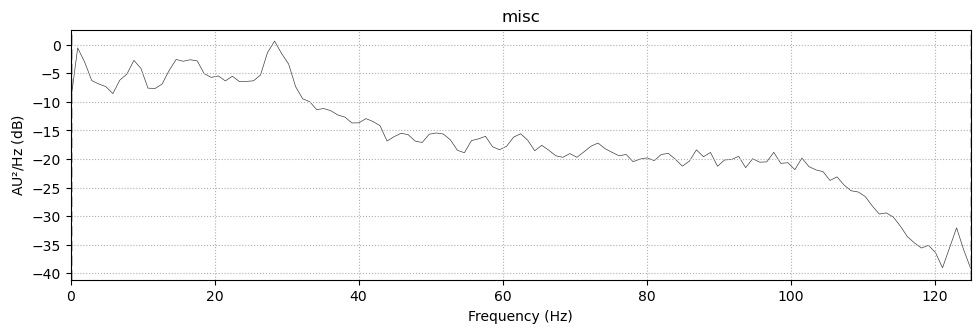

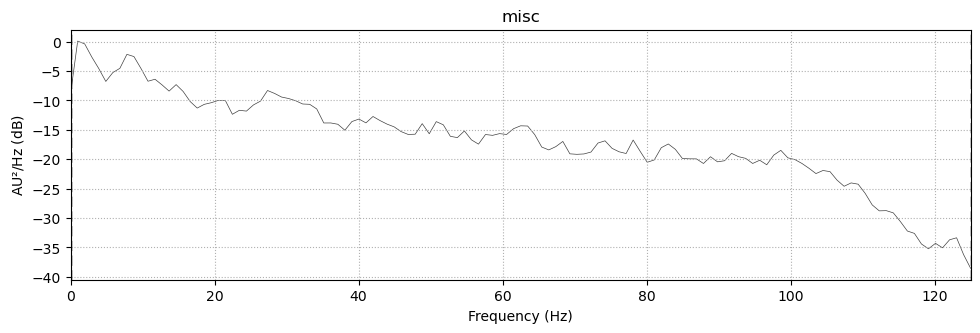

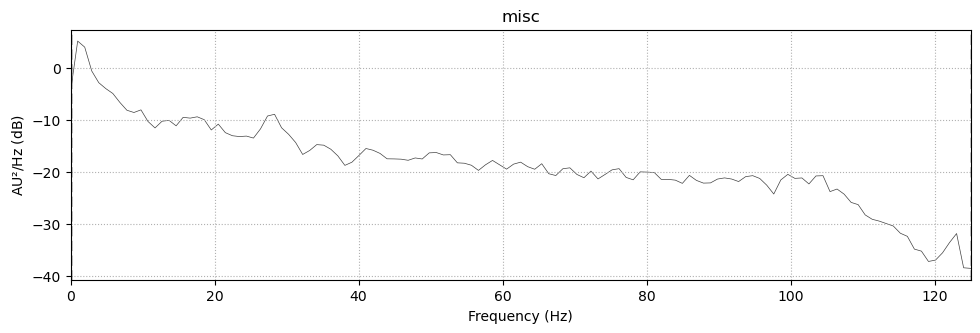

In [62]:
# mne built-in methods
for ch in raw.info.ch_names:
    raw.plot_psd(picks=ch)

plt.show()

Using matplotlib as 2D backend.


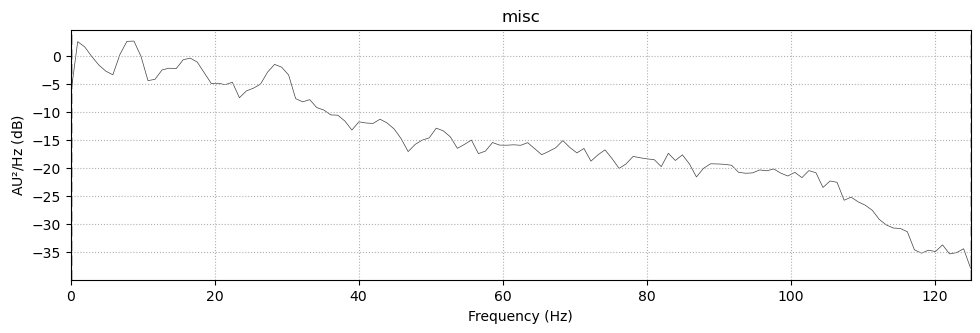

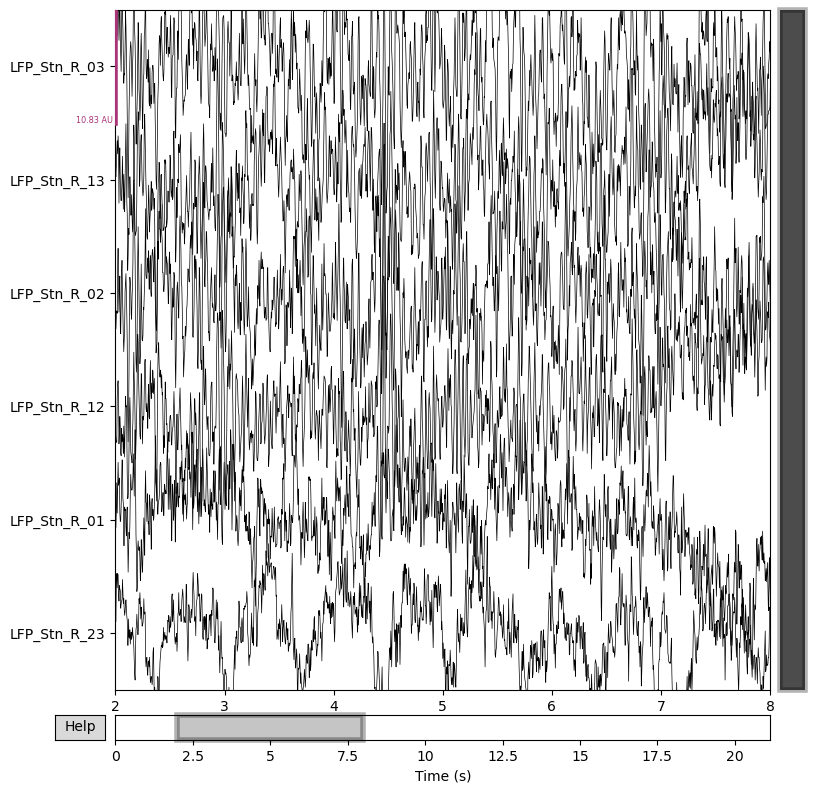

Figure(800x800)


In [38]:
fig = raw.plot(start=2, duration=6)
print(fig)


Effective window size : 1.024 (s)


C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\2976338963.py:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot(picks = chs_to_plot, average=False, color='b')


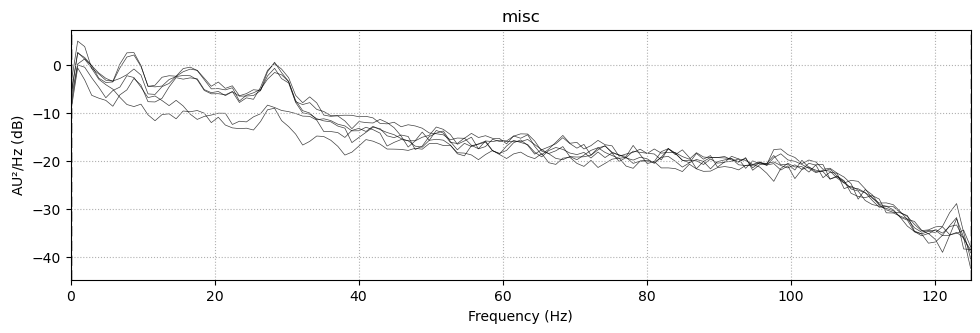

In [39]:
chs_to_plot = [
    'LFP_Stn_R_03',	
    'LFP_Stn_R_13',	
    'LFP_Stn_R_02',	
    'LFP_Stn_R_12',	
    'LFP_Stn_R_01',	
    'LFP_Stn_R_23'
    ]

# to plot spectral power create object spectrum
spectrum = raw.compute_psd(picks = chs_to_plot )

# spectrum has a built-in plot() method 
spectrum.plot(picks = chs_to_plot, average=False, color='b')

### Plot and calculate PSD (Wavelet Transformation)

In [113]:
import pywt
import PerceiveImport.classes.main_class as mainclass

load the signal

In [114]:
raw_sub024 = mainclass.PerceiveData(
    sub = "024",
    incl_modalities= ["survey"],
    incl_session= ["postop","fu3m","fu12m","fu18m"],
    incl_condition=["m0s0"],
    incl_task= ["rest"]
)

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618062900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063200_4.mat
Creating RawArray with float64 data, n_channels=3, n_times=5187
    Range : 0 ... 5186 =      0.000 ...    20.744 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063300_5.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063400_6.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_7.mat
Creating RawArray with float64 data, n_channels=3,

In [45]:
sub024_postop_RingR = raw_sub024.survey.postop.m0s0.rest.data['RestBSSuRingR']
data=sub024_postop_RingR.get_data()

LFP_Stn_R_03 = data[0]

Transform data using a Morlet Wavelet Transformation

In [46]:
# set the parameters for the wavelet transformation
wavelet = "morl" # Type of wavelet to use (Morlet wavelet)
sampling_rate = 250 # Sampling rate of the LFP signal
fmin = 1 # Lower frequency limit for the power spectrum
fmax = 100 # Upper frequency limit for the power spectrum

# Calculate the wavelet coefficients of the LFP signal
coefficients, frequencies, times, _, _ = pywt.cwt(LFP_Stn_R_03, sampling_rate, wavelet, fmin, fmax)

# Calculate the power spectrum from the wavelet coefficients
power_spectrum = np.abs(coefficients) ** 2

# Plot the power spectrum
plt.imshow(power_spectrum, aspect="auto", origin="lower")

ValueError: method must be 'conv' or 'fft'

In [38]:
# perform a wavelet transformation using PyWavelets

#data=sub024.survey.fu3m.m0s0.rest.data['RestBSSuRingL'].get_data()
#raw = data[0]

wavelet = "db4"
level = 3


coeffs = pywt.wavedec(data, wavelet, level=level)


### Matplotlib Playground

In [40]:
# extract a selection of raw[]

start_stop_seconds = np.array([11, 13])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)

channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]

print(f'We here selected the timepoints from {start_sample} until {stop_sample}' 
      f'\nand selected the channel {raw.ch_names[channel_index]}')

# print(raw_selection)

We here selected the timepoints from 2750 until 3250
and selected the channel LFP_Stn_R_03


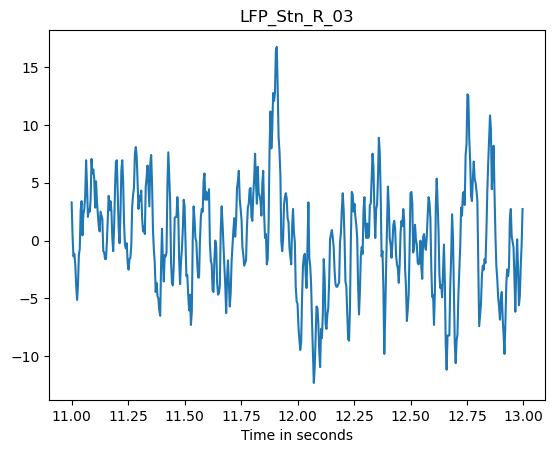

In [42]:
# plot the selected 2 arrays

x = raw_selection[1]        # time in seconds
y = raw_selection[0].T      # data from ch_trials[channel_index]

plt.plot(x, y)

plt.title(str(raw.ch_names[channel_index]))
plt.xlabel("Time in seconds")
# plt.ylabel() ???

plt.show()

<Figure size 640x480 with 0 Axes>

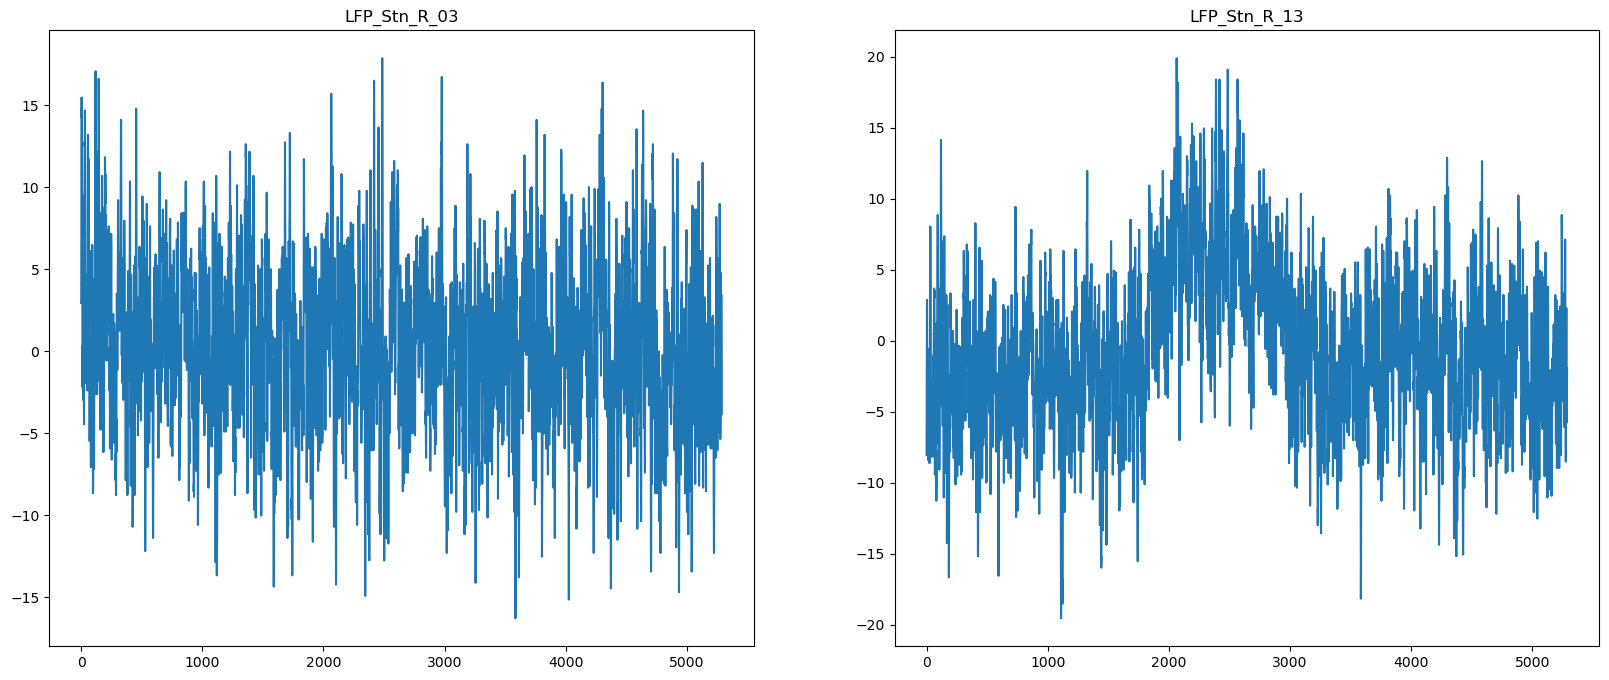

In [43]:
# plotting first and second trials from first 2 channels 

plt.suptitle("Raw data of channels left and right")

plt.figure(figsize= (20, 8))

# plot raw data of channel LFP_R_1A1B_STN
plt.subplot(1,2,1)
plt.plot(raw._data[0])
plt.title(str(raw.ch_names[0]))

# plot raw data of channel LFP_R_1B1C_STN
plt.subplot(1,2,2)
plt.plot(raw._data[1])
plt.title(str(raw.ch_names[1]))

plt.show()


In [44]:
# from Varvara

#Make some nice plots of the data

#channels to plot:
chs_to_plot = [
    'LFP_Stn_R_03',	
    'LFP_Stn_R_13',	
    'LFP_Stn_R_02',	
    'LFP_Stn_R_12',	
    'LFP_Stn_R_01',	
    'LFP_Stn_R_23'
    ]

plot_times = raw.times #timepoints set to zero
xticks = np.linspace(0, plot_times[-1], 5) #make 5 x-axis ticks, dividing the seconds by 5

fig, axes = plt.subplots(
    1, len(chs_to_plot), figsize=(18, 6)
) #define n of subplots and size

# axes = axes.flatten()
ax_c = 0 

for i, name in enumerate(chs_to_plot):

    
    if name in chs_to_plot:

        if name[-3:] == 'STN': # last three letters 
            axes[ax_c].psd(raw._data[i, :]) # e.g. raw._data[1,:] will output index 1 of all raw._data -> data from 2nd channel 
            axes[ax_c].set_title(
                f'PSD {name}',
                fontsize=16, color='r'
            )

        else:
            
            axes[ax_c].plot(plot_times, raw._data[i, :]) # e.g. raw._data[1,:] will output index 1 of all raw._data -> data from 2nd channel 
            axes[ax_c].set_title(name, fontsize=16, color='r')
            axes[ax_c].set_xticks(xticks)
            axes[ax_c].set_xticklabels(np.around(xticks / 60, 1))
                
        ax_c += 1 # count for-loop

In [45]:
raw._data

array([[ 2.96023003,  2.96023003,  8.19756008, ..., -3.87107004,
        -1.48011501,  3.41565003],
       [-8.04263409, -5.17026477,  0.45957909, ..., -5.74473864,
        -2.41279023, -1.95321114],
       [ 4.36600136,  3.10215886,  6.3192125 , ...,  2.527685  ,
         4.59579091,  7.12347591],
       [-4.21263504, -4.32649004, -1.59397002, ..., -2.04939002,
         0.91084001,  3.52950503],
       [ 9.00290141,  8.31037054,  7.73326147, ...,  3.5780762 ,
         2.77012351,  2.77012351],
       [-1.02935271, -1.60121533,  0.91498019, ..., -4.57490095,
        -2.8593131 , -3.77429329]])

In [75]:
raw.tmin

0.0

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\2182701887.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin = 5, fmax = 50, picks = 1, tmin = raw.tmin, tmax = raw.tmax,  dB = False, estimate = 'amplitude')


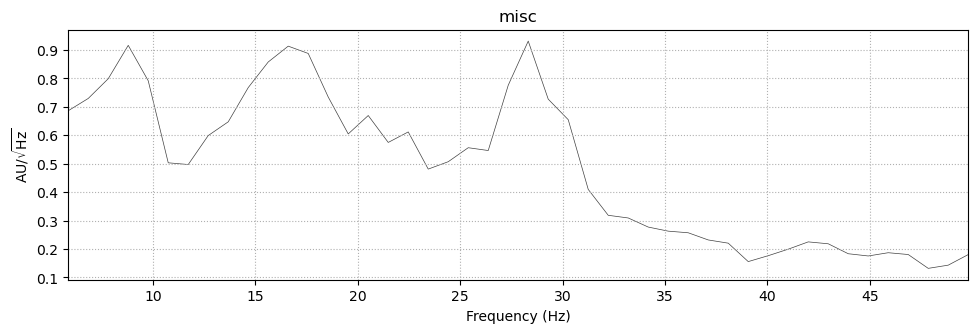

In [46]:
#raw.compute_psd(picks = chs_to_plot ).plot(fmin = 5, fmax = 50, picks = 1, tmin = 0, tmax = 10, dB = False, estimate = 'amplitude')
raw.plot_psd(fmin = 5, fmax = 50, picks = 1, tmin = raw.tmin, tmax = raw.tmax,  dB = False, estimate = 'amplitude')


# time: tmin - tmax (continuos data)

In [47]:
chan = 1 # set channel we want

start_time = int((1000 / 1000) * raw.info['sfreq']) # 250
end_time   = int((10000 / 1000) * raw.info['sfreq']) # 2500

raw._data[chan, start_time:end_time]


array([-5.51494909, -7.46816023, -7.46816023, ..., -0.22978955,
        1.03405295,  1.83831636])

In [48]:
mydat = raw.get_data(picks=['LFP_Stn_R_03'], start=1, stop=201)
print(mydat.shape)

(1, 200)


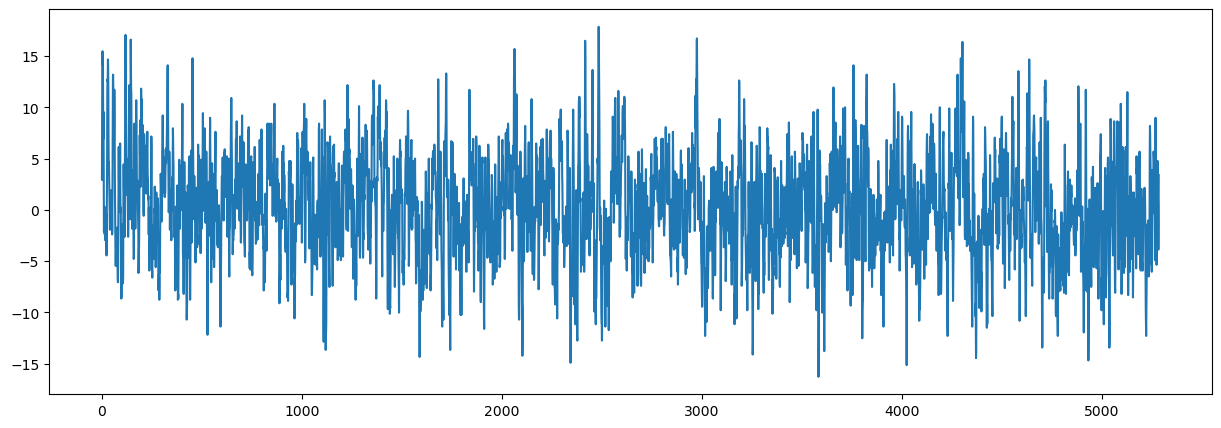

In [51]:
fig, ax = plt.subplots(figsize=[15, 5])

ax.plot(raw.get_data(picks=['LFP_Stn_R_03'],start=1, stop=20000).T)
plt.show()

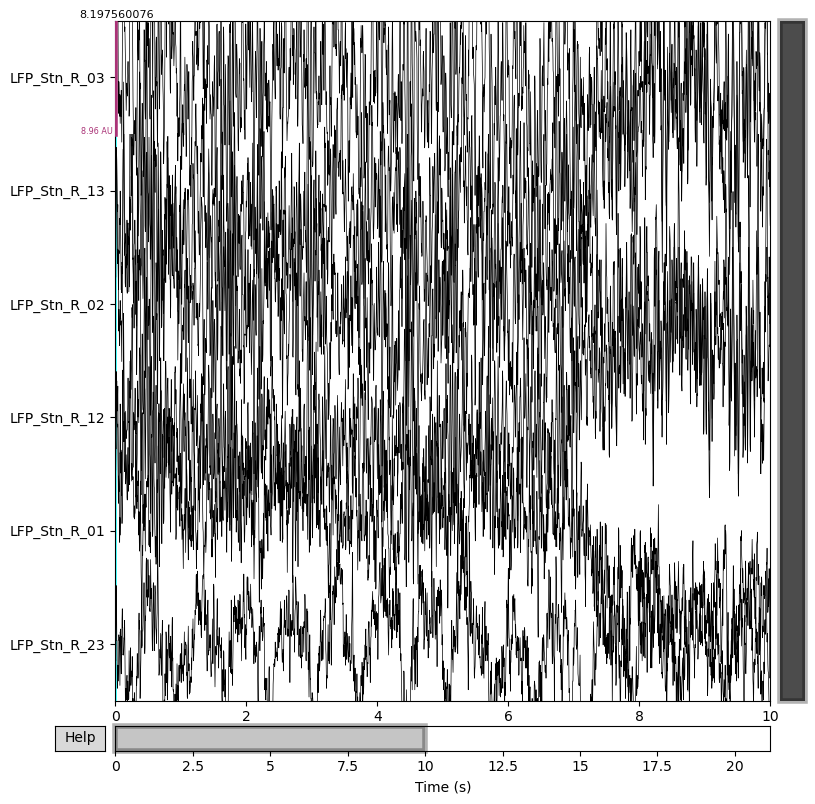

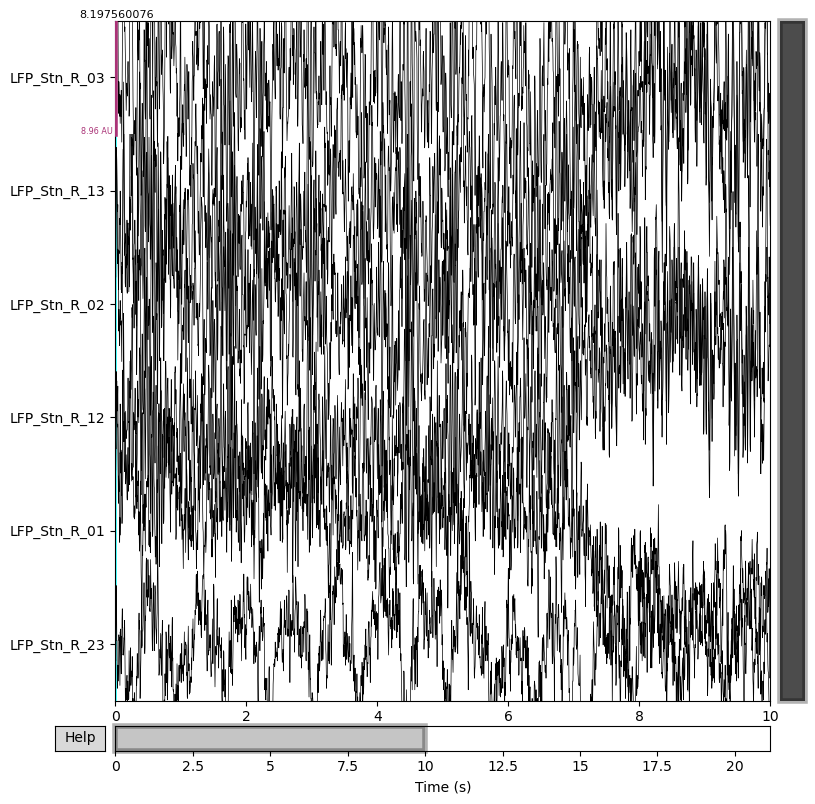

In [53]:
raw.plot(raw.get_data(picks='LFP_Stn_R_03'))

In [96]:
raw.info['bads'] = [
    'LFP_R_1A1B_STN', 
    'LFP_R_1B1C_STN', 
    'LFP_R_1A1C_STN',
    'LFP_R_2A2B_STN', 
    'LFP_R_2B2C_STN', 
    'LFP_R_2A2C_STN',] 

picks = mne.pick_types(raw.info, meg='mag', eeg=False, eog=False,
                       stim=False, exclude='bads')

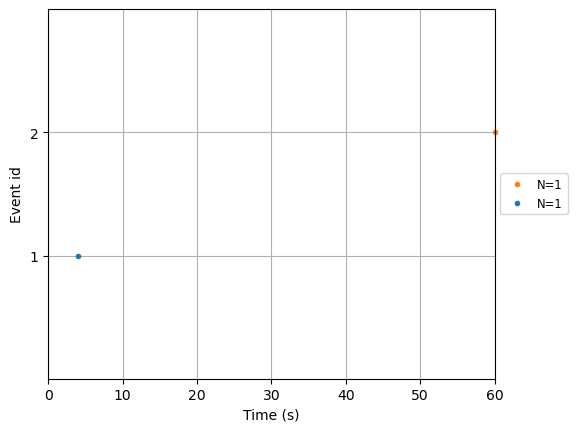

Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2 events and 2501 original time points ...
1 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


C:\Users\jebe12\AppData\Local\Temp\ipykernel_15384\1477881095.py:9: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks = 0)


IndexError: list index out of range

In [97]:
#events = mne.find_events(raw, stim_channel='LFP_R_13_STN') -> no stim channel in BrainSenseSurvey
trial_onsets = np.array([
       [ 1000 ,      0 ,    1],
       [ 15000 ,      0 ,    2 ]]) #we need the samples

event_dict = {'NoStim':1,'Threshold':2}
fig = mne.viz.plot_events(trial_onsets, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)
epochs = mne.Epochs(raw,events=trial_onsets,event_id = event_dict, tmin=0, tmax=10, baseline = None, preload = True)
epochs.plot_image(picks = 0)

In [99]:
# nostim_ep = epochs['NoStim']
# stim_ep = epochs['Threshold']
# stim_ep.plot_image(picks = 1)

In [100]:
M = 200
NFFT = M
win = hanning(M)
overlap = 0.25
overlap_samples = int(round(M*overlap)) # overlap in samples
t, f, S = spectrogram(mydat,window=win,nperseg=M,noverlap=overlap_samples,nfft=NFFT)

# Compute average spectrum
avg_S = np.mean(S,axis=1)

NameError: name 'hanning' is not defined

In [108]:
vars(tfr_morlet)

{'__wrapped__': <function mne.time_frequency.tfr.tfr_morlet(inst, freqs, n_cycles, use_fft=False, return_itc=True, decim=1, n_jobs=None, picks=None, zero_mean=True, average=True, output='power', verbose=None)>,
 '__qualname__': 'tfr_morlet',
 '__globals__': {'__name__': 'mne.time_frequency.tfr',
  '__doc__': 'A module which implements the time-frequency estimation.\n\nMorlet code inspired by Matlab code from Sheraz Khan & Brainstorm & SPM\n',
  '__package__': 'mne.time_frequency',
  '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x1e124cdfb80>,
  '__spec__': ModuleSpec(name='mne.time_frequency.tfr', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000001E124CDFB80>, origin='c:\\Users\\jebe12\\anaconda3\\envs\\pyPerceive_dev\\lib\\site-packages\\mne\\time_frequency\\tfr.py'),
  '__file__': 'c:\\Users\\jebe12\\anaconda3\\envs\\pyPerceive_dev\\lib\\site-packages\\mne\\time_frequency\\tfr.py',
  '__cached__': 'c:\\Users\\jebe12\\anaconda3\\envs\\pyPerceive_dev

In [107]:
freqs = np.arange(1, 125)
D = tfr_morlet(epochs, freqs=freqs, n_cycles=6, return_itc=False, average=True, picks = 1)

In [110]:
spectrogram(
    mydat,
    fs=125.0, 
#             window=('hanning', 0.25), 
    nperseg=1, 
    noverlap=0.25, 
    nfft=None, 
    detrend='constant', 
    return_onesided=True, 
    scaling='density', 
    axis=- 1, 
    mode='psd')

(array([0.]),
 array([0.004, 0.012, 0.02 , 0.028, 0.036, 0.044, 0.052, 0.06 , 0.068,
        0.076, 0.084, 0.092, 0.1  , 0.108, 0.116, 0.124, 0.132, 0.14 ,
        0.148, 0.156, 0.164, 0.172, 0.18 , 0.188, 0.196, 0.204, 0.212,
        0.22 , 0.228, 0.236, 0.244, 0.252, 0.26 , 0.268, 0.276, 0.284,
        0.292, 0.3  , 0.308, 0.316, 0.324, 0.332, 0.34 , 0.348, 0.356,
        0.364, 0.372, 0.38 , 0.388, 0.396, 0.404, 0.412, 0.42 , 0.428,
        0.436, 0.444, 0.452, 0.46 , 0.468, 0.476, 0.484, 0.492, 0.5  ,
        0.508, 0.516, 0.524, 0.532, 0.54 , 0.548, 0.556, 0.564, 0.572,
        0.58 , 0.588, 0.596, 0.604, 0.612, 0.62 , 0.628, 0.636, 0.644,
        0.652, 0.66 , 0.668, 0.676, 0.684, 0.692, 0.7  , 0.708, 0.716,
        0.724, 0.732, 0.74 , 0.748, 0.756, 0.764, 0.772, 0.78 , 0.788,
        0.796, 0.804, 0.812, 0.82 , 0.828, 0.836, 0.844, 0.852, 0.86 ,
        0.868, 0.876, 0.884, 0.892, 0.9  , 0.908, 0.916, 0.924, 0.932,
        0.94 , 0.948, 0.956, 0.964, 0.972, 0.98 , 0.988, 0.996,

In [54]:
raw = raw.filter(l_freq=90, h_freq=5, picks=['LFP_R_1A1B_STN', 'LFP_R_1B1C_STN'])

ValueError: picks (['LFP_R_1A1B_STN', 'LFP_R_1B1C_STN']) could not be interpreted as channel names (no channel "['LFP_R_1A1B_STN', 'LFP_R_1B1C_STN']"), channel types (no type "LFP_R_1A1B_STN"), or a generic type (just "all" or "data")

### Get Impedances

In [10]:
import PerceiveImport.methods.find_folders as findfolders
importlib.reload(findfolders)

<module 'PerceiveImport.methods.find_folders' from 'c:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\code\\PerceiveImport\\methods\\find_folders.py'>

In [12]:
# define path to Longterm_beta_project
Longterm_beta_project = findfolders.get_local_path(folder='Longterm_beta_project')
Longterm_beta_project

'c:\\Users\\jebe12\\Research\\Longterm_beta_project'

In [16]:
path_to_impedanceFile = os.path.join(Longterm_beta_project, "Data", "NEW_perceive", 'sub_024_18mfu')

df = pd.read_csv(os.path.join(path_to_impedanceFile, 'sub-20210615PStn_ses-1948072210000072_run-Impedance.csv'))
print(df)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\jebe12\\Research\\Longterm_beta_project\\Data\\NEW_perceive\\sub_024_18mfu\\sub-20210615PStn_ses-1948072210000072_run-Impedance.csv'

## 4. Preprocessing

In [119]:
# detecting power line noise
fig = raw.compute_psd(picks=chs_to_plot, tmax=np.inf, fmax=125.0, average=None).plot(picks=chs_to_plot)
fig.show()

# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)

Effective window size : 1.024 (s)
Aggregating Welch estimates (median) before plotting...


C:\Users\jebe12\AppData\Local\Temp\ipykernel_15384\3965450946.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw.compute_psd(picks=chs_to_plot, tmax=np.inf, fmax=125.0, average=None).plot(picks=chs_to_plot)
c:\Users\jebe12\anaconda3\envs\pyPerceive_dev\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_15384\3965450946.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [122]:
#from mne.preprocessing import create_eog_epochs, create_ecg_epochs, compute_proj_ecg, compute_proj_eog

# detect ecg artifacts

ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
ecg_epochs.plot_image(combine='mean')

ValueError: Unable to generate artificial ECG channel

## UPDRS Analysis

## Impedance Changes

In [6]:
from PerceiveImport.methods import find_folders

In [7]:
sub = '024'
json_path = os.path.join(find_folders.get_onedrive_path('perceivedata'), f'sub-{sub}', 'raw_jsons')
# perceive_path = os.path.join(find_folders.get_onedrive_path('perceivedata'), f'sub-{sub}', 'raw_perceive')

fname = os.listdir(json_path)[0] # first filename of all JSON files in that folder

with open(os.path.join(json_path, fname), 'r') as f:
    json_object = json.loads(f.read())

print(json_object.keys()) # get all keys in the json file and go through every key

dict_keys(['AbnormalEnd', 'FullyReadForSession', 'FeatureInformationCode', 'SessionDate', 'SessionEndDate', 'ProgrammerTimezone', 'ProgrammerUtcOffset', 'ProgrammerLocale', 'ProgrammerVersion', 'PatientInformation', 'DeviceInformation', 'BatteryInformation', 'GroupUsagePercentage', 'LeadConfiguration', 'Stimulation', 'Groups', 'BatteryReminder', 'MostRecentInSessionSignalCheck', 'Impedance', 'GroupHistory', 'SenseChannelTests', 'CalibrationTests', 'DiagnosticData'])


## Consistency of Clinical stimulation contact